# Get Ready for the Libraries

In [ ]:
!pip install catboost
!pip install yfinance
!pip install seaborn
!pip install PyPortfolioOpt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from math import exp
from datetime import date,timedelta
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import black_litterman, plotting, objective_functions
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

# Get Ready for the datasets

In [3]:
!gdown --id 1qLoKEZHEjqvjgBB1CFX62oh7IGJptAk7
!gdown --id 1YZmaQNzgpkj-DHbyFUhzzSDXKajabViF
!gdown --id 1KRYPKo4ZEZdbq0RCmIutu6n93FYAjQDN

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1qLoKEZHEjqvjgBB1CFX62oh7IGJptAk7
To: /content/S&P500.csv
100% 33.1k/33.1k [00:00<00:00, 30.0MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1YZmaQNzgpkj-DHbyFUhzzSDXKajabViF
To: /content/market_cap.csv
100% 7.90k/7.90k [00:00<00:00, 8.86MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: h

# Import data from Yahoo Finance

In [4]:
#list of stock codes of S&P stocks
tickers_csv = pd.read_csv("S&P500.csv")
tickers = list(tickers_csv["Symbol"])

#eliminate stocks that are too new and have insuffcient traning data
bug_stocks = ["BRK.B","BF.B","EMBC","CEG","OGN","CARR","OTIS","CTVA","MRNA","FOX","FOXA","DOW","CDAY","IR"]
tickers = list(set(tickers) - set(bug_stocks))

In [5]:
# Get AdjClose, Close, High, Low, Open, Volume
yf.pdr_override()
end = pd.to_datetime("30/04/2022")
start = end - timedelta(days=5000)
data = yf.download(tickers, start=start, end=end,group_by="ticker", interval="1d")

[*********************100%***********************]  491 of 491 completed


In [ ]:
data_to_process = pd.DataFrame.copy(data)
data_processed = data_to_process.dropna(axis=0)
data_processed

In [ ]:
#Get information on SnP for comparison
SnP_start=data_processed.index[0].date()
SnP_end=date.today()
SnP=yf.download('^GSPC',start=SnP_start, end=SnP_end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
#Calculate log daily log return of S&P
SnP['SnP Log Return']=np.log(SnP['Close'])-np.log(SnP['Close']).shift(1)
SnP

,Open,High,Low,Close,Adj Close,Volume,SnP Log Return
Date,,,,,,,
2016-11-10,2167.489990,2182.300049,2151.169922,2167.479980,2167.479980,6451640000,NaN
2016-11-11,2162.709961,2165.919922,2152.489990,2164.449951,2164.449951,4988050000,-0.001399
2016-11-14,2165.639893,2171.360107,2156.080078,2164.199951,2164.199951,5367200000,-0.000116
2016-11-15,2168.290039,2180.840088,2166.379883,2180.389893,2180.389893,4543860000,0.007453
2016-11-16,2177.530029,2179.219971,2172.199951,2176.939941,2176.939941,3830590000,-0.001584
...,...,...,...,...,...,...,...
2022-05-03,4159.779785,4200.100098,4147.080078,4175.479980,4175.479980,3877530000,0.004825
2022-05-04,4181.180176,4307.660156,4148.910156,4300.169922,4300.169922,4236210000,0.029425
2022-05-05,4270.430176,4270.430176,4106.009766,4146.870117,4146.870117,4197620000,-0.036301


# Feature Engineering

In [ ]:
def find_std(data,period,start_date):

    df = data.copy()
    end = df.index.get_loc(start_date)
    start=end-period
    if start>=0:
        log_return=df['Log Return'].iloc[start:end]
        std=np.std(log_return, ddof=1)
        return std
    else:
        return np.NaN


def find_beta(data,period,start_date):

    df = data.copy()
    end=df.index.get_loc(start_date)
    start=end-period
    if start>=0:
        log_return=df['Log Return'].iloc[start:end].to_numpy()
        SnP_log_return=df['SnP Log Return'].iloc[start:end].to_numpy().reshape(-1,1)

        regr = LinearRegression()
        beta=regr.fit(SnP_log_return,log_return).coef_[0]
        return beta
    else:
        return np.NaN

def ShiftNum(var):
    if var[1]=='D':
        return int(var[0])
    elif var[1]=='W':
        return int(var[0])*5
    elif var[1]=='M':
        return int(var[0])*20
    elif var[1]=='Y':
        return int(var[0])*250
    else:
        return("Please give a str whose format is xD, xW, xM, xY.")

In [ ]:
stocks={}
return_lag=['1D','3D','1W','2W','3W','1M','6W','2M','3M']
for stock in tickers:
    stocks[stock]=data_processed[stock][['Close']].copy()

    #retain stock code as a feature
    stocks[stock]['Stock']=[stock]*stocks[stock].shape[0]

    #daily log return of stocks
    stocks[stock]['Log Return']=np.log(stocks[stock]['Close'])-np.log(stocks[stock]['Close']).shift(1)

    #join with SnP return for generating other features 
    #(SnP return on that day will not be used as feature to avoid data leakage)
    stocks[stock]=stocks[stock].join(SnP[['SnP Log Return']], how='left')

    #SnP return of yesterday as a feature
    stocks[stock]['SnP Log Return_1D']=stocks[stock]['SnP Log Return'].shift(1)
    stocks[stock].dropna(inplace=True)

    #calculate s.d. of stock return in the past 30 days
    stocks[stock]['Volatility']=[ find_std(stocks[stock],30,date) for date in stocks[stock].index]

    #calculate beta(a measure of a stock's volatility in relation to the overall market) for the past 30days
    stocks[stock]['Beta']=[ find_beta(stocks[stock],30,date) for date in stocks[stock].index]

    #Use return from n_days ago as feature
    for var in return_lag:
        name = 'Return_' + var
        stocks[stock][name] =  stocks[stock]['Log Return'].shift(ShiftNum(var))

In [ ]:
#join information of all stocks in one df
cleaned=pd.DataFrame()
for stock in tickers:
    cleaned=pd.concat([cleaned,stocks[stock]])
cleaned.dropna(inplace=True)

# Data Processing

In [ ]:
# Read csv Files
riskfree = pd.read_csv('risk_free.csv')
market_cap = pd.read_csv("market_cap.csv").astype("int64")

# For cleaned
cleaned.index = pd.to_datetime(cleaned.index)
SnP_Return = cleaned[["SnP Log Return"]]
cleaned = cleaned.drop(columns=["SnP Log Return","Close"],axis=1)
cleaned = cleaned.sort_values(by=["Stock","Date"])

# For Market Capitalisation
market_cap = market_cap.iloc[0]
market_cap = market_cap.to_dict()

In [ ]:
# Get list[date] for later looping
date_list = cleaned.index
date_list = date_list.drop_duplicates()
stock_list = cleaned["Stock"]
stock_list = stock_list.drop_duplicates()

In [ ]:
SnP_Return = SnP_Return.drop_duplicates()
SnP_Return = SnP_Return.reset_index().drop_duplicates().set_index("Date")

In [ ]:
log_return_df = cleaned[['Stock','Log Return']].reset_index().set_index(['Stock','Date']).unstack(level=[0])
log_return_df = log_return_df["Log Return"]

In [ ]:
# Import SPY Data from API
SPY = yf.download('SPY', start=date_list[0], end=date_list[-1])

[*********************100%***********************]  1 of 1 completed


# Main Body for Machine Learning & Optimisation

In [ ]:
# Adjustible parameters
n_days=252
training_len=100

# Pre-set parameters
trade_days=date_list[-n_days:]
daily_return = []
ms_daily_return = []
mv_daily_return = []
seed=0

# Looping
for trade_day in trade_days:
    print(trade_day)
    trade_day_index=date_list.get_loc(trade_day)
    first_training_day_index=trade_day_index-training_len
    train_valid_dates=date_list[first_training_day_index:trade_day_index]
    
    # Train Validation Split
    train_days, eval_days=train_test_split(train_valid_dates,test_size=0.7,random_state=seed)
    seed+=1

    train_data=cleaned.loc[train_days,:]
    eval_data=cleaned.loc[eval_days,:]
    trade_day_data = cleaned.loc[trade_day]

    train_x=train_data.drop(['Log Return'],axis=1)
    train_y=train_data['Log Return']
    eval_x=eval_data.drop(['Log Return'],axis=1)
    eval_y=eval_data['Log Return']
    trade_day_x=trade_day_data.drop(['Log Return'],axis=1)
    trade_day_y=trade_day_data['Log Return']

    # Establish CatBoost Model 
    model=CatBoostRegressor(iterations=100,task_type="CPU",learning_rate=0.1,
                depth=8,l2_leaf_reg=0.0000001,allow_writing_files=False,
                eval_metric='MAPE',random_seed=0,thread_count=-1)
    eval_set=Pool(eval_x,eval_y,cat_features=[0])

    catboost_train_data = Pool(data=train_x,label=train_y,cat_features=[0])
    model.fit(catboost_train_data,
              eval_set=eval_set,
              plot=False,
              early_stopping_rounds=10)
    
    # Prediction from CatBoost Model
    preds_log_return=model.predict(trade_day_x)

    # Append Predicted Array to Log Return DataFrame
    temp_df = pd.DataFrame(preds_log_return).transpose()
    temp_df.columns = stock_list
    log_return_opt_df = log_return_df[first_training_day_index:trade_day_index]
    log_return_opt_df = log_return_opt_df.append(temp_df)
    log_return_opt_df.index = date_list[first_training_day_index:trade_day_index+1]

    # Ready for Optimisation
    portfolio = log_return_opt_df.applymap(lambda x: exp(x))
    cs_actual = CovarianceShrinkage(portfolio, frequency=len(log_return_opt_df))
    e_cov = cs_actual.ledoit_wolf()

    # Prepare Variables for Black Litterman Model
    market_prices = SPY.loc[log_return_opt_df.index[0]:log_return_opt_df.index[-2]]
    annual_risk_free = riskfree.loc[trade_day_index]['Price']/100
    daily_risk_free = (1+annual_risk_free)**(1/252)-1
    delta = black_litterman.market_implied_risk_aversion(market_prices['Close'], risk_free_rate=daily_risk_free)
    prior = black_litterman.market_implied_prior_returns(market_cap, delta, e_cov)
    viewdict={trade_day_x['Stock'].values[i]:exp(preds_log_return[i])-1 for i in range(len(preds_log_return))}
    bl = BlackLittermanModel(e_cov, pi=prior, absolute_views=viewdict)
    # Posterior estimate of returns
    ret_bl = bl.bl_returns()
    S_bl = bl.bl_cov()

    # Perform Maximum Sharpe Ratio Portfolio
    ms_ef = EfficientFrontier(ret_bl, S_bl,verbose=False)
    ms_ef.add_objective(objective_functions.L2_reg)

    # Decide Method of Optimisation by Error
    try:
      ms_ef.max_sharpe()
      ms_weights = ms_ef.clean_weights()
    except:
      ms_weights = ms_ef.nonconvex_objective(objective_functions.sharpe_ratio,
                          objective_args=(ms_ef.expected_returns, ms_ef.cov_matrix),
                          weights_sum_to_one=True,)
    ms_weights = list(ms_weights.values())
    ms_expected_return = ms_weights@temp_df.iloc[0].to_numpy().T
    ms_return = ms_weights@trade_day_y.to_numpy().T
    ms_daily_return = np.append(ms_daily_return,ms_return)

    # Perform Minimum Volatility Portfolio
    mv_ef = EfficientFrontier(ret_bl, S_bl)
    mv_ef.add_objective(objective_functions.L2_reg)
    mv_ef.min_volatility()
    mv_weights = mv_ef.clean_weights()

    mv_weights = list(mv_weights.values())
    mv_expected_return = mv_weights@temp_df.iloc[0].to_numpy().T
    mv_return = mv_weights@trade_day_y.to_numpy().T
    mv_daily_return = np.append(mv_daily_return,mv_return)

    # Adopt Better Prediction from Maximum Sharpe Ratio Portfolio or Minimum Volatility Portfolio
    if (ms_expected_return>mv_expected_return):
      daily_return = np.append(daily_return,ms_return)
    else:
      daily_return = np.append(daily_return,mv_return)

2021-05-03 00:00:00
0:	learn: 0.0140153	test: 0.0143340	best: 0.0143340 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0138727	test: 0.0143407	best: 0.0143340 (0)	total: 31.7ms	remaining: 1.55s
2:	learn: 0.0137792	test: 0.0143471	best: 0.0143340 (0)	total: 47ms	remaining: 1.52s
3:	learn: 0.0136710	test: 0.0143406	best: 0.0143340 (0)	total: 62.8ms	remaining: 1.51s
4:	learn: 0.0135557	test: 0.0143389	best: 0.0143340 (0)	total: 78.3ms	remaining: 1.49s
5:	learn: 0.0134853	test: 0.0143459	best: 0.0143340 (0)	total: 93.2ms	remaining: 1.46s
6:	learn: 0.0133690	test: 0.0143616	best: 0.0143340 (0)	total: 108ms	remaining: 1.44s
7:	learn: 0.0132900	test: 0.0143637	best: 0.0143340 (0)	total: 125ms	remaining: 1.43s
8:	learn: 0.0132205	test: 0.0143689	best: 0.0143340 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0131143	test: 0.0143838	best: 0.0143340 (0)	total: 158ms	remaining: 1.43s
10:	learn: 0.0130516	test: 0.0144201	best: 0.0143340 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-05-04 00:00:00
0:	learn: 0.0135968	test: 0.0145400	best: 0.0145400 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0134891	test: 0.0145493	best: 0.0145400 (0)	total: 32.5ms	remaining: 1.59s
2:	learn: 0.0133765	test: 0.0145411	best: 0.0145400 (0)	total: 48.3ms	remaining: 1.56s
3:	learn: 0.0133056	test: 0.0145464	best: 0.0145400 (0)	total: 64.8ms	remaining: 1.55s
4:	learn: 0.0132108	test: 0.0145876	best: 0.0145400 (0)	total: 80.4ms	remaining: 1.53s
5:	learn: 0.0131074	test: 0.0146003	best: 0.0145400 (0)	total: 97.7ms	remaining: 1.53s
6:	learn: 0.0130255	test: 0.0145923	best: 0.0145400 (0)	total: 113ms	remaining: 1.5s
7:	learn: 0.0129662	test: 0.0146160	best: 0.0145400 (0)	total: 130ms	remaining: 1.5s
8:	learn: 0.0128825	test: 0.0146303	best: 0.0145400 (0)	total: 146ms	remaining: 1.47s
9:	learn: 0.0128190	test: 0.0146338	best: 0.0145400 (0)	total: 161ms	remaining: 1.45s
10:	learn: 0.0127503	test: 0.0146433	best: 0.0145400 (0)	total: 176ms	remaining: 1.43s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-05-05 00:00:00
0:	learn: 0.0145327	test: 0.0141698	best: 0.0141698 (0)	total: 31.8ms	remaining: 3.15s
1:	learn: 0.0143826	test: 0.0141867	best: 0.0141698 (0)	total: 81.2ms	remaining: 3.98s
2:	learn: 0.0142162	test: 0.0142056	best: 0.0141698 (0)	total: 115ms	remaining: 3.73s
3:	learn: 0.0141018	test: 0.0142216	best: 0.0141698 (0)	total: 167ms	remaining: 4.01s
4:	learn: 0.0139654	test: 0.0142650	best: 0.0141698 (0)	total: 213ms	remaining: 4.04s
5:	learn: 0.0138468	test: 0.0142944	best: 0.0141698 (0)	total: 265ms	remaining: 4.15s
6:	learn: 0.0137115	test: 0.0143065	best: 0.0141698 (0)	total: 310ms	remaining: 4.12s
7:	learn: 0.0136002	test: 0.0143398	best: 0.0141698 (0)	total: 371ms	remaining: 4.27s
8:	learn: 0.0134882	test: 0.0143878	best: 0.0141698 (0)	total: 408ms	remaining: 4.13s
9:	learn: 0.0133896	test: 0.0144414	best: 0.0141698 (0)	total: 441ms	remaining: 3.96s
10:	learn: 0.0133018	test: 0.0144470	best: 0.0141698 (0)	total: 488ms	remaining: 3.95s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-05-06 00:00:00
0:	learn: 0.0140889	test: 0.0144293	best: 0.0144293 (0)	total: 16.7ms	remaining: 1.65s
1:	learn: 0.0139576	test: 0.0144811	best: 0.0144293 (0)	total: 31.9ms	remaining: 1.56s
2:	learn: 0.0138190	test: 0.0145315	best: 0.0144293 (0)	total: 47ms	remaining: 1.52s
3:	learn: 0.0137340	test: 0.0145807	best: 0.0144293 (0)	total: 62.7ms	remaining: 1.5s
4:	learn: 0.0135909	test: 0.0146245	best: 0.0144293 (0)	total: 77.7ms	remaining: 1.48s
5:	learn: 0.0134527	test: 0.0146607	best: 0.0144293 (0)	total: 92.8ms	remaining: 1.45s
6:	learn: 0.0133261	test: 0.0146646	best: 0.0144293 (0)	total: 108ms	remaining: 1.44s
7:	learn: 0.0132581	test: 0.0147001	best: 0.0144293 (0)	total: 123ms	remaining: 1.41s
8:	learn: 0.0131496	test: 0.0147066	best: 0.0144293 (0)	total: 149ms	remaining: 1.51s
9:	learn: 0.0130584	test: 0.0147324	best: 0.0144293 (0)	total: 194ms	remaining: 1.75s
10:	learn: 0.0129565	test: 0.0147988	best: 0.0144293 (0)	total: 238ms	remaining: 1.93s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-05-07 00:00:00
0:	learn: 0.0152850	test: 0.0138235	best: 0.0138235 (0)	total: 55.2ms	remaining: 5.46s
1:	learn: 0.0150447	test: 0.0138658	best: 0.0138235 (0)	total: 70.9ms	remaining: 3.48s
2:	learn: 0.0148641	test: 0.0138820	best: 0.0138235 (0)	total: 86.1ms	remaining: 2.78s
3:	learn: 0.0146907	test: 0.0139524	best: 0.0138235 (0)	total: 102ms	remaining: 2.44s
4:	learn: 0.0145456	test: 0.0140055	best: 0.0138235 (0)	total: 118ms	remaining: 2.24s
5:	learn: 0.0144006	test: 0.0140110	best: 0.0138235 (0)	total: 133ms	remaining: 2.09s
6:	learn: 0.0142264	test: 0.0140343	best: 0.0138235 (0)	total: 149ms	remaining: 1.98s
7:	learn: 0.0140629	test: 0.0140748	best: 0.0138235 (0)	total: 164ms	remaining: 1.89s
8:	learn: 0.0139447	test: 0.0140880	best: 0.0138235 (0)	total: 182ms	remaining: 1.84s
9:	learn: 0.0138161	test: 0.0141128	best: 0.0138235 (0)	total: 197ms	remaining: 1.77s
10:	learn: 0.0136810	test: 0.0141916	best: 0.0138235 (0)	total: 213ms	remaining: 1.72s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-05-10 00:00:00
0:	learn: 0.0129849	test: 0.0149602	best: 0.0149602 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0128762	test: 0.0149880	best: 0.0149602 (0)	total: 31ms	remaining: 1.52s
2:	learn: 0.0127694	test: 0.0150084	best: 0.0149602 (0)	total: 46.1ms	remaining: 1.49s
3:	learn: 0.0126671	test: 0.0150434	best: 0.0149602 (0)	total: 62ms	remaining: 1.49s
4:	learn: 0.0125866	test: 0.0150526	best: 0.0149602 (0)	total: 77.2ms	remaining: 1.47s
5:	learn: 0.0125080	test: 0.0150743	best: 0.0149602 (0)	total: 92.1ms	remaining: 1.44s
6:	learn: 0.0124404	test: 0.0150913	best: 0.0149602 (0)	total: 107ms	remaining: 1.42s
7:	learn: 0.0123865	test: 0.0151042	best: 0.0149602 (0)	total: 123ms	remaining: 1.41s
8:	learn: 0.0123231	test: 0.0150892	best: 0.0149602 (0)	total: 138ms	remaining: 1.39s
9:	learn: 0.0122537	test: 0.0151232	best: 0.0149602 (0)	total: 153ms	remaining: 1.38s
10:	learn: 0.0121762	test: 0.0151458	best: 0.0149602 (0)	total: 170ms	remaining: 1.38s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-05-11 00:00:00
0:	learn: 0.0125398	test: 0.0150137	best: 0.0150137 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0124334	test: 0.0150072	best: 0.0150072 (1)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0122816	test: 0.0150139	best: 0.0150072 (1)	total: 47.3ms	remaining: 1.53s
3:	learn: 0.0121755	test: 0.0150238	best: 0.0150072 (1)	total: 63.5ms	remaining: 1.52s
4:	learn: 0.0120675	test: 0.0150356	best: 0.0150072 (1)	total: 79.3ms	remaining: 1.51s
5:	learn: 0.0119654	test: 0.0150396	best: 0.0150072 (1)	total: 94.4ms	remaining: 1.48s
6:	learn: 0.0118624	test: 0.0150596	best: 0.0150072 (1)	total: 110ms	remaining: 1.46s
7:	learn: 0.0117898	test: 0.0150717	best: 0.0150072 (1)	total: 125ms	remaining: 1.44s
8:	learn: 0.0117041	test: 0.0150747	best: 0.0150072 (1)	total: 141ms	remaining: 1.43s
9:	learn: 0.0116319	test: 0.0150924	best: 0.0150072 (1)	total: 157ms	remaining: 1.41s
10:	learn: 0.0115527	test: 0.0151024	best: 0.0150072 (1)	total: 172ms	remaining: 1.39s
11:	learn: 0.0114934	test: 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-05-12 00:00:00
0:	learn: 0.0134030	test: 0.0147616	best: 0.0147616 (0)	total: 15.5ms	remaining: 1.54s
1:	learn: 0.0132393	test: 0.0147681	best: 0.0147616 (0)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0130789	test: 0.0147902	best: 0.0147616 (0)	total: 47.2ms	remaining: 1.53s
3:	learn: 0.0129471	test: 0.0148184	best: 0.0147616 (0)	total: 62.8ms	remaining: 1.51s
4:	learn: 0.0128247	test: 0.0148361	best: 0.0147616 (0)	total: 77.9ms	remaining: 1.48s
5:	learn: 0.0127238	test: 0.0148653	best: 0.0147616 (0)	total: 93.2ms	remaining: 1.46s
6:	learn: 0.0126383	test: 0.0148802	best: 0.0147616 (0)	total: 108ms	remaining: 1.44s
7:	learn: 0.0125594	test: 0.0149024	best: 0.0147616 (0)	total: 124ms	remaining: 1.42s
8:	learn: 0.0124715	test: 0.0148810	best: 0.0147616 (0)	total: 140ms	remaining: 1.42s
9:	learn: 0.0123959	test: 0.0148894	best: 0.0147616 (0)	total: 156ms	remaining: 1.4s
10:	learn: 0.0123142	test: 0.0148917	best: 0.0147616 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-05-13 00:00:00
0:	learn: 0.0148250	test: 0.0142782	best: 0.0142782 (0)	total: 16.4ms	remaining: 1.63s
1:	learn: 0.0146281	test: 0.0142778	best: 0.0142778 (1)	total: 33.4ms	remaining: 1.64s
2:	learn: 0.0144589	test: 0.0142666	best: 0.0142666 (2)	total: 48.8ms	remaining: 1.58s
3:	learn: 0.0143220	test: 0.0142653	best: 0.0142653 (3)	total: 64.8ms	remaining: 1.55s
4:	learn: 0.0141815	test: 0.0143053	best: 0.0142653 (3)	total: 79.8ms	remaining: 1.51s
5:	learn: 0.0140613	test: 0.0142941	best: 0.0142653 (3)	total: 94.9ms	remaining: 1.49s
6:	learn: 0.0139280	test: 0.0142990	best: 0.0142653 (3)	total: 110ms	remaining: 1.46s
7:	learn: 0.0138470	test: 0.0143048	best: 0.0142653 (3)	total: 128ms	remaining: 1.47s
8:	learn: 0.0137667	test: 0.0143174	best: 0.0142653 (3)	total: 144ms	remaining: 1.45s
9:	learn: 0.0136626	test: 0.0143332	best: 0.0142653 (3)	total: 160ms	remaining: 1.44s
10:	learn: 0.0135213	test: 0.0143729	best: 0.0142653 (3)	total: 175ms	remaining: 1.42s
11:	learn: 0.0134287	test: 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-05-14 00:00:00
0:	learn: 0.0144844	test: 0.0144605	best: 0.0144605 (0)	total: 29.9ms	remaining: 2.96s
1:	learn: 0.0143075	test: 0.0144453	best: 0.0144453 (1)	total: 50.3ms	remaining: 2.46s
2:	learn: 0.0141200	test: 0.0144501	best: 0.0144453 (1)	total: 90.3ms	remaining: 2.92s
3:	learn: 0.0139863	test: 0.0144576	best: 0.0144453 (1)	total: 135ms	remaining: 3.24s
4:	learn: 0.0138567	test: 0.0144508	best: 0.0144453 (1)	total: 155ms	remaining: 2.95s
5:	learn: 0.0137260	test: 0.0144512	best: 0.0144453 (1)	total: 184ms	remaining: 2.88s
6:	learn: 0.0135864	test: 0.0144662	best: 0.0144453 (1)	total: 217ms	remaining: 2.89s
7:	learn: 0.0134922	test: 0.0144883	best: 0.0144453 (1)	total: 240ms	remaining: 2.76s
8:	learn: 0.0134028	test: 0.0145044	best: 0.0144453 (1)	total: 278ms	remaining: 2.81s
9:	learn: 0.0132952	test: 0.0145072	best: 0.0144453 (1)	total: 306ms	remaining: 2.75s
10:	learn: 0.0132241	test: 0.0145154	best: 0.0144453 (1)	total: 356ms	remaining: 2.88s
11:	learn: 0.0131309	test: 0.0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-05-17 00:00:00
0:	learn: 0.0142719	test: 0.0146458	best: 0.0146458 (0)	total: 36.3ms	remaining: 3.59s
1:	learn: 0.0140913	test: 0.0146650	best: 0.0146458 (0)	total: 58.3ms	remaining: 2.85s
2:	learn: 0.0139168	test: 0.0146940	best: 0.0146458 (0)	total: 77ms	remaining: 2.49s
3:	learn: 0.0138087	test: 0.0146960	best: 0.0146458 (0)	total: 111ms	remaining: 2.67s
4:	learn: 0.0136831	test: 0.0147072	best: 0.0146458 (0)	total: 160ms	remaining: 3.03s
5:	learn: 0.0135715	test: 0.0147047	best: 0.0146458 (0)	total: 203ms	remaining: 3.18s
6:	learn: 0.0134517	test: 0.0147218	best: 0.0146458 (0)	total: 251ms	remaining: 3.33s
7:	learn: 0.0133690	test: 0.0147254	best: 0.0146458 (0)	total: 292ms	remaining: 3.36s
8:	learn: 0.0132563	test: 0.0147350	best: 0.0146458 (0)	total: 314ms	remaining: 3.17s
9:	learn: 0.0131459	test: 0.0147471	best: 0.0146458 (0)	total: 333ms	remaining: 3s
10:	learn: 0.0130386	test: 0.0147745	best: 0.0146458 (0)	total: 370ms	remaining: 3s
Stopped by overfitting detector  (10 i

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-05-18 00:00:00
0:	learn: 0.0149611	test: 0.0143595	best: 0.0143595 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0147301	test: 0.0144197	best: 0.0143595 (0)	total: 31.7ms	remaining: 1.55s
2:	learn: 0.0145015	test: 0.0144826	best: 0.0143595 (0)	total: 47.2ms	remaining: 1.53s
3:	learn: 0.0143331	test: 0.0144872	best: 0.0143595 (0)	total: 63.1ms	remaining: 1.51s
4:	learn: 0.0141040	test: 0.0145252	best: 0.0143595 (0)	total: 77.9ms	remaining: 1.48s
5:	learn: 0.0139528	test: 0.0145863	best: 0.0143595 (0)	total: 93.3ms	remaining: 1.46s
6:	learn: 0.0138055	test: 0.0146942	best: 0.0143595 (0)	total: 108ms	remaining: 1.44s
7:	learn: 0.0136763	test: 0.0147208	best: 0.0143595 (0)	total: 123ms	remaining: 1.42s
8:	learn: 0.0135259	test: 0.0147398	best: 0.0143595 (0)	total: 139ms	remaining: 1.4s
9:	learn: 0.0134028	test: 0.0147960	best: 0.0143595 (0)	total: 153ms	remaining: 1.38s
10:	learn: 0.0132626	test: 0.0148082	best: 0.0143595 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-05-19 00:00:00
0:	learn: 0.0146315	test: 0.0144725	best: 0.0144725 (0)	total: 16.4ms	remaining: 1.63s
1:	learn: 0.0143759	test: 0.0144898	best: 0.0144725 (0)	total: 34ms	remaining: 1.67s
2:	learn: 0.0141350	test: 0.0145510	best: 0.0144725 (0)	total: 49.5ms	remaining: 1.6s
3:	learn: 0.0139653	test: 0.0145963	best: 0.0144725 (0)	total: 75.1ms	remaining: 1.8s
4:	learn: 0.0137755	test: 0.0146328	best: 0.0144725 (0)	total: 90.3ms	remaining: 1.72s
5:	learn: 0.0136508	test: 0.0146869	best: 0.0144725 (0)	total: 109ms	remaining: 1.71s
6:	learn: 0.0134891	test: 0.0147231	best: 0.0144725 (0)	total: 125ms	remaining: 1.66s
7:	learn: 0.0133395	test: 0.0147909	best: 0.0144725 (0)	total: 141ms	remaining: 1.62s
8:	learn: 0.0132329	test: 0.0148312	best: 0.0144725 (0)	total: 157ms	remaining: 1.58s
9:	learn: 0.0130858	test: 0.0148916	best: 0.0144725 (0)	total: 172ms	remaining: 1.55s
10:	learn: 0.0129585	test: 0.0149480	best: 0.0144725 (0)	total: 188ms	remaining: 1.52s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-05-20 00:00:00
0:	learn: 0.0145673	test: 0.0144932	best: 0.0144932 (0)	total: 40.5ms	remaining: 4.01s
1:	learn: 0.0143605	test: 0.0145342	best: 0.0144932 (0)	total: 86ms	remaining: 4.21s
2:	learn: 0.0141419	test: 0.0145838	best: 0.0144932 (0)	total: 132ms	remaining: 4.27s
3:	learn: 0.0139340	test: 0.0146179	best: 0.0144932 (0)	total: 177ms	remaining: 4.25s
4:	learn: 0.0137298	test: 0.0146967	best: 0.0144932 (0)	total: 222ms	remaining: 4.22s
5:	learn: 0.0135597	test: 0.0147497	best: 0.0144932 (0)	total: 249ms	remaining: 3.91s
6:	learn: 0.0134265	test: 0.0147705	best: 0.0144932 (0)	total: 269ms	remaining: 3.57s
7:	learn: 0.0132963	test: 0.0148050	best: 0.0144932 (0)	total: 307ms	remaining: 3.53s
8:	learn: 0.0131913	test: 0.0148349	best: 0.0144932 (0)	total: 379ms	remaining: 3.83s
9:	learn: 0.0131011	test: 0.0148733	best: 0.0144932 (0)	total: 427ms	remaining: 3.84s
10:	learn: 0.0129982	test: 0.0149014	best: 0.0144932 (0)	total: 467ms	remaining: 3.78s
Stopped by overfitting detector  

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-05-21 00:00:00
0:	learn: 0.0143056	test: 0.0146777	best: 0.0146777 (0)	total: 35.9ms	remaining: 3.56s
1:	learn: 0.0141595	test: 0.0146794	best: 0.0146777 (0)	total: 80.5ms	remaining: 3.94s
2:	learn: 0.0140206	test: 0.0146906	best: 0.0146777 (0)	total: 128ms	remaining: 4.12s
3:	learn: 0.0138992	test: 0.0147211	best: 0.0146777 (0)	total: 172ms	remaining: 4.13s
4:	learn: 0.0137844	test: 0.0147475	best: 0.0146777 (0)	total: 217ms	remaining: 4.13s
5:	learn: 0.0136816	test: 0.0147778	best: 0.0146777 (0)	total: 251ms	remaining: 3.93s
6:	learn: 0.0136013	test: 0.0148053	best: 0.0146777 (0)	total: 271ms	remaining: 3.6s
7:	learn: 0.0134736	test: 0.0148372	best: 0.0146777 (0)	total: 309ms	remaining: 3.56s
8:	learn: 0.0133654	test: 0.0148761	best: 0.0146777 (0)	total: 344ms	remaining: 3.48s
9:	learn: 0.0132904	test: 0.0148923	best: 0.0146777 (0)	total: 384ms	remaining: 3.45s
10:	learn: 0.0132074	test: 0.0149262	best: 0.0146777 (0)	total: 424ms	remaining: 3.43s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-05-24 00:00:00
0:	learn: 0.0147648	test: 0.0144954	best: 0.0144954 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0145607	test: 0.0146530	best: 0.0144954 (0)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0143595	test: 0.0148263	best: 0.0144954 (0)	total: 47.6ms	remaining: 1.54s
3:	learn: 0.0142030	test: 0.0149254	best: 0.0144954 (0)	total: 64.4ms	remaining: 1.54s
4:	learn: 0.0140639	test: 0.0150410	best: 0.0144954 (0)	total: 79.5ms	remaining: 1.51s
5:	learn: 0.0139375	test: 0.0151850	best: 0.0144954 (0)	total: 94.4ms	remaining: 1.48s
6:	learn: 0.0138438	test: 0.0153120	best: 0.0144954 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0137652	test: 0.0153773	best: 0.0144954 (0)	total: 125ms	remaining: 1.44s
8:	learn: 0.0136889	test: 0.0154181	best: 0.0144954 (0)	total: 141ms	remaining: 1.42s
9:	learn: 0.0135655	test: 0.0154781	best: 0.0144954 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0134632	test: 0.0155318	best: 0.0144954 (0)	total: 172ms	remaining: 1.39s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-05-25 00:00:00
0:	learn: 0.0139581	test: 0.0149386	best: 0.0149386 (0)	total: 15.6ms	remaining: 1.54s
1:	learn: 0.0137518	test: 0.0150399	best: 0.0149386 (0)	total: 31.6ms	remaining: 1.55s
2:	learn: 0.0135700	test: 0.0151564	best: 0.0149386 (0)	total: 46.9ms	remaining: 1.51s
3:	learn: 0.0133767	test: 0.0151922	best: 0.0149386 (0)	total: 62.7ms	remaining: 1.5s
4:	learn: 0.0132224	test: 0.0152527	best: 0.0149386 (0)	total: 77.6ms	remaining: 1.47s
5:	learn: 0.0130825	test: 0.0152833	best: 0.0149386 (0)	total: 92.8ms	remaining: 1.45s
6:	learn: 0.0129563	test: 0.0153505	best: 0.0149386 (0)	total: 109ms	remaining: 1.45s
7:	learn: 0.0128390	test: 0.0153817	best: 0.0149386 (0)	total: 124ms	remaining: 1.43s
8:	learn: 0.0127278	test: 0.0154055	best: 0.0149386 (0)	total: 146ms	remaining: 1.47s
9:	learn: 0.0126398	test: 0.0155125	best: 0.0149386 (0)	total: 161ms	remaining: 1.45s
10:	learn: 0.0125666	test: 0.0155825	best: 0.0149386 (0)	total: 175ms	remaining: 1.42s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-05-26 00:00:00
0:	learn: 0.0150533	test: 0.0143620	best: 0.0143620 (0)	total: 16.6ms	remaining: 1.64s
1:	learn: 0.0148955	test: 0.0144269	best: 0.0143620 (0)	total: 33.5ms	remaining: 1.64s
2:	learn: 0.0147623	test: 0.0144587	best: 0.0143620 (0)	total: 48.6ms	remaining: 1.57s
3:	learn: 0.0146365	test: 0.0145047	best: 0.0143620 (0)	total: 64.8ms	remaining: 1.55s
4:	learn: 0.0145189	test: 0.0145337	best: 0.0143620 (0)	total: 80.1ms	remaining: 1.52s
5:	learn: 0.0144167	test: 0.0145306	best: 0.0143620 (0)	total: 95.3ms	remaining: 1.49s
6:	learn: 0.0142847	test: 0.0145518	best: 0.0143620 (0)	total: 122ms	remaining: 1.62s
7:	learn: 0.0142016	test: 0.0145974	best: 0.0143620 (0)	total: 137ms	remaining: 1.57s
8:	learn: 0.0140619	test: 0.0146130	best: 0.0143620 (0)	total: 152ms	remaining: 1.54s
9:	learn: 0.0139918	test: 0.0146556	best: 0.0143620 (0)	total: 168ms	remaining: 1.51s
10:	learn: 0.0139211	test: 0.0146816	best: 0.0143620 (0)	total: 183ms	remaining: 1.48s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-05-27 00:00:00
0:	learn: 0.0140233	test: 0.0147627	best: 0.0147627 (0)	total: 15.5ms	remaining: 1.54s
1:	learn: 0.0137514	test: 0.0147710	best: 0.0147627 (0)	total: 31.8ms	remaining: 1.56s
2:	learn: 0.0135052	test: 0.0148097	best: 0.0147627 (0)	total: 46.8ms	remaining: 1.51s
3:	learn: 0.0133047	test: 0.0148698	best: 0.0147627 (0)	total: 62.9ms	remaining: 1.51s
4:	learn: 0.0131432	test: 0.0149331	best: 0.0147627 (0)	total: 78.1ms	remaining: 1.48s
5:	learn: 0.0130016	test: 0.0149926	best: 0.0147627 (0)	total: 93.8ms	remaining: 1.47s
6:	learn: 0.0128343	test: 0.0150343	best: 0.0147627 (0)	total: 109ms	remaining: 1.45s
7:	learn: 0.0127330	test: 0.0150847	best: 0.0147627 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0126183	test: 0.0151384	best: 0.0147627 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0124832	test: 0.0151990	best: 0.0147627 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0123934	test: 0.0152423	best: 0.0147627 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-05-28 00:00:00
0:	learn: 0.0152625	test: 0.0142275	best: 0.0142275 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0150572	test: 0.0143265	best: 0.0142275 (0)	total: 32.6ms	remaining: 1.6s
2:	learn: 0.0148647	test: 0.0143935	best: 0.0142275 (0)	total: 47.8ms	remaining: 1.55s
3:	learn: 0.0146944	test: 0.0144848	best: 0.0142275 (0)	total: 63.9ms	remaining: 1.53s
4:	learn: 0.0145233	test: 0.0145412	best: 0.0142275 (0)	total: 79.1ms	remaining: 1.5s
5:	learn: 0.0144145	test: 0.0145513	best: 0.0142275 (0)	total: 94.3ms	remaining: 1.48s
6:	learn: 0.0142643	test: 0.0145621	best: 0.0142275 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0141318	test: 0.0146579	best: 0.0142275 (0)	total: 125ms	remaining: 1.44s
8:	learn: 0.0140037	test: 0.0146829	best: 0.0142275 (0)	total: 141ms	remaining: 1.42s
9:	learn: 0.0139211	test: 0.0146833	best: 0.0142275 (0)	total: 156ms	remaining: 1.4s
10:	learn: 0.0138343	test: 0.0147191	best: 0.0142275 (0)	total: 171ms	remaining: 1.38s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-01 00:00:00
0:	learn: 0.0137774	test: 0.0146223	best: 0.0146223 (0)	total: 16.2ms	remaining: 1.6s
1:	learn: 0.0135466	test: 0.0146881	best: 0.0146223 (0)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0133646	test: 0.0147602	best: 0.0146223 (0)	total: 47.3ms	remaining: 1.53s
3:	learn: 0.0131896	test: 0.0148489	best: 0.0146223 (0)	total: 63.3ms	remaining: 1.52s
4:	learn: 0.0130609	test: 0.0149210	best: 0.0146223 (0)	total: 78.3ms	remaining: 1.49s
5:	learn: 0.0129239	test: 0.0149707	best: 0.0146223 (0)	total: 97.9ms	remaining: 1.53s
6:	learn: 0.0128270	test: 0.0150088	best: 0.0146223 (0)	total: 113ms	remaining: 1.5s
7:	learn: 0.0127507	test: 0.0150407	best: 0.0146223 (0)	total: 129ms	remaining: 1.48s
8:	learn: 0.0126783	test: 0.0150702	best: 0.0146223 (0)	total: 144ms	remaining: 1.46s
9:	learn: 0.0125868	test: 0.0151330	best: 0.0146223 (0)	total: 160ms	remaining: 1.44s
10:	learn: 0.0125045	test: 0.0151641	best: 0.0146223 (0)	total: 175ms	remaining: 1.42s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-02 00:00:00
0:	learn: 0.0135547	test: 0.0144368	best: 0.0144368 (0)	total: 15.7ms	remaining: 1.55s
1:	learn: 0.0133795	test: 0.0144818	best: 0.0144368 (0)	total: 33ms	remaining: 1.62s
2:	learn: 0.0132422	test: 0.0145054	best: 0.0144368 (0)	total: 47.9ms	remaining: 1.55s
3:	learn: 0.0131001	test: 0.0145566	best: 0.0144368 (0)	total: 64.3ms	remaining: 1.54s
4:	learn: 0.0129778	test: 0.0145794	best: 0.0144368 (0)	total: 80.9ms	remaining: 1.54s
5:	learn: 0.0128553	test: 0.0146438	best: 0.0144368 (0)	total: 100ms	remaining: 1.57s
6:	learn: 0.0127523	test: 0.0146717	best: 0.0144368 (0)	total: 116ms	remaining: 1.54s
7:	learn: 0.0126390	test: 0.0147054	best: 0.0144368 (0)	total: 132ms	remaining: 1.51s
8:	learn: 0.0125519	test: 0.0147427	best: 0.0144368 (0)	total: 148ms	remaining: 1.49s
9:	learn: 0.0124681	test: 0.0148026	best: 0.0144368 (0)	total: 163ms	remaining: 1.46s
10:	learn: 0.0123661	test: 0.0148139	best: 0.0144368 (0)	total: 178ms	remaining: 1.44s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-03 00:00:00
0:	learn: 0.0149730	test: 0.0137330	best: 0.0137330 (0)	total: 26.1ms	remaining: 2.58s
1:	learn: 0.0147512	test: 0.0137318	best: 0.0137318 (1)	total: 47ms	remaining: 2.3s
2:	learn: 0.0145764	test: 0.0137368	best: 0.0137318 (1)	total: 82.1ms	remaining: 2.65s
3:	learn: 0.0144207	test: 0.0137236	best: 0.0137236 (3)	total: 129ms	remaining: 3.08s
4:	learn: 0.0142489	test: 0.0137372	best: 0.0137236 (3)	total: 156ms	remaining: 2.97s
5:	learn: 0.0141245	test: 0.0137700	best: 0.0137236 (3)	total: 194ms	remaining: 3.04s
6:	learn: 0.0139931	test: 0.0137935	best: 0.0137236 (3)	total: 231ms	remaining: 3.07s
7:	learn: 0.0138812	test: 0.0138175	best: 0.0137236 (3)	total: 266ms	remaining: 3.06s
8:	learn: 0.0137481	test: 0.0138504	best: 0.0137236 (3)	total: 312ms	remaining: 3.15s
9:	learn: 0.0136293	test: 0.0138422	best: 0.0137236 (3)	total: 351ms	remaining: 3.15s
10:	learn: 0.0135210	test: 0.0138548	best: 0.0137236 (3)	total: 387ms	remaining: 3.13s
11:	learn: 0.0134148	test: 0.0138

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-04 00:00:00
0:	learn: 0.0136860	test: 0.0144548	best: 0.0144548 (0)	total: 17.1ms	remaining: 1.69s
1:	learn: 0.0134330	test: 0.0144761	best: 0.0144548 (0)	total: 33.9ms	remaining: 1.66s
2:	learn: 0.0132318	test: 0.0144859	best: 0.0144548 (0)	total: 49.1ms	remaining: 1.59s
3:	learn: 0.0130154	test: 0.0145066	best: 0.0144548 (0)	total: 65.5ms	remaining: 1.57s
4:	learn: 0.0128234	test: 0.0145312	best: 0.0144548 (0)	total: 80.9ms	remaining: 1.54s
5:	learn: 0.0126634	test: 0.0145473	best: 0.0144548 (0)	total: 96.1ms	remaining: 1.5s
6:	learn: 0.0125350	test: 0.0145712	best: 0.0144548 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0124273	test: 0.0145800	best: 0.0144548 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0123060	test: 0.0146156	best: 0.0144548 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0121911	test: 0.0146262	best: 0.0144548 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0121202	test: 0.0146224	best: 0.0144548 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-07 00:00:00
0:	learn: 0.0138821	test: 0.0142532	best: 0.0142532 (0)	total: 39ms	remaining: 3.86s
1:	learn: 0.0137020	test: 0.0142196	best: 0.0142196 (1)	total: 59ms	remaining: 2.89s
2:	learn: 0.0135035	test: 0.0142176	best: 0.0142176 (2)	total: 88.5ms	remaining: 2.86s
3:	learn: 0.0133558	test: 0.0142203	best: 0.0142176 (2)	total: 110ms	remaining: 2.65s
4:	learn: 0.0132239	test: 0.0142157	best: 0.0142157 (4)	total: 141ms	remaining: 2.67s
5:	learn: 0.0131103	test: 0.0142206	best: 0.0142157 (4)	total: 188ms	remaining: 2.95s
6:	learn: 0.0129945	test: 0.0142183	best: 0.0142157 (4)	total: 226ms	remaining: 3s
7:	learn: 0.0128828	test: 0.0142601	best: 0.0142157 (4)	total: 276ms	remaining: 3.18s
8:	learn: 0.0127699	test: 0.0143056	best: 0.0142157 (4)	total: 311ms	remaining: 3.15s
9:	learn: 0.0126736	test: 0.0143197	best: 0.0142157 (4)	total: 353ms	remaining: 3.18s
10:	learn: 0.0125915	test: 0.0143244	best: 0.0142157 (4)	total: 397ms	remaining: 3.21s
11:	learn: 0.0124991	test: 0.0143378	

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-08 00:00:00
0:	learn: 0.0152691	test: 0.0135139	best: 0.0135139 (0)	total: 16.2ms	remaining: 1.6s
1:	learn: 0.0150732	test: 0.0135017	best: 0.0135017 (1)	total: 33.2ms	remaining: 1.62s
2:	learn: 0.0149239	test: 0.0135028	best: 0.0135017 (1)	total: 48.7ms	remaining: 1.57s
3:	learn: 0.0148189	test: 0.0135305	best: 0.0135017 (1)	total: 65ms	remaining: 1.56s
4:	learn: 0.0146232	test: 0.0135480	best: 0.0135017 (1)	total: 80.5ms	remaining: 1.53s
5:	learn: 0.0145458	test: 0.0135613	best: 0.0135017 (1)	total: 96ms	remaining: 1.5s
6:	learn: 0.0143913	test: 0.0136044	best: 0.0135017 (1)	total: 113ms	remaining: 1.5s
7:	learn: 0.0142855	test: 0.0136277	best: 0.0135017 (1)	total: 132ms	remaining: 1.51s
8:	learn: 0.0141722	test: 0.0136507	best: 0.0135017 (1)	total: 147ms	remaining: 1.49s
9:	learn: 0.0140633	test: 0.0136433	best: 0.0135017 (1)	total: 163ms	remaining: 1.46s
10:	learn: 0.0139668	test: 0.0136726	best: 0.0135017 (1)	total: 188ms	remaining: 1.52s
11:	learn: 0.0138778	test: 0.01368

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-09 00:00:00
0:	learn: 0.0130002	test: 0.0144147	best: 0.0144147 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0128497	test: 0.0144050	best: 0.0144050 (1)	total: 32.8ms	remaining: 1.6s
2:	learn: 0.0127239	test: 0.0143885	best: 0.0143885 (2)	total: 48.3ms	remaining: 1.56s
3:	learn: 0.0126228	test: 0.0144101	best: 0.0143885 (2)	total: 71.3ms	remaining: 1.71s
4:	learn: 0.0124939	test: 0.0144095	best: 0.0143885 (2)	total: 87.3ms	remaining: 1.66s
5:	learn: 0.0124089	test: 0.0144330	best: 0.0143885 (2)	total: 103ms	remaining: 1.61s
6:	learn: 0.0123129	test: 0.0144747	best: 0.0143885 (2)	total: 118ms	remaining: 1.57s
7:	learn: 0.0122355	test: 0.0145228	best: 0.0143885 (2)	total: 134ms	remaining: 1.53s
8:	learn: 0.0121164	test: 0.0145204	best: 0.0143885 (2)	total: 154ms	remaining: 1.55s
9:	learn: 0.0120496	test: 0.0145645	best: 0.0143885 (2)	total: 169ms	remaining: 1.52s
10:	learn: 0.0119778	test: 0.0145835	best: 0.0143885 (2)	total: 184ms	remaining: 1.49s
11:	learn: 0.0119076	test: 0.

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-10 00:00:00
0:	learn: 0.0131493	test: 0.0142170	best: 0.0142170 (0)	total: 48.3ms	remaining: 4.78s
1:	learn: 0.0130425	test: 0.0142233	best: 0.0142170 (0)	total: 63.5ms	remaining: 3.11s
2:	learn: 0.0129295	test: 0.0142214	best: 0.0142170 (0)	total: 78.3ms	remaining: 2.53s
3:	learn: 0.0128386	test: 0.0142321	best: 0.0142170 (0)	total: 94.3ms	remaining: 2.26s
4:	learn: 0.0127543	test: 0.0142338	best: 0.0142170 (0)	total: 109ms	remaining: 2.08s
5:	learn: 0.0126476	test: 0.0142626	best: 0.0142170 (0)	total: 124ms	remaining: 1.95s
6:	learn: 0.0125386	test: 0.0142863	best: 0.0142170 (0)	total: 139ms	remaining: 1.85s
7:	learn: 0.0124653	test: 0.0142934	best: 0.0142170 (0)	total: 154ms	remaining: 1.78s
8:	learn: 0.0123839	test: 0.0143015	best: 0.0142170 (0)	total: 170ms	remaining: 1.72s
9:	learn: 0.0123163	test: 0.0143063	best: 0.0142170 (0)	total: 185ms	remaining: 1.67s
10:	learn: 0.0122614	test: 0.0143110	best: 0.0142170 (0)	total: 201ms	remaining: 1.62s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-11 00:00:00
0:	learn: 0.0146832	test: 0.0135189	best: 0.0135189 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0144218	test: 0.0135446	best: 0.0135189 (0)	total: 32.1ms	remaining: 1.57s
2:	learn: 0.0142131	test: 0.0136488	best: 0.0135189 (0)	total: 47.1ms	remaining: 1.52s
3:	learn: 0.0139821	test: 0.0137138	best: 0.0135189 (0)	total: 63.9ms	remaining: 1.53s
4:	learn: 0.0138363	test: 0.0138448	best: 0.0135189 (0)	total: 78.8ms	remaining: 1.5s
5:	learn: 0.0136679	test: 0.0140023	best: 0.0135189 (0)	total: 94.5ms	remaining: 1.48s
6:	learn: 0.0135399	test: 0.0141155	best: 0.0135189 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0134490	test: 0.0142592	best: 0.0135189 (0)	total: 130ms	remaining: 1.49s
8:	learn: 0.0133302	test: 0.0143719	best: 0.0135189 (0)	total: 145ms	remaining: 1.47s
9:	learn: 0.0132300	test: 0.0145299	best: 0.0135189 (0)	total: 160ms	remaining: 1.44s
10:	learn: 0.0131310	test: 0.0146269	best: 0.0135189 (0)	total: 176ms	remaining: 1.42s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-14 00:00:00
0:	learn: 0.0141697	test: 0.0137314	best: 0.0137314 (0)	total: 17.4ms	remaining: 1.72s
1:	learn: 0.0139632	test: 0.0137851	best: 0.0137314 (0)	total: 33.7ms	remaining: 1.65s
2:	learn: 0.0137971	test: 0.0138453	best: 0.0137314 (0)	total: 54ms	remaining: 1.74s
3:	learn: 0.0136675	test: 0.0139038	best: 0.0137314 (0)	total: 74.1ms	remaining: 1.78s
4:	learn: 0.0135377	test: 0.0139155	best: 0.0137314 (0)	total: 89.3ms	remaining: 1.7s
5:	learn: 0.0134237	test: 0.0139339	best: 0.0137314 (0)	total: 104ms	remaining: 1.63s
6:	learn: 0.0132796	test: 0.0139642	best: 0.0137314 (0)	total: 120ms	remaining: 1.6s
7:	learn: 0.0132068	test: 0.0139951	best: 0.0137314 (0)	total: 135ms	remaining: 1.55s
8:	learn: 0.0131304	test: 0.0140267	best: 0.0137314 (0)	total: 150ms	remaining: 1.52s
9:	learn: 0.0130552	test: 0.0140509	best: 0.0137314 (0)	total: 166ms	remaining: 1.49s
10:	learn: 0.0129678	test: 0.0140809	best: 0.0137314 (0)	total: 182ms	remaining: 1.47s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-15 00:00:00
0:	learn: 0.0136154	test: 0.0138469	best: 0.0138469 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0134576	test: 0.0139036	best: 0.0138469 (0)	total: 33.5ms	remaining: 1.64s
2:	learn: 0.0133122	test: 0.0139022	best: 0.0138469 (0)	total: 49ms	remaining: 1.58s
3:	learn: 0.0131608	test: 0.0139030	best: 0.0138469 (0)	total: 65ms	remaining: 1.56s
4:	learn: 0.0130035	test: 0.0138947	best: 0.0138469 (0)	total: 79.7ms	remaining: 1.51s
5:	learn: 0.0129195	test: 0.0139051	best: 0.0138469 (0)	total: 95ms	remaining: 1.49s
6:	learn: 0.0128034	test: 0.0139192	best: 0.0138469 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0127004	test: 0.0139256	best: 0.0138469 (0)	total: 127ms	remaining: 1.47s
8:	learn: 0.0125916	test: 0.0139655	best: 0.0138469 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0124839	test: 0.0139893	best: 0.0138469 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0124079	test: 0.0140095	best: 0.0138469 (0)	total: 174ms	remaining: 1.4s
Stopped by overfitting detector  (

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-16 00:00:00
0:	learn: 0.0133277	test: 0.0139084	best: 0.0139084 (0)	total: 17.3ms	remaining: 1.71s
1:	learn: 0.0131436	test: 0.0139301	best: 0.0139084 (0)	total: 33.5ms	remaining: 1.64s
2:	learn: 0.0129490	test: 0.0139261	best: 0.0139084 (0)	total: 49.1ms	remaining: 1.59s
3:	learn: 0.0128273	test: 0.0139411	best: 0.0139084 (0)	total: 64.9ms	remaining: 1.56s
4:	learn: 0.0126802	test: 0.0139256	best: 0.0139084 (0)	total: 80.4ms	remaining: 1.53s
5:	learn: 0.0125797	test: 0.0139504	best: 0.0139084 (0)	total: 95.9ms	remaining: 1.5s
6:	learn: 0.0124524	test: 0.0139461	best: 0.0139084 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0123650	test: 0.0139453	best: 0.0139084 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0122757	test: 0.0139496	best: 0.0139084 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0121895	test: 0.0139566	best: 0.0139084 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0120866	test: 0.0139556	best: 0.0139084 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-17 00:00:00
0:	learn: 0.0136875	test: 0.0138060	best: 0.0138060 (0)	total: 36.1ms	remaining: 3.58s
1:	learn: 0.0134594	test: 0.0138194	best: 0.0138060 (0)	total: 72.3ms	remaining: 3.54s
2:	learn: 0.0132880	test: 0.0138528	best: 0.0138060 (0)	total: 116ms	remaining: 3.74s
3:	learn: 0.0131340	test: 0.0138974	best: 0.0138060 (0)	total: 159ms	remaining: 3.81s
4:	learn: 0.0129795	test: 0.0138717	best: 0.0138060 (0)	total: 199ms	remaining: 3.78s
5:	learn: 0.0128487	test: 0.0138644	best: 0.0138060 (0)	total: 215ms	remaining: 3.37s
6:	learn: 0.0127267	test: 0.0139160	best: 0.0138060 (0)	total: 230ms	remaining: 3.05s
7:	learn: 0.0126331	test: 0.0139134	best: 0.0138060 (0)	total: 248ms	remaining: 2.85s
8:	learn: 0.0125334	test: 0.0139135	best: 0.0138060 (0)	total: 263ms	remaining: 2.66s
9:	learn: 0.0124419	test: 0.0139629	best: 0.0138060 (0)	total: 279ms	remaining: 2.52s
10:	learn: 0.0123686	test: 0.0139655	best: 0.0138060 (0)	total: 295ms	remaining: 2.38s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-18 00:00:00
0:	learn: 0.0141553	test: 0.0135786	best: 0.0135786 (0)	total: 28.3ms	remaining: 2.81s
1:	learn: 0.0139541	test: 0.0135850	best: 0.0135786 (0)	total: 72.8ms	remaining: 3.57s
2:	learn: 0.0137248	test: 0.0136295	best: 0.0135786 (0)	total: 118ms	remaining: 3.83s
3:	learn: 0.0135793	test: 0.0136696	best: 0.0135786 (0)	total: 164ms	remaining: 3.92s
4:	learn: 0.0134406	test: 0.0137085	best: 0.0135786 (0)	total: 203ms	remaining: 3.85s
5:	learn: 0.0133502	test: 0.0137763	best: 0.0135786 (0)	total: 223ms	remaining: 3.49s
6:	learn: 0.0132344	test: 0.0138075	best: 0.0135786 (0)	total: 250ms	remaining: 3.33s
7:	learn: 0.0131102	test: 0.0138582	best: 0.0135786 (0)	total: 294ms	remaining: 3.38s
8:	learn: 0.0129935	test: 0.0138984	best: 0.0135786 (0)	total: 328ms	remaining: 3.32s
9:	learn: 0.0129049	test: 0.0139100	best: 0.0135786 (0)	total: 364ms	remaining: 3.28s
10:	learn: 0.0128528	test: 0.0139242	best: 0.0135786 (0)	total: 391ms	remaining: 3.17s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-21 00:00:00
0:	learn: 0.0134498	test: 0.0143263	best: 0.0143263 (0)	total: 22.6ms	remaining: 2.24s
1:	learn: 0.0132105	test: 0.0144415	best: 0.0143263 (0)	total: 67.1ms	remaining: 3.29s
2:	learn: 0.0129930	test: 0.0145734	best: 0.0143263 (0)	total: 111ms	remaining: 3.6s
3:	learn: 0.0128061	test: 0.0146422	best: 0.0143263 (0)	total: 140ms	remaining: 3.35s
4:	learn: 0.0126438	test: 0.0147825	best: 0.0143263 (0)	total: 159ms	remaining: 3.03s
5:	learn: 0.0125157	test: 0.0148762	best: 0.0143263 (0)	total: 180ms	remaining: 2.81s
6:	learn: 0.0124045	test: 0.0149266	best: 0.0143263 (0)	total: 199ms	remaining: 2.65s
7:	learn: 0.0122915	test: 0.0149652	best: 0.0143263 (0)	total: 237ms	remaining: 2.72s
8:	learn: 0.0121911	test: 0.0149775	best: 0.0143263 (0)	total: 285ms	remaining: 2.88s
9:	learn: 0.0121073	test: 0.0149985	best: 0.0143263 (0)	total: 326ms	remaining: 2.93s
10:	learn: 0.0120149	test: 0.0150023	best: 0.0143263 (0)	total: 368ms	remaining: 2.98s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-22 00:00:00
0:	learn: 0.0138712	test: 0.0134497	best: 0.0134497 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0135924	test: 0.0134363	best: 0.0134363 (1)	total: 32.6ms	remaining: 1.6s
2:	learn: 0.0133567	test: 0.0134444	best: 0.0134363 (1)	total: 47.8ms	remaining: 1.54s
3:	learn: 0.0131755	test: 0.0134501	best: 0.0134363 (1)	total: 63.6ms	remaining: 1.53s
4:	learn: 0.0130311	test: 0.0134359	best: 0.0134359 (4)	total: 78.8ms	remaining: 1.5s
5:	learn: 0.0129203	test: 0.0134602	best: 0.0134359 (4)	total: 93.9ms	remaining: 1.47s
6:	learn: 0.0128087	test: 0.0134651	best: 0.0134359 (4)	total: 109ms	remaining: 1.45s
7:	learn: 0.0126381	test: 0.0134809	best: 0.0134359 (4)	total: 124ms	remaining: 1.42s
8:	learn: 0.0125343	test: 0.0134920	best: 0.0134359 (4)	total: 142ms	remaining: 1.43s
9:	learn: 0.0124369	test: 0.0135059	best: 0.0134359 (4)	total: 157ms	remaining: 1.41s
10:	learn: 0.0123073	test: 0.0134974	best: 0.0134359 (4)	total: 173ms	remaining: 1.4s
11:	learn: 0.0121799	test: 0.0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-23 00:00:00
0:	learn: 0.0138929	test: 0.0133491	best: 0.0133491 (0)	total: 15.7ms	remaining: 1.55s
1:	learn: 0.0137221	test: 0.0133576	best: 0.0133491 (0)	total: 33ms	remaining: 1.62s
2:	learn: 0.0135519	test: 0.0133760	best: 0.0133491 (0)	total: 48.8ms	remaining: 1.58s
3:	learn: 0.0134144	test: 0.0133878	best: 0.0133491 (0)	total: 64.8ms	remaining: 1.55s
4:	learn: 0.0132786	test: 0.0133879	best: 0.0133491 (0)	total: 79.7ms	remaining: 1.51s
5:	learn: 0.0131949	test: 0.0134161	best: 0.0133491 (0)	total: 94.4ms	remaining: 1.48s
6:	learn: 0.0131049	test: 0.0134348	best: 0.0133491 (0)	total: 109ms	remaining: 1.45s
7:	learn: 0.0129954	test: 0.0134489	best: 0.0133491 (0)	total: 125ms	remaining: 1.43s
8:	learn: 0.0128962	test: 0.0134715	best: 0.0133491 (0)	total: 140ms	remaining: 1.42s
9:	learn: 0.0127930	test: 0.0134953	best: 0.0133491 (0)	total: 156ms	remaining: 1.4s
10:	learn: 0.0127070	test: 0.0135248	best: 0.0133491 (0)	total: 171ms	remaining: 1.38s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-24 00:00:00
0:	learn: 0.0131910	test: 0.0134736	best: 0.0134736 (0)	total: 15.6ms	remaining: 1.54s
1:	learn: 0.0130284	test: 0.0135261	best: 0.0134736 (0)	total: 32.1ms	remaining: 1.57s
2:	learn: 0.0128617	test: 0.0135935	best: 0.0134736 (0)	total: 46.7ms	remaining: 1.51s
3:	learn: 0.0126923	test: 0.0136708	best: 0.0134736 (0)	total: 62ms	remaining: 1.49s
4:	learn: 0.0125426	test: 0.0137402	best: 0.0134736 (0)	total: 77.3ms	remaining: 1.47s
5:	learn: 0.0124506	test: 0.0137462	best: 0.0134736 (0)	total: 92.3ms	remaining: 1.45s
6:	learn: 0.0123502	test: 0.0138045	best: 0.0134736 (0)	total: 110ms	remaining: 1.47s
7:	learn: 0.0122463	test: 0.0138871	best: 0.0134736 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0121638	test: 0.0138975	best: 0.0134736 (0)	total: 141ms	remaining: 1.42s
9:	learn: 0.0120526	test: 0.0139443	best: 0.0134736 (0)	total: 156ms	remaining: 1.4s
10:	learn: 0.0119773	test: 0.0139752	best: 0.0134736 (0)	total: 171ms	remaining: 1.38s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-25 00:00:00
0:	learn: 0.0128459	test: 0.0136559	best: 0.0136559 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0127550	test: 0.0136301	best: 0.0136301 (1)	total: 33.4ms	remaining: 1.64s
2:	learn: 0.0126622	test: 0.0136287	best: 0.0136287 (2)	total: 48.6ms	remaining: 1.57s
3:	learn: 0.0125819	test: 0.0136352	best: 0.0136287 (2)	total: 64.5ms	remaining: 1.55s
4:	learn: 0.0125059	test: 0.0136263	best: 0.0136263 (4)	total: 79.8ms	remaining: 1.51s
5:	learn: 0.0124359	test: 0.0136302	best: 0.0136263 (4)	total: 94.8ms	remaining: 1.48s
6:	learn: 0.0123588	test: 0.0136318	best: 0.0136263 (4)	total: 110ms	remaining: 1.46s
7:	learn: 0.0122638	test: 0.0136278	best: 0.0136263 (4)	total: 128ms	remaining: 1.48s
8:	learn: 0.0121957	test: 0.0136226	best: 0.0136226 (8)	total: 143ms	remaining: 1.45s
9:	learn: 0.0121120	test: 0.0136332	best: 0.0136226 (8)	total: 158ms	remaining: 1.43s
10:	learn: 0.0120547	test: 0.0136329	best: 0.0136226 (8)	total: 178ms	remaining: 1.44s
11:	learn: 0.0119961	test: 0.

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-28 00:00:00
0:	learn: 0.0133120	test: 0.0132334	best: 0.0132334 (0)	total: 15.6ms	remaining: 1.55s
1:	learn: 0.0131619	test: 0.0132269	best: 0.0132269 (1)	total: 31.3ms	remaining: 1.53s
2:	learn: 0.0129917	test: 0.0132128	best: 0.0132128 (2)	total: 46.6ms	remaining: 1.5s
3:	learn: 0.0128880	test: 0.0132073	best: 0.0132073 (3)	total: 62.2ms	remaining: 1.49s
4:	learn: 0.0127629	test: 0.0131894	best: 0.0131894 (4)	total: 77.4ms	remaining: 1.47s
5:	learn: 0.0126808	test: 0.0131935	best: 0.0131894 (4)	total: 93.9ms	remaining: 1.47s
6:	learn: 0.0126077	test: 0.0132046	best: 0.0131894 (4)	total: 116ms	remaining: 1.54s
7:	learn: 0.0125137	test: 0.0131982	best: 0.0131894 (4)	total: 132ms	remaining: 1.52s
8:	learn: 0.0124370	test: 0.0132041	best: 0.0131894 (4)	total: 147ms	remaining: 1.49s
9:	learn: 0.0123680	test: 0.0131949	best: 0.0131894 (4)	total: 162ms	remaining: 1.46s
10:	learn: 0.0122994	test: 0.0131979	best: 0.0131894 (4)	total: 177ms	remaining: 1.43s
11:	learn: 0.0121901	test: 0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-29 00:00:00
0:	learn: 0.0121100	test: 0.0138048	best: 0.0138048 (0)	total: 16.1ms	remaining: 1.6s
1:	learn: 0.0119857	test: 0.0138656	best: 0.0138048 (0)	total: 31.5ms	remaining: 1.54s
2:	learn: 0.0118382	test: 0.0138990	best: 0.0138048 (0)	total: 47.2ms	remaining: 1.53s
3:	learn: 0.0117327	test: 0.0139664	best: 0.0138048 (0)	total: 63.6ms	remaining: 1.53s
4:	learn: 0.0116220	test: 0.0139943	best: 0.0138048 (0)	total: 78.9ms	remaining: 1.5s
5:	learn: 0.0115517	test: 0.0140221	best: 0.0138048 (0)	total: 95ms	remaining: 1.49s
6:	learn: 0.0114598	test: 0.0140233	best: 0.0138048 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0113502	test: 0.0140409	best: 0.0138048 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0112555	test: 0.0140452	best: 0.0138048 (0)	total: 143ms	remaining: 1.44s
9:	learn: 0.0111757	test: 0.0140308	best: 0.0138048 (0)	total: 158ms	remaining: 1.43s
10:	learn: 0.0110869	test: 0.0140314	best: 0.0138048 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-06-30 00:00:00
0:	learn: 0.0140134	test: 0.0128711	best: 0.0128711 (0)	total: 16.2ms	remaining: 1.61s
1:	learn: 0.0137987	test: 0.0129079	best: 0.0128711 (0)	total: 32.6ms	remaining: 1.6s
2:	learn: 0.0136049	test: 0.0129641	best: 0.0128711 (0)	total: 48.2ms	remaining: 1.56s
3:	learn: 0.0134346	test: 0.0130215	best: 0.0128711 (0)	total: 64.7ms	remaining: 1.55s
4:	learn: 0.0132733	test: 0.0131122	best: 0.0128711 (0)	total: 87.3ms	remaining: 1.66s
5:	learn: 0.0131522	test: 0.0131703	best: 0.0128711 (0)	total: 102ms	remaining: 1.6s
6:	learn: 0.0130341	test: 0.0132546	best: 0.0128711 (0)	total: 117ms	remaining: 1.56s
7:	learn: 0.0129166	test: 0.0133101	best: 0.0128711 (0)	total: 134ms	remaining: 1.54s
8:	learn: 0.0128241	test: 0.0133713	best: 0.0128711 (0)	total: 149ms	remaining: 1.5s
9:	learn: 0.0127158	test: 0.0134314	best: 0.0128711 (0)	total: 163ms	remaining: 1.47s
10:	learn: 0.0126113	test: 0.0134821	best: 0.0128711 (0)	total: 187ms	remaining: 1.51s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-01 00:00:00
0:	learn: 0.0122922	test: 0.0133608	best: 0.0133608 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0120927	test: 0.0134118	best: 0.0133608 (0)	total: 32.4ms	remaining: 1.59s
2:	learn: 0.0119168	test: 0.0134836	best: 0.0133608 (0)	total: 48.3ms	remaining: 1.56s
3:	learn: 0.0117731	test: 0.0135262	best: 0.0133608 (0)	total: 64.5ms	remaining: 1.55s
4:	learn: 0.0116187	test: 0.0136023	best: 0.0133608 (0)	total: 80.1ms	remaining: 1.52s
5:	learn: 0.0114895	test: 0.0136160	best: 0.0133608 (0)	total: 95.2ms	remaining: 1.49s
6:	learn: 0.0113616	test: 0.0136653	best: 0.0133608 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0112524	test: 0.0137270	best: 0.0133608 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0111431	test: 0.0137535	best: 0.0133608 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0110332	test: 0.0137669	best: 0.0133608 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0109640	test: 0.0137902	best: 0.0133608 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-02 00:00:00
0:	learn: 0.0134659	test: 0.0127690	best: 0.0127690 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0132560	test: 0.0128413	best: 0.0127690 (0)	total: 38ms	remaining: 1.86s
2:	learn: 0.0130209	test: 0.0128959	best: 0.0127690 (0)	total: 52.9ms	remaining: 1.71s
3:	learn: 0.0128351	test: 0.0129554	best: 0.0127690 (0)	total: 79.7ms	remaining: 1.91s
4:	learn: 0.0126474	test: 0.0130389	best: 0.0127690 (0)	total: 94.8ms	remaining: 1.8s
5:	learn: 0.0124928	test: 0.0130749	best: 0.0127690 (0)	total: 109ms	remaining: 1.72s
6:	learn: 0.0123317	test: 0.0130960	best: 0.0127690 (0)	total: 125ms	remaining: 1.66s
7:	learn: 0.0122176	test: 0.0131466	best: 0.0127690 (0)	total: 139ms	remaining: 1.6s
8:	learn: 0.0120979	test: 0.0131662	best: 0.0127690 (0)	total: 155ms	remaining: 1.56s
9:	learn: 0.0120203	test: 0.0132161	best: 0.0127690 (0)	total: 169ms	remaining: 1.52s
10:	learn: 0.0119151	test: 0.0132544	best: 0.0127690 (0)	total: 185ms	remaining: 1.5s
Stopped by overfitting detector  

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-06 00:00:00
0:	learn: 0.0132655	test: 0.0127948	best: 0.0127948 (0)	total: 34.9ms	remaining: 3.46s
1:	learn: 0.0130761	test: 0.0128556	best: 0.0127948 (0)	total: 80.3ms	remaining: 3.93s
2:	learn: 0.0129045	test: 0.0129202	best: 0.0127948 (0)	total: 114ms	remaining: 3.68s
3:	learn: 0.0127536	test: 0.0129667	best: 0.0127948 (0)	total: 151ms	remaining: 3.62s
4:	learn: 0.0125882	test: 0.0130246	best: 0.0127948 (0)	total: 184ms	remaining: 3.5s
5:	learn: 0.0124710	test: 0.0130630	best: 0.0127948 (0)	total: 215ms	remaining: 3.37s
6:	learn: 0.0123719	test: 0.0130946	best: 0.0127948 (0)	total: 260ms	remaining: 3.46s
7:	learn: 0.0122768	test: 0.0131639	best: 0.0127948 (0)	total: 296ms	remaining: 3.4s
8:	learn: 0.0121692	test: 0.0132356	best: 0.0127948 (0)	total: 338ms	remaining: 3.42s
9:	learn: 0.0120691	test: 0.0133157	best: 0.0127948 (0)	total: 370ms	remaining: 3.33s
10:	learn: 0.0120028	test: 0.0133536	best: 0.0127948 (0)	total: 402ms	remaining: 3.25s
Stopped by overfitting detector  

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-07 00:00:00
0:	learn: 0.0135656	test: 0.0127014	best: 0.0127014 (0)	total: 35ms	remaining: 3.46s
1:	learn: 0.0133960	test: 0.0127289	best: 0.0127014 (0)	total: 108ms	remaining: 5.27s
2:	learn: 0.0132444	test: 0.0127493	best: 0.0127014 (0)	total: 144ms	remaining: 4.66s
3:	learn: 0.0131083	test: 0.0127833	best: 0.0127014 (0)	total: 179ms	remaining: 4.29s
4:	learn: 0.0129583	test: 0.0128410	best: 0.0127014 (0)	total: 216ms	remaining: 4.11s
5:	learn: 0.0128406	test: 0.0128855	best: 0.0127014 (0)	total: 258ms	remaining: 4.04s
6:	learn: 0.0127089	test: 0.0129493	best: 0.0127014 (0)	total: 285ms	remaining: 3.78s
7:	learn: 0.0125949	test: 0.0129800	best: 0.0127014 (0)	total: 329ms	remaining: 3.78s
8:	learn: 0.0125071	test: 0.0130065	best: 0.0127014 (0)	total: 365ms	remaining: 3.69s
9:	learn: 0.0124080	test: 0.0130632	best: 0.0127014 (0)	total: 384ms	remaining: 3.45s
10:	learn: 0.0123454	test: 0.0130865	best: 0.0127014 (0)	total: 405ms	remaining: 3.27s
Stopped by overfitting detector  (

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-08 00:00:00
0:	learn: 0.0120043	test: 0.0133076	best: 0.0133076 (0)	total: 63.5ms	remaining: 6.29s
1:	learn: 0.0118199	test: 0.0132964	best: 0.0132964 (1)	total: 79.4ms	remaining: 3.89s
2:	learn: 0.0116663	test: 0.0133075	best: 0.0132964 (1)	total: 94.6ms	remaining: 3.06s
3:	learn: 0.0115295	test: 0.0133406	best: 0.0132964 (1)	total: 112ms	remaining: 2.68s
4:	learn: 0.0113972	test: 0.0133623	best: 0.0132964 (1)	total: 127ms	remaining: 2.42s
5:	learn: 0.0112863	test: 0.0133925	best: 0.0132964 (1)	total: 146ms	remaining: 2.29s
6:	learn: 0.0111854	test: 0.0134342	best: 0.0132964 (1)	total: 161ms	remaining: 2.14s
7:	learn: 0.0110959	test: 0.0134717	best: 0.0132964 (1)	total: 177ms	remaining: 2.03s
8:	learn: 0.0110090	test: 0.0134974	best: 0.0132964 (1)	total: 193ms	remaining: 1.95s
9:	learn: 0.0109388	test: 0.0135163	best: 0.0132964 (1)	total: 208ms	remaining: 1.87s
10:	learn: 0.0108718	test: 0.0135312	best: 0.0132964 (1)	total: 223ms	remaining: 1.8s
11:	learn: 0.0108195	test: 0.01

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-09 00:00:00
0:	learn: 0.0126596	test: 0.0130900	best: 0.0130900 (0)	total: 17.8ms	remaining: 1.76s
1:	learn: 0.0124315	test: 0.0131624	best: 0.0130900 (0)	total: 34.8ms	remaining: 1.71s
2:	learn: 0.0122442	test: 0.0132459	best: 0.0130900 (0)	total: 49.6ms	remaining: 1.6s
3:	learn: 0.0120848	test: 0.0133159	best: 0.0130900 (0)	total: 65.4ms	remaining: 1.57s
4:	learn: 0.0119042	test: 0.0134023	best: 0.0130900 (0)	total: 83.5ms	remaining: 1.59s
5:	learn: 0.0117727	test: 0.0134888	best: 0.0130900 (0)	total: 119ms	remaining: 1.87s
6:	learn: 0.0116558	test: 0.0135904	best: 0.0130900 (0)	total: 145ms	remaining: 1.92s
7:	learn: 0.0115785	test: 0.0136609	best: 0.0130900 (0)	total: 160ms	remaining: 1.84s
8:	learn: 0.0114894	test: 0.0137216	best: 0.0130900 (0)	total: 176ms	remaining: 1.78s
9:	learn: 0.0113913	test: 0.0137982	best: 0.0130900 (0)	total: 192ms	remaining: 1.72s
10:	learn: 0.0113106	test: 0.0138362	best: 0.0130900 (0)	total: 207ms	remaining: 1.68s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-12 00:00:00
0:	learn: 0.0126611	test: 0.0131140	best: 0.0131140 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0124436	test: 0.0131224	best: 0.0131140 (0)	total: 31.6ms	remaining: 1.55s
2:	learn: 0.0122478	test: 0.0131188	best: 0.0131140 (0)	total: 47ms	remaining: 1.52s
3:	learn: 0.0120813	test: 0.0131393	best: 0.0131140 (0)	total: 62.9ms	remaining: 1.51s
4:	learn: 0.0119091	test: 0.0132068	best: 0.0131140 (0)	total: 78.3ms	remaining: 1.49s
5:	learn: 0.0117643	test: 0.0132222	best: 0.0131140 (0)	total: 93.5ms	remaining: 1.46s
6:	learn: 0.0116431	test: 0.0132657	best: 0.0131140 (0)	total: 109ms	remaining: 1.44s
7:	learn: 0.0115214	test: 0.0132988	best: 0.0131140 (0)	total: 125ms	remaining: 1.44s
8:	learn: 0.0114390	test: 0.0133098	best: 0.0131140 (0)	total: 140ms	remaining: 1.42s
9:	learn: 0.0113394	test: 0.0133237	best: 0.0131140 (0)	total: 155ms	remaining: 1.4s
10:	learn: 0.0112517	test: 0.0133439	best: 0.0131140 (0)	total: 171ms	remaining: 1.38s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-13 00:00:00
0:	learn: 0.0135880	test: 0.0126592	best: 0.0126592 (0)	total: 16.2ms	remaining: 1.6s
1:	learn: 0.0132823	test: 0.0127889	best: 0.0126592 (0)	total: 43.3ms	remaining: 2.12s
2:	learn: 0.0130195	test: 0.0129205	best: 0.0126592 (0)	total: 77.3ms	remaining: 2.5s
3:	learn: 0.0128578	test: 0.0130471	best: 0.0126592 (0)	total: 93.3ms	remaining: 2.24s
4:	learn: 0.0126363	test: 0.0131680	best: 0.0126592 (0)	total: 108ms	remaining: 2.06s
5:	learn: 0.0124411	test: 0.0132817	best: 0.0126592 (0)	total: 124ms	remaining: 1.95s
6:	learn: 0.0122964	test: 0.0132876	best: 0.0126592 (0)	total: 140ms	remaining: 1.86s
7:	learn: 0.0121352	test: 0.0133673	best: 0.0126592 (0)	total: 156ms	remaining: 1.79s
8:	learn: 0.0120033	test: 0.0134373	best: 0.0126592 (0)	total: 171ms	remaining: 1.73s
9:	learn: 0.0118801	test: 0.0134676	best: 0.0126592 (0)	total: 187ms	remaining: 1.68s
10:	learn: 0.0117525	test: 0.0134691	best: 0.0126592 (0)	total: 204ms	remaining: 1.65s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-14 00:00:00
0:	learn: 0.0132786	test: 0.0129703	best: 0.0129703 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0130925	test: 0.0129711	best: 0.0129703 (0)	total: 32ms	remaining: 1.57s
2:	learn: 0.0129025	test: 0.0130030	best: 0.0129703 (0)	total: 50.6ms	remaining: 1.64s
3:	learn: 0.0127623	test: 0.0130361	best: 0.0129703 (0)	total: 98.9ms	remaining: 2.37s
4:	learn: 0.0126035	test: 0.0130664	best: 0.0129703 (0)	total: 116ms	remaining: 2.2s
5:	learn: 0.0124674	test: 0.0131289	best: 0.0129703 (0)	total: 131ms	remaining: 2.06s
6:	learn: 0.0123110	test: 0.0131647	best: 0.0129703 (0)	total: 147ms	remaining: 1.95s
7:	learn: 0.0121888	test: 0.0132079	best: 0.0129703 (0)	total: 163ms	remaining: 1.87s
8:	learn: 0.0120783	test: 0.0132282	best: 0.0129703 (0)	total: 178ms	remaining: 1.8s
9:	learn: 0.0119682	test: 0.0132609	best: 0.0129703 (0)	total: 194ms	remaining: 1.75s
10:	learn: 0.0118693	test: 0.0133222	best: 0.0129703 (0)	total: 210ms	remaining: 1.7s
Stopped by overfitting detector  (

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-15 00:00:00
0:	learn: 0.0122811	test: 0.0130801	best: 0.0130801 (0)	total: 42.3ms	remaining: 4.18s
1:	learn: 0.0120461	test: 0.0131161	best: 0.0130801 (0)	total: 87.6ms	remaining: 4.29s
2:	learn: 0.0118745	test: 0.0131642	best: 0.0130801 (0)	total: 132ms	remaining: 4.27s
3:	learn: 0.0117306	test: 0.0132050	best: 0.0130801 (0)	total: 167ms	remaining: 4.01s
4:	learn: 0.0115804	test: 0.0132630	best: 0.0130801 (0)	total: 186ms	remaining: 3.53s
5:	learn: 0.0114431	test: 0.0132831	best: 0.0130801 (0)	total: 206ms	remaining: 3.22s
6:	learn: 0.0113106	test: 0.0133304	best: 0.0130801 (0)	total: 244ms	remaining: 3.25s
7:	learn: 0.0112100	test: 0.0133494	best: 0.0130801 (0)	total: 290ms	remaining: 3.34s
8:	learn: 0.0111107	test: 0.0133846	best: 0.0130801 (0)	total: 331ms	remaining: 3.35s
9:	learn: 0.0110265	test: 0.0134820	best: 0.0130801 (0)	total: 365ms	remaining: 3.28s
10:	learn: 0.0109487	test: 0.0135044	best: 0.0130801 (0)	total: 401ms	remaining: 3.24s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-16 00:00:00
0:	learn: 0.0118119	test: 0.0131453	best: 0.0131453 (0)	total: 55.7ms	remaining: 5.51s
1:	learn: 0.0116242	test: 0.0131842	best: 0.0131453 (0)	total: 130ms	remaining: 6.37s
2:	learn: 0.0114941	test: 0.0132396	best: 0.0131453 (0)	total: 191ms	remaining: 6.19s
3:	learn: 0.0113996	test: 0.0132908	best: 0.0131453 (0)	total: 262ms	remaining: 6.3s
4:	learn: 0.0112906	test: 0.0133468	best: 0.0131453 (0)	total: 333ms	remaining: 6.33s
5:	learn: 0.0111947	test: 0.0134029	best: 0.0131453 (0)	total: 401ms	remaining: 6.29s
6:	learn: 0.0110781	test: 0.0134482	best: 0.0131453 (0)	total: 470ms	remaining: 6.24s
7:	learn: 0.0109984	test: 0.0134875	best: 0.0131453 (0)	total: 551ms	remaining: 6.33s
8:	learn: 0.0109253	test: 0.0135194	best: 0.0131453 (0)	total: 624ms	remaining: 6.31s
9:	learn: 0.0108558	test: 0.0135746	best: 0.0131453 (0)	total: 692ms	remaining: 6.23s
10:	learn: 0.0107720	test: 0.0135828	best: 0.0131453 (0)	total: 733ms	remaining: 5.93s
Stopped by overfitting detector  

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-19 00:00:00
0:	learn: 0.0123709	test: 0.0129289	best: 0.0129289 (0)	total: 39.5ms	remaining: 3.91s
1:	learn: 0.0122442	test: 0.0129401	best: 0.0129289 (0)	total: 101ms	remaining: 4.96s
2:	learn: 0.0121011	test: 0.0129897	best: 0.0129289 (0)	total: 168ms	remaining: 5.44s
3:	learn: 0.0120152	test: 0.0130397	best: 0.0129289 (0)	total: 216ms	remaining: 5.19s
4:	learn: 0.0118984	test: 0.0130765	best: 0.0129289 (0)	total: 272ms	remaining: 5.17s
5:	learn: 0.0117844	test: 0.0130479	best: 0.0129289 (0)	total: 312ms	remaining: 4.89s
6:	learn: 0.0116670	test: 0.0130700	best: 0.0129289 (0)	total: 359ms	remaining: 4.77s
7:	learn: 0.0115804	test: 0.0131388	best: 0.0129289 (0)	total: 417ms	remaining: 4.8s
8:	learn: 0.0115082	test: 0.0131377	best: 0.0129289 (0)	total: 471ms	remaining: 4.76s
9:	learn: 0.0114350	test: 0.0131752	best: 0.0129289 (0)	total: 515ms	remaining: 4.64s
10:	learn: 0.0113332	test: 0.0131805	best: 0.0129289 (0)	total: 556ms	remaining: 4.5s
Stopped by overfitting detector  (

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-20 00:00:00
0:	learn: 0.0130352	test: 0.0126378	best: 0.0126378 (0)	total: 39.8ms	remaining: 3.94s
1:	learn: 0.0128337	test: 0.0126823	best: 0.0126378 (0)	total: 84.5ms	remaining: 4.14s
2:	learn: 0.0126441	test: 0.0127096	best: 0.0126378 (0)	total: 113ms	remaining: 3.67s
3:	learn: 0.0125100	test: 0.0127193	best: 0.0126378 (0)	total: 145ms	remaining: 3.48s
4:	learn: 0.0123759	test: 0.0127469	best: 0.0126378 (0)	total: 181ms	remaining: 3.44s
5:	learn: 0.0122476	test: 0.0128154	best: 0.0126378 (0)	total: 223ms	remaining: 3.5s
6:	learn: 0.0121056	test: 0.0128793	best: 0.0126378 (0)	total: 279ms	remaining: 3.71s
7:	learn: 0.0120122	test: 0.0129389	best: 0.0126378 (0)	total: 320ms	remaining: 3.68s
8:	learn: 0.0118981	test: 0.0129454	best: 0.0126378 (0)	total: 361ms	remaining: 3.65s
9:	learn: 0.0117968	test: 0.0129936	best: 0.0126378 (0)	total: 396ms	remaining: 3.57s
10:	learn: 0.0117136	test: 0.0130523	best: 0.0126378 (0)	total: 442ms	remaining: 3.58s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-21 00:00:00
0:	learn: 0.0121141	test: 0.0128801	best: 0.0128801 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0119660	test: 0.0129072	best: 0.0128801 (0)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0118095	test: 0.0129600	best: 0.0128801 (0)	total: 48.1ms	remaining: 1.55s
3:	learn: 0.0116630	test: 0.0129637	best: 0.0128801 (0)	total: 63.9ms	remaining: 1.53s
4:	learn: 0.0115282	test: 0.0129971	best: 0.0128801 (0)	total: 79ms	remaining: 1.5s
5:	learn: 0.0114019	test: 0.0130013	best: 0.0128801 (0)	total: 94.6ms	remaining: 1.48s
6:	learn: 0.0112952	test: 0.0130722	best: 0.0128801 (0)	total: 110ms	remaining: 1.47s
7:	learn: 0.0111763	test: 0.0130946	best: 0.0128801 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0110696	test: 0.0131294	best: 0.0128801 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0109830	test: 0.0131419	best: 0.0128801 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0109175	test: 0.0131515	best: 0.0128801 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-22 00:00:00
0:	learn: 0.0116909	test: 0.0130112	best: 0.0130112 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0115344	test: 0.0130003	best: 0.0130003 (1)	total: 31.5ms	remaining: 1.54s
2:	learn: 0.0113590	test: 0.0129893	best: 0.0129893 (2)	total: 46.6ms	remaining: 1.51s
3:	learn: 0.0112530	test: 0.0129837	best: 0.0129837 (3)	total: 62.7ms	remaining: 1.5s
4:	learn: 0.0111214	test: 0.0129875	best: 0.0129837 (3)	total: 77.8ms	remaining: 1.48s
5:	learn: 0.0110159	test: 0.0130075	best: 0.0129837 (3)	total: 93.1ms	remaining: 1.46s
6:	learn: 0.0109131	test: 0.0130236	best: 0.0129837 (3)	total: 109ms	remaining: 1.44s
7:	learn: 0.0108133	test: 0.0130360	best: 0.0129837 (3)	total: 125ms	remaining: 1.43s
8:	learn: 0.0107381	test: 0.0130465	best: 0.0129837 (3)	total: 141ms	remaining: 1.42s
9:	learn: 0.0106668	test: 0.0130692	best: 0.0129837 (3)	total: 156ms	remaining: 1.41s
10:	learn: 0.0105918	test: 0.0130831	best: 0.0129837 (3)	total: 172ms	remaining: 1.39s
11:	learn: 0.0105166	test: 0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-23 00:00:00
0:	learn: 0.0127953	test: 0.0123826	best: 0.0123826 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0126501	test: 0.0123848	best: 0.0123826 (0)	total: 32.4ms	remaining: 1.59s
2:	learn: 0.0124951	test: 0.0123950	best: 0.0123826 (0)	total: 47.4ms	remaining: 1.53s
3:	learn: 0.0123426	test: 0.0124221	best: 0.0123826 (0)	total: 63.2ms	remaining: 1.51s
4:	learn: 0.0122153	test: 0.0124346	best: 0.0123826 (0)	total: 78.2ms	remaining: 1.49s
5:	learn: 0.0120781	test: 0.0124643	best: 0.0123826 (0)	total: 94.7ms	remaining: 1.48s
6:	learn: 0.0119529	test: 0.0124708	best: 0.0123826 (0)	total: 110ms	remaining: 1.47s
7:	learn: 0.0118337	test: 0.0125103	best: 0.0123826 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0117213	test: 0.0125179	best: 0.0123826 (0)	total: 142ms	remaining: 1.43s
9:	learn: 0.0116185	test: 0.0125423	best: 0.0123826 (0)	total: 157ms	remaining: 1.42s
10:	learn: 0.0115036	test: 0.0125451	best: 0.0123826 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-26 00:00:00
0:	learn: 0.0120338	test: 0.0127748	best: 0.0127748 (0)	total: 15.6ms	remaining: 1.54s
1:	learn: 0.0118739	test: 0.0127561	best: 0.0127561 (1)	total: 32.4ms	remaining: 1.59s
2:	learn: 0.0117120	test: 0.0127510	best: 0.0127510 (2)	total: 47.7ms	remaining: 1.54s
3:	learn: 0.0115945	test: 0.0127846	best: 0.0127510 (2)	total: 63.6ms	remaining: 1.53s
4:	learn: 0.0114718	test: 0.0127867	best: 0.0127510 (2)	total: 78.9ms	remaining: 1.5s
5:	learn: 0.0113662	test: 0.0127930	best: 0.0127510 (2)	total: 97.3ms	remaining: 1.52s
6:	learn: 0.0112671	test: 0.0127977	best: 0.0127510 (2)	total: 112ms	remaining: 1.49s
7:	learn: 0.0112002	test: 0.0127967	best: 0.0127510 (2)	total: 128ms	remaining: 1.47s
8:	learn: 0.0111155	test: 0.0128142	best: 0.0127510 (2)	total: 143ms	remaining: 1.45s
9:	learn: 0.0110406	test: 0.0128400	best: 0.0127510 (2)	total: 159ms	remaining: 1.43s
10:	learn: 0.0109666	test: 0.0128724	best: 0.0127510 (2)	total: 174ms	remaining: 1.41s
11:	learn: 0.0108881	test: 0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-07-27 00:00:00
0:	learn: 0.0133186	test: 0.0120011	best: 0.0120011 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0130557	test: 0.0119937	best: 0.0119937 (1)	total: 32.5ms	remaining: 1.59s
2:	learn: 0.0128305	test: 0.0120053	best: 0.0119937 (1)	total: 47.2ms	remaining: 1.52s
3:	learn: 0.0126404	test: 0.0120154	best: 0.0119937 (1)	total: 63.2ms	remaining: 1.52s
4:	learn: 0.0124422	test: 0.0120502	best: 0.0119937 (1)	total: 79.2ms	remaining: 1.5s
5:	learn: 0.0122611	test: 0.0120651	best: 0.0119937 (1)	total: 95ms	remaining: 1.49s
6:	learn: 0.0120995	test: 0.0121031	best: 0.0119937 (1)	total: 111ms	remaining: 1.47s
7:	learn: 0.0119400	test: 0.0121435	best: 0.0119937 (1)	total: 128ms	remaining: 1.48s
8:	learn: 0.0118280	test: 0.0121712	best: 0.0119937 (1)	total: 144ms	remaining: 1.45s
9:	learn: 0.0117080	test: 0.0121932	best: 0.0119937 (1)	total: 159ms	remaining: 1.43s
10:	learn: 0.0116048	test: 0.0122050	best: 0.0119937 (1)	total: 177ms	remaining: 1.43s
11:	learn: 0.0115338	test: 0.0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-07-28 00:00:00
0:	learn: 0.0127570	test: 0.0121282	best: 0.0121282 (0)	total: 51.6ms	remaining: 5.11s
1:	learn: 0.0125567	test: 0.0121321	best: 0.0121282 (0)	total: 82ms	remaining: 4.02s
2:	learn: 0.0123495	test: 0.0121429	best: 0.0121282 (0)	total: 130ms	remaining: 4.19s
3:	learn: 0.0122598	test: 0.0121430	best: 0.0121282 (0)	total: 171ms	remaining: 4.11s
4:	learn: 0.0121314	test: 0.0121683	best: 0.0121282 (0)	total: 209ms	remaining: 3.97s
5:	learn: 0.0119963	test: 0.0121725	best: 0.0121282 (0)	total: 243ms	remaining: 3.8s
6:	learn: 0.0118777	test: 0.0121886	best: 0.0121282 (0)	total: 300ms	remaining: 3.99s
7:	learn: 0.0118141	test: 0.0122080	best: 0.0121282 (0)	total: 363ms	remaining: 4.18s
8:	learn: 0.0116804	test: 0.0122495	best: 0.0121282 (0)	total: 399ms	remaining: 4.04s
9:	learn: 0.0115694	test: 0.0122652	best: 0.0121282 (0)	total: 442ms	remaining: 3.98s
10:	learn: 0.0114572	test: 0.0122713	best: 0.0121282 (0)	total: 487ms	remaining: 3.94s
Stopped by overfitting detector  (

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-29 00:00:00
0:	learn: 0.0118469	test: 0.0123836	best: 0.0123836 (0)	total: 16.1ms	remaining: 1.6s
1:	learn: 0.0116208	test: 0.0124295	best: 0.0123836 (0)	total: 33.6ms	remaining: 1.64s
2:	learn: 0.0114205	test: 0.0125125	best: 0.0123836 (0)	total: 48.3ms	remaining: 1.56s
3:	learn: 0.0112595	test: 0.0125917	best: 0.0123836 (0)	total: 65.9ms	remaining: 1.58s
4:	learn: 0.0111177	test: 0.0126592	best: 0.0123836 (0)	total: 81.2ms	remaining: 1.54s
5:	learn: 0.0110163	test: 0.0126928	best: 0.0123836 (0)	total: 96.3ms	remaining: 1.51s
6:	learn: 0.0108985	test: 0.0127664	best: 0.0123836 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0107927	test: 0.0128311	best: 0.0123836 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0106863	test: 0.0128831	best: 0.0123836 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0105822	test: 0.0129167	best: 0.0123836 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0105088	test: 0.0129412	best: 0.0123836 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-07-30 00:00:00
0:	learn: 0.0130764	test: 0.0116976	best: 0.0116976 (0)	total: 20.5ms	remaining: 2.03s
1:	learn: 0.0128432	test: 0.0117045	best: 0.0116976 (0)	total: 55.8ms	remaining: 2.73s
2:	learn: 0.0126376	test: 0.0117255	best: 0.0116976 (0)	total: 91.6ms	remaining: 2.96s
3:	learn: 0.0124508	test: 0.0117526	best: 0.0116976 (0)	total: 122ms	remaining: 2.93s
4:	learn: 0.0122868	test: 0.0118150	best: 0.0116976 (0)	total: 167ms	remaining: 3.17s
5:	learn: 0.0121458	test: 0.0118347	best: 0.0116976 (0)	total: 189ms	remaining: 2.96s
6:	learn: 0.0120044	test: 0.0118184	best: 0.0116976 (0)	total: 209ms	remaining: 2.77s
7:	learn: 0.0118764	test: 0.0118483	best: 0.0116976 (0)	total: 258ms	remaining: 2.96s
8:	learn: 0.0117853	test: 0.0118635	best: 0.0116976 (0)	total: 300ms	remaining: 3.03s
9:	learn: 0.0116754	test: 0.0119007	best: 0.0116976 (0)	total: 344ms	remaining: 3.1s
10:	learn: 0.0115621	test: 0.0119230	best: 0.0116976 (0)	total: 383ms	remaining: 3.1s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-08-02 00:00:00
0:	learn: 0.0124482	test: 0.0118379	best: 0.0118379 (0)	total: 20.8ms	remaining: 2.06s
1:	learn: 0.0122501	test: 0.0118618	best: 0.0118379 (0)	total: 57.9ms	remaining: 2.84s
2:	learn: 0.0120560	test: 0.0119116	best: 0.0118379 (0)	total: 92.6ms	remaining: 2.99s
3:	learn: 0.0119036	test: 0.0119564	best: 0.0118379 (0)	total: 135ms	remaining: 3.24s
4:	learn: 0.0117256	test: 0.0120174	best: 0.0118379 (0)	total: 178ms	remaining: 3.38s
5:	learn: 0.0115886	test: 0.0120721	best: 0.0118379 (0)	total: 216ms	remaining: 3.38s
6:	learn: 0.0114656	test: 0.0121219	best: 0.0118379 (0)	total: 255ms	remaining: 3.39s
7:	learn: 0.0113379	test: 0.0121871	best: 0.0118379 (0)	total: 295ms	remaining: 3.39s
8:	learn: 0.0112300	test: 0.0122116	best: 0.0118379 (0)	total: 341ms	remaining: 3.45s
9:	learn: 0.0111603	test: 0.0122392	best: 0.0118379 (0)	total: 378ms	remaining: 3.4s
10:	learn: 0.0110708	test: 0.0122850	best: 0.0118379 (0)	total: 416ms	remaining: 3.37s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-03 00:00:00
0:	learn: 0.0118668	test: 0.0120068	best: 0.0120068 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0117398	test: 0.0119769	best: 0.0119769 (1)	total: 33.2ms	remaining: 1.63s
2:	learn: 0.0115880	test: 0.0119451	best: 0.0119451 (2)	total: 48.9ms	remaining: 1.58s
3:	learn: 0.0114379	test: 0.0119343	best: 0.0119343 (3)	total: 65.7ms	remaining: 1.58s
4:	learn: 0.0113358	test: 0.0119227	best: 0.0119227 (4)	total: 81.5ms	remaining: 1.55s
5:	learn: 0.0112263	test: 0.0119058	best: 0.0119058 (5)	total: 97.2ms	remaining: 1.52s
6:	learn: 0.0111321	test: 0.0119009	best: 0.0119009 (6)	total: 113ms	remaining: 1.5s
7:	learn: 0.0110624	test: 0.0118987	best: 0.0118987 (7)	total: 133ms	remaining: 1.52s
8:	learn: 0.0109708	test: 0.0118943	best: 0.0118943 (8)	total: 148ms	remaining: 1.5s
9:	learn: 0.0109028	test: 0.0118857	best: 0.0118857 (9)	total: 163ms	remaining: 1.47s
10:	learn: 0.0108140	test: 0.0118978	best: 0.0118857 (9)	total: 179ms	remaining: 1.45s
11:	learn: 0.0107436	test: 0.01

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-04 00:00:00
0:	learn: 0.0126361	test: 0.0116750	best: 0.0116750 (0)	total: 15.8ms	remaining: 1.57s
1:	learn: 0.0124524	test: 0.0117279	best: 0.0116750 (0)	total: 31.7ms	remaining: 1.55s
2:	learn: 0.0122821	test: 0.0117571	best: 0.0116750 (0)	total: 46.6ms	remaining: 1.51s
3:	learn: 0.0120909	test: 0.0118163	best: 0.0116750 (0)	total: 62.4ms	remaining: 1.5s
4:	learn: 0.0119357	test: 0.0118848	best: 0.0116750 (0)	total: 77.4ms	remaining: 1.47s
5:	learn: 0.0118147	test: 0.0119370	best: 0.0116750 (0)	total: 92.6ms	remaining: 1.45s
6:	learn: 0.0116912	test: 0.0119928	best: 0.0116750 (0)	total: 108ms	remaining: 1.43s
7:	learn: 0.0115991	test: 0.0120282	best: 0.0116750 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0115112	test: 0.0120630	best: 0.0116750 (0)	total: 141ms	remaining: 1.43s
9:	learn: 0.0114181	test: 0.0120953	best: 0.0116750 (0)	total: 156ms	remaining: 1.41s
10:	learn: 0.0112979	test: 0.0121232	best: 0.0116750 (0)	total: 171ms	remaining: 1.38s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-05 00:00:00
0:	learn: 0.0111596	test: 0.0123782	best: 0.0123782 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0110169	test: 0.0124114	best: 0.0123782 (0)	total: 31.6ms	remaining: 1.55s
2:	learn: 0.0108711	test: 0.0124767	best: 0.0123782 (0)	total: 47ms	remaining: 1.52s
3:	learn: 0.0107659	test: 0.0124946	best: 0.0123782 (0)	total: 63.2ms	remaining: 1.52s
4:	learn: 0.0106515	test: 0.0125648	best: 0.0123782 (0)	total: 78.8ms	remaining: 1.5s
5:	learn: 0.0105541	test: 0.0125773	best: 0.0123782 (0)	total: 94.2ms	remaining: 1.48s
6:	learn: 0.0104644	test: 0.0126515	best: 0.0123782 (0)	total: 109ms	remaining: 1.45s
7:	learn: 0.0103765	test: 0.0127110	best: 0.0123782 (0)	total: 125ms	remaining: 1.44s
8:	learn: 0.0103086	test: 0.0127382	best: 0.0123782 (0)	total: 150ms	remaining: 1.52s
9:	learn: 0.0102317	test: 0.0128028	best: 0.0123782 (0)	total: 165ms	remaining: 1.48s
10:	learn: 0.0101536	test: 0.0128571	best: 0.0123782 (0)	total: 180ms	remaining: 1.46s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-06 00:00:00
0:	learn: 0.0118437	test: 0.0120175	best: 0.0120175 (0)	total: 17.4ms	remaining: 1.72s
1:	learn: 0.0116479	test: 0.0120122	best: 0.0120122 (1)	total: 33.9ms	remaining: 1.66s
2:	learn: 0.0114303	test: 0.0120347	best: 0.0120122 (1)	total: 49.8ms	remaining: 1.61s
3:	learn: 0.0112937	test: 0.0120378	best: 0.0120122 (1)	total: 66.2ms	remaining: 1.59s
4:	learn: 0.0111328	test: 0.0120402	best: 0.0120122 (1)	total: 94.6ms	remaining: 1.8s
5:	learn: 0.0109911	test: 0.0120448	best: 0.0120122 (1)	total: 110ms	remaining: 1.73s
6:	learn: 0.0108757	test: 0.0120563	best: 0.0120122 (1)	total: 126ms	remaining: 1.67s
7:	learn: 0.0107582	test: 0.0120653	best: 0.0120122 (1)	total: 144ms	remaining: 1.65s
8:	learn: 0.0106580	test: 0.0120866	best: 0.0120122 (1)	total: 159ms	remaining: 1.61s
9:	learn: 0.0105564	test: 0.0121045	best: 0.0120122 (1)	total: 175ms	remaining: 1.57s
10:	learn: 0.0104844	test: 0.0121222	best: 0.0120122 (1)	total: 190ms	remaining: 1.53s
11:	learn: 0.0104013	test: 0.

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-09 00:00:00
0:	learn: 0.0126312	test: 0.0116803	best: 0.0116803 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0124058	test: 0.0116850	best: 0.0116803 (0)	total: 31.8ms	remaining: 1.56s
2:	learn: 0.0121818	test: 0.0117414	best: 0.0116803 (0)	total: 48.8ms	remaining: 1.58s
3:	learn: 0.0120416	test: 0.0117482	best: 0.0116803 (0)	total: 64.9ms	remaining: 1.56s
4:	learn: 0.0118796	test: 0.0117792	best: 0.0116803 (0)	total: 79.8ms	remaining: 1.52s
5:	learn: 0.0117350	test: 0.0118260	best: 0.0116803 (0)	total: 95.2ms	remaining: 1.49s
6:	learn: 0.0116063	test: 0.0118737	best: 0.0116803 (0)	total: 110ms	remaining: 1.47s
7:	learn: 0.0115206	test: 0.0118874	best: 0.0116803 (0)	total: 133ms	remaining: 1.53s
8:	learn: 0.0114216	test: 0.0119350	best: 0.0116803 (0)	total: 151ms	remaining: 1.53s
9:	learn: 0.0113112	test: 0.0119724	best: 0.0116803 (0)	total: 167ms	remaining: 1.5s
10:	learn: 0.0112422	test: 0.0119903	best: 0.0116803 (0)	total: 182ms	remaining: 1.47s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-10 00:00:00
0:	learn: 0.0119753	test: 0.0118949	best: 0.0118949 (0)	total: 47.1ms	remaining: 4.66s
1:	learn: 0.0117530	test: 0.0119470	best: 0.0118949 (0)	total: 88.3ms	remaining: 4.32s
2:	learn: 0.0115194	test: 0.0120134	best: 0.0118949 (0)	total: 124ms	remaining: 4.02s
3:	learn: 0.0113424	test: 0.0120714	best: 0.0118949 (0)	total: 167ms	remaining: 4.01s
4:	learn: 0.0111855	test: 0.0121285	best: 0.0118949 (0)	total: 214ms	remaining: 4.06s
5:	learn: 0.0110612	test: 0.0121765	best: 0.0118949 (0)	total: 256ms	remaining: 4s
6:	learn: 0.0109072	test: 0.0122300	best: 0.0118949 (0)	total: 299ms	remaining: 3.97s
7:	learn: 0.0107918	test: 0.0122939	best: 0.0118949 (0)	total: 333ms	remaining: 3.83s
8:	learn: 0.0106831	test: 0.0123439	best: 0.0118949 (0)	total: 376ms	remaining: 3.8s
9:	learn: 0.0105883	test: 0.0123867	best: 0.0118949 (0)	total: 421ms	remaining: 3.79s
10:	learn: 0.0105029	test: 0.0124379	best: 0.0118949 (0)	total: 464ms	remaining: 3.76s
Stopped by overfitting detector  (1

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-11 00:00:00
0:	learn: 0.0119874	test: 0.0117849	best: 0.0117849 (0)	total: 41.2ms	remaining: 4.08s
1:	learn: 0.0117981	test: 0.0118313	best: 0.0117849 (0)	total: 70.1ms	remaining: 3.43s
2:	learn: 0.0116160	test: 0.0119070	best: 0.0117849 (0)	total: 98.6ms	remaining: 3.19s
3:	learn: 0.0114606	test: 0.0119459	best: 0.0117849 (0)	total: 162ms	remaining: 3.9s
4:	learn: 0.0113127	test: 0.0120534	best: 0.0117849 (0)	total: 200ms	remaining: 3.81s
5:	learn: 0.0111821	test: 0.0121036	best: 0.0117849 (0)	total: 282ms	remaining: 4.42s
6:	learn: 0.0110737	test: 0.0121581	best: 0.0117849 (0)	total: 320ms	remaining: 4.25s
7:	learn: 0.0109639	test: 0.0121951	best: 0.0117849 (0)	total: 360ms	remaining: 4.13s
8:	learn: 0.0108477	test: 0.0122192	best: 0.0117849 (0)	total: 393ms	remaining: 3.97s
9:	learn: 0.0107374	test: 0.0122660	best: 0.0117849 (0)	total: 431ms	remaining: 3.88s
10:	learn: 0.0106653	test: 0.0122922	best: 0.0117849 (0)	total: 474ms	remaining: 3.83s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-12 00:00:00
0:	learn: 0.0114590	test: 0.0119646	best: 0.0119646 (0)	total: 25.6ms	remaining: 2.53s
1:	learn: 0.0113238	test: 0.0119452	best: 0.0119452 (1)	total: 66.2ms	remaining: 3.24s
2:	learn: 0.0111852	test: 0.0119499	best: 0.0119452 (1)	total: 106ms	remaining: 3.42s
3:	learn: 0.0110696	test: 0.0119401	best: 0.0119401 (3)	total: 148ms	remaining: 3.56s
4:	learn: 0.0109548	test: 0.0119553	best: 0.0119401 (3)	total: 187ms	remaining: 3.56s
5:	learn: 0.0108655	test: 0.0119742	best: 0.0119401 (3)	total: 209ms	remaining: 3.28s
6:	learn: 0.0107680	test: 0.0119887	best: 0.0119401 (3)	total: 243ms	remaining: 3.23s
7:	learn: 0.0107132	test: 0.0120001	best: 0.0119401 (3)	total: 263ms	remaining: 3.02s
8:	learn: 0.0106535	test: 0.0120099	best: 0.0119401 (3)	total: 281ms	remaining: 2.84s
9:	learn: 0.0105648	test: 0.0120246	best: 0.0119401 (3)	total: 323ms	remaining: 2.9s
10:	learn: 0.0104962	test: 0.0120178	best: 0.0119401 (3)	total: 360ms	remaining: 2.91s
11:	learn: 0.0104346	test: 0.012

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-13 00:00:00
0:	learn: 0.0115884	test: 0.0119700	best: 0.0119700 (0)	total: 21.4ms	remaining: 2.12s
1:	learn: 0.0114564	test: 0.0120431	best: 0.0119700 (0)	total: 48.4ms	remaining: 2.37s
2:	learn: 0.0113301	test: 0.0121073	best: 0.0119700 (0)	total: 85.7ms	remaining: 2.77s
3:	learn: 0.0112266	test: 0.0121787	best: 0.0119700 (0)	total: 142ms	remaining: 3.42s
4:	learn: 0.0111466	test: 0.0122133	best: 0.0119700 (0)	total: 188ms	remaining: 3.57s
5:	learn: 0.0110543	test: 0.0122290	best: 0.0119700 (0)	total: 218ms	remaining: 3.42s
6:	learn: 0.0109635	test: 0.0122751	best: 0.0119700 (0)	total: 259ms	remaining: 3.44s
7:	learn: 0.0108940	test: 0.0123158	best: 0.0119700 (0)	total: 288ms	remaining: 3.31s
8:	learn: 0.0108312	test: 0.0123746	best: 0.0119700 (0)	total: 314ms	remaining: 3.17s
9:	learn: 0.0107519	test: 0.0123860	best: 0.0119700 (0)	total: 336ms	remaining: 3.02s
10:	learn: 0.0106867	test: 0.0124340	best: 0.0119700 (0)	total: 361ms	remaining: 2.92s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-16 00:00:00
0:	learn: 0.0103396	test: 0.0122955	best: 0.0122955 (0)	total: 16.6ms	remaining: 1.65s
1:	learn: 0.0102393	test: 0.0122949	best: 0.0122949 (1)	total: 32.7ms	remaining: 1.6s
2:	learn: 0.0101310	test: 0.0123060	best: 0.0122949 (1)	total: 48.6ms	remaining: 1.57s
3:	learn: 0.0100320	test: 0.0123241	best: 0.0122949 (1)	total: 64.7ms	remaining: 1.55s
4:	learn: 0.0099536	test: 0.0123681	best: 0.0122949 (1)	total: 79.8ms	remaining: 1.52s
5:	learn: 0.0098818	test: 0.0123941	best: 0.0122949 (1)	total: 95ms	remaining: 1.49s
6:	learn: 0.0098096	test: 0.0124178	best: 0.0122949 (1)	total: 110ms	remaining: 1.47s
7:	learn: 0.0097436	test: 0.0124355	best: 0.0122949 (1)	total: 126ms	remaining: 1.45s
8:	learn: 0.0096738	test: 0.0124550	best: 0.0122949 (1)	total: 142ms	remaining: 1.44s
9:	learn: 0.0096128	test: 0.0124767	best: 0.0122949 (1)	total: 158ms	remaining: 1.42s
10:	learn: 0.0095608	test: 0.0124736	best: 0.0122949 (1)	total: 174ms	remaining: 1.4s
11:	learn: 0.0094987	test: 0.01

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-08-17 00:00:00
0:	learn: 0.0110967	test: 0.0118531	best: 0.0118531 (0)	total: 20.7ms	remaining: 2.05s
1:	learn: 0.0109575	test: 0.0118709	best: 0.0118531 (0)	total: 44.5ms	remaining: 2.18s
2:	learn: 0.0108232	test: 0.0118892	best: 0.0118531 (0)	total: 62.3ms	remaining: 2.01s
3:	learn: 0.0107120	test: 0.0119109	best: 0.0118531 (0)	total: 78ms	remaining: 1.87s
4:	learn: 0.0106067	test: 0.0119351	best: 0.0118531 (0)	total: 93.4ms	remaining: 1.77s
5:	learn: 0.0105071	test: 0.0119582	best: 0.0118531 (0)	total: 109ms	remaining: 1.71s
6:	learn: 0.0104217	test: 0.0119716	best: 0.0118531 (0)	total: 125ms	remaining: 1.66s
7:	learn: 0.0103393	test: 0.0119976	best: 0.0118531 (0)	total: 141ms	remaining: 1.62s
8:	learn: 0.0102594	test: 0.0120205	best: 0.0118531 (0)	total: 157ms	remaining: 1.58s
9:	learn: 0.0101892	test: 0.0120385	best: 0.0118531 (0)	total: 173ms	remaining: 1.55s
10:	learn: 0.0101088	test: 0.0120543	best: 0.0118531 (0)	total: 188ms	remaining: 1.52s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-18 00:00:00
0:	learn: 0.0116930	test: 0.0115597	best: 0.0115597 (0)	total: 15.7ms	remaining: 1.55s
1:	learn: 0.0115607	test: 0.0115669	best: 0.0115597 (0)	total: 39.5ms	remaining: 1.94s
2:	learn: 0.0114362	test: 0.0115878	best: 0.0115597 (0)	total: 56ms	remaining: 1.81s
3:	learn: 0.0113098	test: 0.0116056	best: 0.0115597 (0)	total: 72.2ms	remaining: 1.73s
4:	learn: 0.0111828	test: 0.0116342	best: 0.0115597 (0)	total: 87.6ms	remaining: 1.66s
5:	learn: 0.0110434	test: 0.0116534	best: 0.0115597 (0)	total: 104ms	remaining: 1.63s
6:	learn: 0.0109250	test: 0.0116456	best: 0.0115597 (0)	total: 120ms	remaining: 1.6s
7:	learn: 0.0108472	test: 0.0116531	best: 0.0115597 (0)	total: 137ms	remaining: 1.57s
8:	learn: 0.0107617	test: 0.0116922	best: 0.0115597 (0)	total: 153ms	remaining: 1.54s
9:	learn: 0.0106779	test: 0.0117363	best: 0.0115597 (0)	total: 171ms	remaining: 1.53s
10:	learn: 0.0106085	test: 0.0117320	best: 0.0115597 (0)	total: 186ms	remaining: 1.51s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-19 00:00:00
0:	learn: 0.0115539	test: 0.0115222	best: 0.0115222 (0)	total: 17.5ms	remaining: 1.73s
1:	learn: 0.0113726	test: 0.0115110	best: 0.0115110 (1)	total: 33.3ms	remaining: 1.63s
2:	learn: 0.0112132	test: 0.0115270	best: 0.0115110 (1)	total: 48ms	remaining: 1.55s
3:	learn: 0.0110824	test: 0.0115503	best: 0.0115110 (1)	total: 63.9ms	remaining: 1.53s
4:	learn: 0.0109426	test: 0.0115672	best: 0.0115110 (1)	total: 79.2ms	remaining: 1.5s
5:	learn: 0.0108285	test: 0.0115980	best: 0.0115110 (1)	total: 94.2ms	remaining: 1.48s
6:	learn: 0.0107221	test: 0.0116006	best: 0.0115110 (1)	total: 109ms	remaining: 1.45s
7:	learn: 0.0106289	test: 0.0116080	best: 0.0115110 (1)	total: 125ms	remaining: 1.44s
8:	learn: 0.0105401	test: 0.0116560	best: 0.0115110 (1)	total: 141ms	remaining: 1.42s
9:	learn: 0.0104718	test: 0.0116803	best: 0.0115110 (1)	total: 157ms	remaining: 1.41s
10:	learn: 0.0104157	test: 0.0116940	best: 0.0115110 (1)	total: 172ms	remaining: 1.39s
11:	learn: 0.0103418	test: 0.0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-20 00:00:00
0:	learn: 0.0117230	test: 0.0115288	best: 0.0115288 (0)	total: 16.2ms	remaining: 1.61s
1:	learn: 0.0115173	test: 0.0115157	best: 0.0115157 (1)	total: 31.9ms	remaining: 1.56s
2:	learn: 0.0113191	test: 0.0115159	best: 0.0115157 (1)	total: 47.3ms	remaining: 1.53s
3:	learn: 0.0111473	test: 0.0115240	best: 0.0115157 (1)	total: 63.3ms	remaining: 1.52s
4:	learn: 0.0109814	test: 0.0115589	best: 0.0115157 (1)	total: 78.6ms	remaining: 1.49s
5:	learn: 0.0108456	test: 0.0115833	best: 0.0115157 (1)	total: 94.3ms	remaining: 1.48s
6:	learn: 0.0107249	test: 0.0115945	best: 0.0115157 (1)	total: 110ms	remaining: 1.46s
7:	learn: 0.0106171	test: 0.0116181	best: 0.0115157 (1)	total: 125ms	remaining: 1.44s
8:	learn: 0.0105226	test: 0.0116277	best: 0.0115157 (1)	total: 141ms	remaining: 1.43s
9:	learn: 0.0104160	test: 0.0116365	best: 0.0115157 (1)	total: 157ms	remaining: 1.41s
10:	learn: 0.0103235	test: 0.0116596	best: 0.0115157 (1)	total: 172ms	remaining: 1.39s
11:	learn: 0.0102448	test: 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-23 00:00:00
0:	learn: 0.0124518	test: 0.0110230	best: 0.0110230 (0)	total: 15.6ms	remaining: 1.54s
1:	learn: 0.0121839	test: 0.0110506	best: 0.0110230 (0)	total: 31.4ms	remaining: 1.54s
2:	learn: 0.0119072	test: 0.0110993	best: 0.0110230 (0)	total: 46.3ms	remaining: 1.5s
3:	learn: 0.0116790	test: 0.0111207	best: 0.0110230 (0)	total: 62.1ms	remaining: 1.49s
4:	learn: 0.0114618	test: 0.0111637	best: 0.0110230 (0)	total: 77.3ms	remaining: 1.47s
5:	learn: 0.0112821	test: 0.0112195	best: 0.0110230 (0)	total: 92.7ms	remaining: 1.45s
6:	learn: 0.0111300	test: 0.0112731	best: 0.0110230 (0)	total: 109ms	remaining: 1.44s
7:	learn: 0.0110213	test: 0.0113114	best: 0.0110230 (0)	total: 124ms	remaining: 1.42s
8:	learn: 0.0109193	test: 0.0113357	best: 0.0110230 (0)	total: 139ms	remaining: 1.41s
9:	learn: 0.0107828	test: 0.0113675	best: 0.0110230 (0)	total: 154ms	remaining: 1.39s
10:	learn: 0.0106748	test: 0.0114081	best: 0.0110230 (0)	total: 170ms	remaining: 1.37s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-24 00:00:00
0:	learn: 0.0121439	test: 0.0111662	best: 0.0111662 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0119101	test: 0.0112038	best: 0.0111662 (0)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0116449	test: 0.0112671	best: 0.0111662 (0)	total: 47.5ms	remaining: 1.53s
3:	learn: 0.0114422	test: 0.0113144	best: 0.0111662 (0)	total: 64.9ms	remaining: 1.56s
4:	learn: 0.0112697	test: 0.0113498	best: 0.0111662 (0)	total: 80.2ms	remaining: 1.52s
5:	learn: 0.0110678	test: 0.0114238	best: 0.0111662 (0)	total: 95.6ms	remaining: 1.5s
6:	learn: 0.0109042	test: 0.0114809	best: 0.0111662 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0107970	test: 0.0115086	best: 0.0111662 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0106845	test: 0.0115408	best: 0.0111662 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0105601	test: 0.0116132	best: 0.0111662 (0)	total: 158ms	remaining: 1.43s
10:	learn: 0.0104522	test: 0.0116548	best: 0.0111662 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-25 00:00:00
0:	learn: 0.0101960	test: 0.0120072	best: 0.0120072 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0100944	test: 0.0120058	best: 0.0120058 (1)	total: 32.8ms	remaining: 1.61s
2:	learn: 0.0100078	test: 0.0120281	best: 0.0120058 (1)	total: 48.2ms	remaining: 1.56s
3:	learn: 0.0099008	test: 0.0120384	best: 0.0120058 (1)	total: 65.1ms	remaining: 1.56s
4:	learn: 0.0097929	test: 0.0120664	best: 0.0120058 (1)	total: 80.8ms	remaining: 1.53s
5:	learn: 0.0097154	test: 0.0120885	best: 0.0120058 (1)	total: 96.5ms	remaining: 1.51s
6:	learn: 0.0096336	test: 0.0120880	best: 0.0120058 (1)	total: 116ms	remaining: 1.54s
7:	learn: 0.0095786	test: 0.0120949	best: 0.0120058 (1)	total: 136ms	remaining: 1.56s
8:	learn: 0.0095105	test: 0.0121081	best: 0.0120058 (1)	total: 152ms	remaining: 1.53s
9:	learn: 0.0094414	test: 0.0121334	best: 0.0120058 (1)	total: 167ms	remaining: 1.51s
10:	learn: 0.0093939	test: 0.0121329	best: 0.0120058 (1)	total: 183ms	remaining: 1.48s
11:	learn: 0.0093536	test: 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-26 00:00:00
0:	learn: 0.0103036	test: 0.0119150	best: 0.0119150 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0101817	test: 0.0119384	best: 0.0119150 (0)	total: 32ms	remaining: 1.57s
2:	learn: 0.0100935	test: 0.0119688	best: 0.0119150 (0)	total: 47.1ms	remaining: 1.52s
3:	learn: 0.0100049	test: 0.0119864	best: 0.0119150 (0)	total: 63.4ms	remaining: 1.52s
4:	learn: 0.0099150	test: 0.0120192	best: 0.0119150 (0)	total: 78.9ms	remaining: 1.5s
5:	learn: 0.0098381	test: 0.0120357	best: 0.0119150 (0)	total: 94ms	remaining: 1.47s
6:	learn: 0.0097710	test: 0.0120325	best: 0.0119150 (0)	total: 109ms	remaining: 1.45s
7:	learn: 0.0097076	test: 0.0120399	best: 0.0119150 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0096127	test: 0.0120596	best: 0.0119150 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0095220	test: 0.0120770	best: 0.0119150 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0094847	test: 0.0120824	best: 0.0119150 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detector  

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-27 00:00:00
0:	learn: 0.0120174	test: 0.0112118	best: 0.0112118 (0)	total: 15.7ms	remaining: 1.55s
1:	learn: 0.0117719	test: 0.0111848	best: 0.0111848 (1)	total: 31.4ms	remaining: 1.54s
2:	learn: 0.0115800	test: 0.0111822	best: 0.0111822 (2)	total: 46.4ms	remaining: 1.5s
3:	learn: 0.0114109	test: 0.0111931	best: 0.0111822 (2)	total: 62.2ms	remaining: 1.49s
4:	learn: 0.0112478	test: 0.0112002	best: 0.0111822 (2)	total: 76.9ms	remaining: 1.46s
5:	learn: 0.0111142	test: 0.0112151	best: 0.0111822 (2)	total: 92.9ms	remaining: 1.46s
6:	learn: 0.0109860	test: 0.0112553	best: 0.0111822 (2)	total: 108ms	remaining: 1.43s
7:	learn: 0.0108707	test: 0.0112654	best: 0.0111822 (2)	total: 123ms	remaining: 1.41s
8:	learn: 0.0107733	test: 0.0112981	best: 0.0111822 (2)	total: 138ms	remaining: 1.4s
9:	learn: 0.0106838	test: 0.0113192	best: 0.0111822 (2)	total: 154ms	remaining: 1.38s
10:	learn: 0.0106110	test: 0.0113258	best: 0.0111822 (2)	total: 169ms	remaining: 1.36s
11:	learn: 0.0105434	test: 0.

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-30 00:00:00
0:	learn: 0.0113200	test: 0.0116924	best: 0.0116924 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0111432	test: 0.0117749	best: 0.0116924 (0)	total: 32ms	remaining: 1.57s
2:	learn: 0.0109762	test: 0.0118399	best: 0.0116924 (0)	total: 47.4ms	remaining: 1.53s
3:	learn: 0.0108504	test: 0.0118715	best: 0.0116924 (0)	total: 63.3ms	remaining: 1.52s
4:	learn: 0.0107032	test: 0.0118927	best: 0.0116924 (0)	total: 79.1ms	remaining: 1.5s
5:	learn: 0.0105685	test: 0.0119531	best: 0.0116924 (0)	total: 94.5ms	remaining: 1.48s
6:	learn: 0.0104741	test: 0.0119883	best: 0.0116924 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0103808	test: 0.0120087	best: 0.0116924 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0103044	test: 0.0120277	best: 0.0116924 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0102151	test: 0.0120500	best: 0.0116924 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0101331	test: 0.0120997	best: 0.0116924 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-08-31 00:00:00
0:	learn: 0.0107041	test: 0.0120509	best: 0.0120509 (0)	total: 16.6ms	remaining: 1.65s
1:	learn: 0.0105449	test: 0.0121794	best: 0.0120509 (0)	total: 32.9ms	remaining: 1.61s
2:	learn: 0.0103852	test: 0.0122783	best: 0.0120509 (0)	total: 48.3ms	remaining: 1.56s
3:	learn: 0.0102708	test: 0.0123568	best: 0.0120509 (0)	total: 66.2ms	remaining: 1.59s
4:	learn: 0.0101564	test: 0.0124480	best: 0.0120509 (0)	total: 81.7ms	remaining: 1.55s
5:	learn: 0.0100705	test: 0.0125473	best: 0.0120509 (0)	total: 97.1ms	remaining: 1.52s
6:	learn: 0.0099667	test: 0.0126303	best: 0.0120509 (0)	total: 113ms	remaining: 1.5s
7:	learn: 0.0098982	test: 0.0127115	best: 0.0120509 (0)	total: 130ms	remaining: 1.49s
8:	learn: 0.0098199	test: 0.0128105	best: 0.0120509 (0)	total: 145ms	remaining: 1.47s
9:	learn: 0.0097313	test: 0.0128654	best: 0.0120509 (0)	total: 161ms	remaining: 1.45s
10:	learn: 0.0096758	test: 0.0129475	best: 0.0120509 (0)	total: 176ms	remaining: 1.43s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-01 00:00:00
0:	learn: 0.0110861	test: 0.0115720	best: 0.0115720 (0)	total: 15.7ms	remaining: 1.56s
1:	learn: 0.0108640	test: 0.0115898	best: 0.0115720 (0)	total: 31.8ms	remaining: 1.56s
2:	learn: 0.0106654	test: 0.0116195	best: 0.0115720 (0)	total: 47ms	remaining: 1.52s
3:	learn: 0.0104814	test: 0.0116559	best: 0.0115720 (0)	total: 62.9ms	remaining: 1.51s
4:	learn: 0.0103373	test: 0.0116855	best: 0.0115720 (0)	total: 78.3ms	remaining: 1.49s
5:	learn: 0.0102213	test: 0.0117122	best: 0.0115720 (0)	total: 93.4ms	remaining: 1.46s
6:	learn: 0.0101145	test: 0.0117451	best: 0.0115720 (0)	total: 109ms	remaining: 1.45s
7:	learn: 0.0100127	test: 0.0117993	best: 0.0115720 (0)	total: 125ms	remaining: 1.44s
8:	learn: 0.0099416	test: 0.0118468	best: 0.0115720 (0)	total: 142ms	remaining: 1.43s
9:	learn: 0.0098596	test: 0.0118851	best: 0.0115720 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0098045	test: 0.0118898	best: 0.0115720 (0)	total: 172ms	remaining: 1.39s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-02 00:00:00
0:	learn: 0.0116911	test: 0.0112933	best: 0.0112933 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0114801	test: 0.0113085	best: 0.0112933 (0)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0112707	test: 0.0113220	best: 0.0112933 (0)	total: 47.6ms	remaining: 1.54s
3:	learn: 0.0110996	test: 0.0113384	best: 0.0112933 (0)	total: 63.4ms	remaining: 1.52s
4:	learn: 0.0109429	test: 0.0113821	best: 0.0112933 (0)	total: 78.7ms	remaining: 1.5s
5:	learn: 0.0107950	test: 0.0114013	best: 0.0112933 (0)	total: 94ms	remaining: 1.47s
6:	learn: 0.0106797	test: 0.0114289	best: 0.0112933 (0)	total: 112ms	remaining: 1.48s
7:	learn: 0.0105742	test: 0.0114422	best: 0.0112933 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0104697	test: 0.0114738	best: 0.0112933 (0)	total: 144ms	remaining: 1.46s
9:	learn: 0.0103825	test: 0.0114914	best: 0.0112933 (0)	total: 160ms	remaining: 1.44s
10:	learn: 0.0103179	test: 0.0115232	best: 0.0112933 (0)	total: 176ms	remaining: 1.42s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-03 00:00:00
0:	learn: 0.0118493	test: 0.0115163	best: 0.0115163 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0116837	test: 0.0115483	best: 0.0115163 (0)	total: 32ms	remaining: 1.57s
2:	learn: 0.0114944	test: 0.0115888	best: 0.0115163 (0)	total: 47.2ms	remaining: 1.52s
3:	learn: 0.0113252	test: 0.0116249	best: 0.0115163 (0)	total: 63ms	remaining: 1.51s
4:	learn: 0.0111698	test: 0.0116805	best: 0.0115163 (0)	total: 78.3ms	remaining: 1.49s
5:	learn: 0.0110504	test: 0.0116968	best: 0.0115163 (0)	total: 93.7ms	remaining: 1.47s
6:	learn: 0.0109325	test: 0.0116924	best: 0.0115163 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0108440	test: 0.0117064	best: 0.0115163 (0)	total: 125ms	remaining: 1.44s
8:	learn: 0.0107494	test: 0.0117365	best: 0.0115163 (0)	total: 141ms	remaining: 1.43s
9:	learn: 0.0106522	test: 0.0117669	best: 0.0115163 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0105837	test: 0.0117577	best: 0.0115163 (0)	total: 172ms	remaining: 1.39s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-07 00:00:00
0:	learn: 0.0111706	test: 0.0116582	best: 0.0116582 (0)	total: 17.5ms	remaining: 1.73s
1:	learn: 0.0110615	test: 0.0116758	best: 0.0116582 (0)	total: 33.9ms	remaining: 1.66s
2:	learn: 0.0109448	test: 0.0116815	best: 0.0116582 (0)	total: 48.9ms	remaining: 1.58s
3:	learn: 0.0108440	test: 0.0116750	best: 0.0116582 (0)	total: 65ms	remaining: 1.56s
4:	learn: 0.0107388	test: 0.0116896	best: 0.0116582 (0)	total: 80ms	remaining: 1.52s
5:	learn: 0.0106507	test: 0.0117105	best: 0.0116582 (0)	total: 95.5ms	remaining: 1.5s
6:	learn: 0.0105480	test: 0.0116889	best: 0.0116582 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0104842	test: 0.0116927	best: 0.0116582 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0104090	test: 0.0117054	best: 0.0116582 (0)	total: 144ms	remaining: 1.46s
9:	learn: 0.0103418	test: 0.0117129	best: 0.0116582 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0102657	test: 0.0117292	best: 0.0116582 (0)	total: 175ms	remaining: 1.42s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-08 00:00:00
0:	learn: 0.0112977	test: 0.0115140	best: 0.0115140 (0)	total: 16.2ms	remaining: 1.6s
1:	learn: 0.0110700	test: 0.0115738	best: 0.0115140 (0)	total: 32.2ms	remaining: 1.57s
2:	learn: 0.0108645	test: 0.0116231	best: 0.0115140 (0)	total: 47.3ms	remaining: 1.53s
3:	learn: 0.0106955	test: 0.0116763	best: 0.0115140 (0)	total: 63.5ms	remaining: 1.52s
4:	learn: 0.0105356	test: 0.0117290	best: 0.0115140 (0)	total: 79ms	remaining: 1.5s
5:	learn: 0.0104045	test: 0.0117699	best: 0.0115140 (0)	total: 94.8ms	remaining: 1.48s
6:	learn: 0.0102709	test: 0.0118054	best: 0.0115140 (0)	total: 110ms	remaining: 1.47s
7:	learn: 0.0101549	test: 0.0118611	best: 0.0115140 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0100438	test: 0.0119159	best: 0.0115140 (0)	total: 141ms	remaining: 1.43s
9:	learn: 0.0099539	test: 0.0119465	best: 0.0115140 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0098692	test: 0.0119800	best: 0.0115140 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-09 00:00:00
0:	learn: 0.0105931	test: 0.0118923	best: 0.0118923 (0)	total: 18.3ms	remaining: 1.82s
1:	learn: 0.0104788	test: 0.0118921	best: 0.0118921 (1)	total: 34.6ms	remaining: 1.7s
2:	learn: 0.0103584	test: 0.0119066	best: 0.0118921 (1)	total: 49.8ms	remaining: 1.61s
3:	learn: 0.0102416	test: 0.0119124	best: 0.0118921 (1)	total: 65.7ms	remaining: 1.58s
4:	learn: 0.0101106	test: 0.0119176	best: 0.0118921 (1)	total: 80.9ms	remaining: 1.54s
5:	learn: 0.0100057	test: 0.0119566	best: 0.0118921 (1)	total: 96.1ms	remaining: 1.5s
6:	learn: 0.0099012	test: 0.0119699	best: 0.0118921 (1)	total: 112ms	remaining: 1.48s
7:	learn: 0.0098295	test: 0.0119865	best: 0.0118921 (1)	total: 126ms	remaining: 1.45s
8:	learn: 0.0097607	test: 0.0120099	best: 0.0118921 (1)	total: 142ms	remaining: 1.44s
9:	learn: 0.0096858	test: 0.0120210	best: 0.0118921 (1)	total: 157ms	remaining: 1.42s
10:	learn: 0.0095958	test: 0.0120363	best: 0.0118921 (1)	total: 173ms	remaining: 1.4s
11:	learn: 0.0095272	test: 0.0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-10 00:00:00
0:	learn: 0.0115959	test: 0.0114393	best: 0.0114393 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0113781	test: 0.0114660	best: 0.0114393 (0)	total: 33.1ms	remaining: 1.62s
2:	learn: 0.0111782	test: 0.0115272	best: 0.0114393 (0)	total: 48.1ms	remaining: 1.56s
3:	learn: 0.0110065	test: 0.0115722	best: 0.0114393 (0)	total: 64.1ms	remaining: 1.54s
4:	learn: 0.0108077	test: 0.0116193	best: 0.0114393 (0)	total: 79.3ms	remaining: 1.51s
5:	learn: 0.0106902	test: 0.0116874	best: 0.0114393 (0)	total: 94.9ms	remaining: 1.49s
6:	learn: 0.0105741	test: 0.0117355	best: 0.0114393 (0)	total: 110ms	remaining: 1.47s
7:	learn: 0.0104391	test: 0.0117701	best: 0.0114393 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0103558	test: 0.0118113	best: 0.0114393 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0102707	test: 0.0118752	best: 0.0114393 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0101735	test: 0.0119235	best: 0.0114393 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-13 00:00:00
0:	learn: 0.0108831	test: 0.0116742	best: 0.0116742 (0)	total: 15.9ms	remaining: 1.58s
1:	learn: 0.0107215	test: 0.0116583	best: 0.0116583 (1)	total: 32ms	remaining: 1.57s
2:	learn: 0.0105476	test: 0.0116751	best: 0.0116583 (1)	total: 46.9ms	remaining: 1.51s
3:	learn: 0.0103927	test: 0.0116912	best: 0.0116583 (1)	total: 63.1ms	remaining: 1.51s
4:	learn: 0.0102552	test: 0.0117198	best: 0.0116583 (1)	total: 78.5ms	remaining: 1.49s
5:	learn: 0.0101212	test: 0.0117463	best: 0.0116583 (1)	total: 93.6ms	remaining: 1.47s
6:	learn: 0.0100192	test: 0.0117756	best: 0.0116583 (1)	total: 109ms	remaining: 1.45s
7:	learn: 0.0099334	test: 0.0117897	best: 0.0116583 (1)	total: 124ms	remaining: 1.42s
8:	learn: 0.0098641	test: 0.0118066	best: 0.0116583 (1)	total: 140ms	remaining: 1.41s
9:	learn: 0.0097874	test: 0.0118303	best: 0.0116583 (1)	total: 155ms	remaining: 1.39s
10:	learn: 0.0097189	test: 0.0118587	best: 0.0116583 (1)	total: 170ms	remaining: 1.38s
11:	learn: 0.0096610	test: 0.

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-14 00:00:00
0:	learn: 0.0103736	test: 0.0119115	best: 0.0119115 (0)	total: 19.2ms	remaining: 1.9s
1:	learn: 0.0102732	test: 0.0118990	best: 0.0118990 (1)	total: 35.6ms	remaining: 1.74s
2:	learn: 0.0101767	test: 0.0118844	best: 0.0118844 (2)	total: 51.1ms	remaining: 1.65s
3:	learn: 0.0101074	test: 0.0118873	best: 0.0118844 (2)	total: 66.9ms	remaining: 1.6s
4:	learn: 0.0100187	test: 0.0118891	best: 0.0118844 (2)	total: 82.6ms	remaining: 1.57s
5:	learn: 0.0099460	test: 0.0119039	best: 0.0118844 (2)	total: 98ms	remaining: 1.53s
6:	learn: 0.0098694	test: 0.0119120	best: 0.0118844 (2)	total: 114ms	remaining: 1.51s
7:	learn: 0.0098031	test: 0.0119222	best: 0.0118844 (2)	total: 132ms	remaining: 1.51s
8:	learn: 0.0097405	test: 0.0119457	best: 0.0118844 (2)	total: 148ms	remaining: 1.49s
9:	learn: 0.0096890	test: 0.0119546	best: 0.0118844 (2)	total: 164ms	remaining: 1.48s
10:	learn: 0.0096391	test: 0.0119503	best: 0.0118844 (2)	total: 184ms	remaining: 1.49s
11:	learn: 0.0095868	test: 0.01

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-15 00:00:00
0:	learn: 0.0120333	test: 0.0111530	best: 0.0111530 (0)	total: 16ms	remaining: 1.59s
1:	learn: 0.0118361	test: 0.0111569	best: 0.0111530 (0)	total: 32.2ms	remaining: 1.58s
2:	learn: 0.0116481	test: 0.0111812	best: 0.0111530 (0)	total: 47.5ms	remaining: 1.53s
3:	learn: 0.0114984	test: 0.0111905	best: 0.0111530 (0)	total: 63.6ms	remaining: 1.52s
4:	learn: 0.0113501	test: 0.0111971	best: 0.0111530 (0)	total: 78.5ms	remaining: 1.49s
5:	learn: 0.0112138	test: 0.0112041	best: 0.0111530 (0)	total: 94.5ms	remaining: 1.48s
6:	learn: 0.0111039	test: 0.0112121	best: 0.0111530 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0109985	test: 0.0112340	best: 0.0111530 (0)	total: 125ms	remaining: 1.44s
8:	learn: 0.0108685	test: 0.0112138	best: 0.0111530 (0)	total: 140ms	remaining: 1.42s
9:	learn: 0.0107885	test: 0.0112179	best: 0.0111530 (0)	total: 156ms	remaining: 1.4s
10:	learn: 0.0106965	test: 0.0112302	best: 0.0111530 (0)	total: 171ms	remaining: 1.38s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-16 00:00:00
0:	learn: 0.0112565	test: 0.0114471	best: 0.0114471 (0)	total: 15.6ms	remaining: 1.54s
1:	learn: 0.0110871	test: 0.0114267	best: 0.0114267 (1)	total: 32.1ms	remaining: 1.57s
2:	learn: 0.0109179	test: 0.0114130	best: 0.0114130 (2)	total: 47.5ms	remaining: 1.54s
3:	learn: 0.0107832	test: 0.0113961	best: 0.0113961 (3)	total: 63.1ms	remaining: 1.51s
4:	learn: 0.0106597	test: 0.0113808	best: 0.0113808 (4)	total: 78.4ms	remaining: 1.49s
5:	learn: 0.0105432	test: 0.0113906	best: 0.0113808 (4)	total: 93.5ms	remaining: 1.47s
6:	learn: 0.0104224	test: 0.0113854	best: 0.0113808 (4)	total: 109ms	remaining: 1.44s
7:	learn: 0.0103444	test: 0.0113818	best: 0.0113808 (4)	total: 124ms	remaining: 1.43s
8:	learn: 0.0102768	test: 0.0113816	best: 0.0113808 (4)	total: 139ms	remaining: 1.41s
9:	learn: 0.0102065	test: 0.0113858	best: 0.0113808 (4)	total: 160ms	remaining: 1.44s
10:	learn: 0.0101474	test: 0.0113902	best: 0.0113808 (4)	total: 181ms	remaining: 1.46s
11:	learn: 0.0100836	test: 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-17 00:00:00
0:	learn: 0.0111744	test: 0.0115120	best: 0.0115120 (0)	total: 20.2ms	remaining: 2s
1:	learn: 0.0109857	test: 0.0115046	best: 0.0115046 (1)	total: 36.9ms	remaining: 1.81s
2:	learn: 0.0108177	test: 0.0114967	best: 0.0114967 (2)	total: 51.9ms	remaining: 1.68s
3:	learn: 0.0106659	test: 0.0114960	best: 0.0114960 (3)	total: 68.1ms	remaining: 1.63s
4:	learn: 0.0105290	test: 0.0114940	best: 0.0114940 (4)	total: 83ms	remaining: 1.58s
5:	learn: 0.0104035	test: 0.0114981	best: 0.0114940 (4)	total: 98.4ms	remaining: 1.54s
6:	learn: 0.0102860	test: 0.0114989	best: 0.0114940 (4)	total: 114ms	remaining: 1.52s
7:	learn: 0.0101872	test: 0.0115082	best: 0.0114940 (4)	total: 130ms	remaining: 1.49s
8:	learn: 0.0100975	test: 0.0115153	best: 0.0114940 (4)	total: 145ms	remaining: 1.46s
9:	learn: 0.0100153	test: 0.0115278	best: 0.0114940 (4)	total: 160ms	remaining: 1.44s
10:	learn: 0.0099349	test: 0.0115366	best: 0.0114940 (4)	total: 175ms	remaining: 1.42s
11:	learn: 0.0098595	test: 0.011

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-20 00:00:00
0:	learn: 0.0105200	test: 0.0118132	best: 0.0118132 (0)	total: 16.3ms	remaining: 1.62s
1:	learn: 0.0103789	test: 0.0118088	best: 0.0118088 (1)	total: 32.7ms	remaining: 1.6s
2:	learn: 0.0102789	test: 0.0118280	best: 0.0118088 (1)	total: 48.1ms	remaining: 1.55s
3:	learn: 0.0101851	test: 0.0118372	best: 0.0118088 (1)	total: 63.8ms	remaining: 1.53s
4:	learn: 0.0100900	test: 0.0118705	best: 0.0118088 (1)	total: 78.9ms	remaining: 1.5s
5:	learn: 0.0100030	test: 0.0119050	best: 0.0118088 (1)	total: 94.6ms	remaining: 1.48s
6:	learn: 0.0099200	test: 0.0119155	best: 0.0118088 (1)	total: 110ms	remaining: 1.46s
7:	learn: 0.0098593	test: 0.0119115	best: 0.0118088 (1)	total: 126ms	remaining: 1.44s
8:	learn: 0.0097885	test: 0.0119314	best: 0.0118088 (1)	total: 141ms	remaining: 1.43s
9:	learn: 0.0097190	test: 0.0119591	best: 0.0118088 (1)	total: 157ms	remaining: 1.41s
10:	learn: 0.0096653	test: 0.0119783	best: 0.0118088 (1)	total: 172ms	remaining: 1.39s
11:	learn: 0.0096207	test: 0.

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-21 00:00:00
0:	learn: 0.0104989	test: 0.0119501	best: 0.0119501 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0103518	test: 0.0120106	best: 0.0119501 (0)	total: 32.2ms	remaining: 1.58s
2:	learn: 0.0102133	test: 0.0120626	best: 0.0119501 (0)	total: 47.3ms	remaining: 1.53s
3:	learn: 0.0101061	test: 0.0121183	best: 0.0119501 (0)	total: 63.1ms	remaining: 1.51s
4:	learn: 0.0100014	test: 0.0121676	best: 0.0119501 (0)	total: 78.6ms	remaining: 1.49s
5:	learn: 0.0098964	test: 0.0122335	best: 0.0119501 (0)	total: 93.9ms	remaining: 1.47s
6:	learn: 0.0098138	test: 0.0122761	best: 0.0119501 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0097322	test: 0.0123134	best: 0.0119501 (0)	total: 125ms	remaining: 1.44s
8:	learn: 0.0096478	test: 0.0123648	best: 0.0119501 (0)	total: 141ms	remaining: 1.43s
9:	learn: 0.0095799	test: 0.0124117	best: 0.0119501 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0095323	test: 0.0124489	best: 0.0119501 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-09-22 00:00:00
0:	learn: 0.0111583	test: 0.0114857	best: 0.0114857 (0)	total: 16.3ms	remaining: 1.62s
1:	learn: 0.0109644	test: 0.0115128	best: 0.0114857 (0)	total: 25.2ms	remaining: 1.24s
2:	learn: 0.0107639	test: 0.0115350	best: 0.0114857 (0)	total: 40.4ms	remaining: 1.31s
3:	learn: 0.0105902	test: 0.0115710	best: 0.0114857 (0)	total: 56.4ms	remaining: 1.35s
4:	learn: 0.0104678	test: 0.0115893	best: 0.0114857 (0)	total: 71.8ms	remaining: 1.36s
5:	learn: 0.0103355	test: 0.0116248	best: 0.0114857 (0)	total: 88ms	remaining: 1.38s
6:	learn: 0.0102180	test: 0.0116428	best: 0.0114857 (0)	total: 103ms	remaining: 1.37s
7:	learn: 0.0100905	test: 0.0116735	best: 0.0114857 (0)	total: 119ms	remaining: 1.36s
8:	learn: 0.0099884	test: 0.0116962	best: 0.0114857 (0)	total: 135ms	remaining: 1.36s
9:	learn: 0.0098847	test: 0.0117247	best: 0.0114857 (0)	total: 150ms	remaining: 1.35s
10:	learn: 0.0097991	test: 0.0117373	best: 0.0114857 (0)	total: 166ms	remaining: 1.34s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-09-23 00:00:00
0:	learn: 0.0121201	test: 0.0110571	best: 0.0110571 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0118472	test: 0.0110842	best: 0.0110571 (0)	total: 32.9ms	remaining: 1.61s
2:	learn: 0.0116316	test: 0.0111001	best: 0.0110571 (0)	total: 48.3ms	remaining: 1.56s
3:	learn: 0.0114347	test: 0.0111299	best: 0.0110571 (0)	total: 64.4ms	remaining: 1.55s
4:	learn: 0.0112667	test: 0.0111597	best: 0.0110571 (0)	total: 79.9ms	remaining: 1.52s
5:	learn: 0.0111316	test: 0.0111626	best: 0.0110571 (0)	total: 95.3ms	remaining: 1.49s
6:	learn: 0.0109948	test: 0.0111742	best: 0.0110571 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0108724	test: 0.0111845	best: 0.0110571 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0107668	test: 0.0111934	best: 0.0110571 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0106702	test: 0.0112037	best: 0.0110571 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0105499	test: 0.0112147	best: 0.0110571 (0)	total: 175ms	remaining: 1.41s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-24 00:00:00
0:	learn: 0.0112685	test: 0.0115410	best: 0.0115410 (0)	total: 17.1ms	remaining: 1.69s
1:	learn: 0.0111640	test: 0.0115584	best: 0.0115410 (0)	total: 34.5ms	remaining: 1.69s
2:	learn: 0.0110302	test: 0.0115981	best: 0.0115410 (0)	total: 50.3ms	remaining: 1.63s
3:	learn: 0.0109269	test: 0.0116389	best: 0.0115410 (0)	total: 66.8ms	remaining: 1.6s
4:	learn: 0.0108245	test: 0.0116844	best: 0.0115410 (0)	total: 82.2ms	remaining: 1.56s
5:	learn: 0.0107523	test: 0.0117086	best: 0.0115410 (0)	total: 98ms	remaining: 1.53s
6:	learn: 0.0106669	test: 0.0117525	best: 0.0115410 (0)	total: 113ms	remaining: 1.51s
7:	learn: 0.0106104	test: 0.0117641	best: 0.0115410 (0)	total: 129ms	remaining: 1.48s
8:	learn: 0.0105457	test: 0.0117863	best: 0.0115410 (0)	total: 145ms	remaining: 1.46s
9:	learn: 0.0104852	test: 0.0117860	best: 0.0115410 (0)	total: 161ms	remaining: 1.45s
10:	learn: 0.0104033	test: 0.0117801	best: 0.0115410 (0)	total: 176ms	remaining: 1.42s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-27 00:00:00
0:	learn: 0.0111583	test: 0.0115448	best: 0.0115448 (0)	total: 16.2ms	remaining: 1.6s
1:	learn: 0.0109628	test: 0.0115955	best: 0.0115448 (0)	total: 33.7ms	remaining: 1.65s
2:	learn: 0.0107771	test: 0.0116518	best: 0.0115448 (0)	total: 49.6ms	remaining: 1.6s
3:	learn: 0.0106465	test: 0.0117096	best: 0.0115448 (0)	total: 67ms	remaining: 1.61s
4:	learn: 0.0105006	test: 0.0117492	best: 0.0115448 (0)	total: 82.3ms	remaining: 1.56s
5:	learn: 0.0103500	test: 0.0117677	best: 0.0115448 (0)	total: 98.7ms	remaining: 1.54s
6:	learn: 0.0102435	test: 0.0118236	best: 0.0115448 (0)	total: 114ms	remaining: 1.52s
7:	learn: 0.0101360	test: 0.0118364	best: 0.0115448 (0)	total: 130ms	remaining: 1.5s
8:	learn: 0.0100451	test: 0.0118726	best: 0.0115448 (0)	total: 147ms	remaining: 1.48s
9:	learn: 0.0099468	test: 0.0119004	best: 0.0115448 (0)	total: 163ms	remaining: 1.46s
10:	learn: 0.0098539	test: 0.0119417	best: 0.0115448 (0)	total: 179ms	remaining: 1.45s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-28 00:00:00
0:	learn: 0.0107633	test: 0.0116560	best: 0.0116560 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0105992	test: 0.0116477	best: 0.0116477 (1)	total: 32.9ms	remaining: 1.61s
2:	learn: 0.0104544	test: 0.0116534	best: 0.0116477 (1)	total: 48ms	remaining: 1.55s
3:	learn: 0.0103246	test: 0.0116627	best: 0.0116477 (1)	total: 64.2ms	remaining: 1.54s
4:	learn: 0.0101958	test: 0.0116737	best: 0.0116477 (1)	total: 79.5ms	remaining: 1.51s
5:	learn: 0.0101090	test: 0.0116977	best: 0.0116477 (1)	total: 94.6ms	remaining: 1.48s
6:	learn: 0.0100052	test: 0.0117066	best: 0.0116477 (1)	total: 110ms	remaining: 1.46s
7:	learn: 0.0099293	test: 0.0117066	best: 0.0116477 (1)	total: 125ms	remaining: 1.44s
8:	learn: 0.0098485	test: 0.0117139	best: 0.0116477 (1)	total: 141ms	remaining: 1.42s
9:	learn: 0.0097573	test: 0.0117148	best: 0.0116477 (1)	total: 156ms	remaining: 1.4s
10:	learn: 0.0096905	test: 0.0117215	best: 0.0116477 (1)	total: 171ms	remaining: 1.39s
11:	learn: 0.0096347	test: 0.0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-09-29 00:00:00
0:	learn: 0.0110799	test: 0.0116664	best: 0.0116664 (0)	total: 15.9ms	remaining: 1.58s
1:	learn: 0.0109480	test: 0.0116707	best: 0.0116664 (0)	total: 32.2ms	remaining: 1.58s
2:	learn: 0.0107808	test: 0.0116800	best: 0.0116664 (0)	total: 46.8ms	remaining: 1.51s
3:	learn: 0.0106510	test: 0.0117117	best: 0.0116664 (0)	total: 62.2ms	remaining: 1.49s
4:	learn: 0.0105236	test: 0.0116915	best: 0.0116664 (0)	total: 77.2ms	remaining: 1.47s
5:	learn: 0.0104346	test: 0.0116905	best: 0.0116664 (0)	total: 91.8ms	remaining: 1.44s
6:	learn: 0.0103419	test: 0.0116907	best: 0.0116664 (0)	total: 107ms	remaining: 1.42s
7:	learn: 0.0102522	test: 0.0117159	best: 0.0116664 (0)	total: 122ms	remaining: 1.41s
8:	learn: 0.0101918	test: 0.0117211	best: 0.0116664 (0)	total: 138ms	remaining: 1.4s
9:	learn: 0.0101086	test: 0.0117544	best: 0.0116664 (0)	total: 153ms	remaining: 1.37s
10:	learn: 0.0100502	test: 0.0117812	best: 0.0116664 (0)	total: 167ms	remaining: 1.35s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-09-30 00:00:00
0:	learn: 0.0116760	test: 0.0112430	best: 0.0112430 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0114726	test: 0.0112490	best: 0.0112430 (0)	total: 33.1ms	remaining: 1.62s
2:	learn: 0.0112710	test: 0.0112360	best: 0.0112360 (2)	total: 48.3ms	remaining: 1.56s
3:	learn: 0.0110960	test: 0.0112513	best: 0.0112360 (2)	total: 65.2ms	remaining: 1.56s
4:	learn: 0.0109295	test: 0.0112569	best: 0.0112360 (2)	total: 80.3ms	remaining: 1.52s
5:	learn: 0.0107395	test: 0.0112928	best: 0.0112360 (2)	total: 95.3ms	remaining: 1.49s
6:	learn: 0.0106163	test: 0.0113377	best: 0.0112360 (2)	total: 110ms	remaining: 1.47s
7:	learn: 0.0104881	test: 0.0113773	best: 0.0112360 (2)	total: 126ms	remaining: 1.45s
8:	learn: 0.0103819	test: 0.0113927	best: 0.0112360 (2)	total: 141ms	remaining: 1.42s
9:	learn: 0.0102897	test: 0.0113954	best: 0.0112360 (2)	total: 156ms	remaining: 1.4s
10:	learn: 0.0102271	test: 0.0114101	best: 0.0112360 (2)	total: 171ms	remaining: 1.39s
11:	learn: 0.0101501	test: 0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-10-01 00:00:00
0:	learn: 0.0107124	test: 0.0117726	best: 0.0117726 (0)	total: 15.6ms	remaining: 1.55s
1:	learn: 0.0105640	test: 0.0117830	best: 0.0117726 (0)	total: 32.2ms	remaining: 1.58s
2:	learn: 0.0104361	test: 0.0118049	best: 0.0117726 (0)	total: 47.5ms	remaining: 1.53s
3:	learn: 0.0103279	test: 0.0118246	best: 0.0117726 (0)	total: 63.9ms	remaining: 1.53s
4:	learn: 0.0102288	test: 0.0118654	best: 0.0117726 (0)	total: 79.3ms	remaining: 1.51s
5:	learn: 0.0101273	test: 0.0118979	best: 0.0117726 (0)	total: 95.3ms	remaining: 1.49s
6:	learn: 0.0100461	test: 0.0119420	best: 0.0117726 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0099827	test: 0.0119778	best: 0.0117726 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0099236	test: 0.0120065	best: 0.0117726 (0)	total: 142ms	remaining: 1.43s
9:	learn: 0.0098418	test: 0.0120263	best: 0.0117726 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0097801	test: 0.0120578	best: 0.0117726 (0)	total: 179ms	remaining: 1.44s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-10-04 00:00:00
0:	learn: 0.0108569	test: 0.0119524	best: 0.0119524 (0)	total: 15.6ms	remaining: 1.55s
1:	learn: 0.0107171	test: 0.0119487	best: 0.0119487 (1)	total: 31.7ms	remaining: 1.55s
2:	learn: 0.0105347	test: 0.0119271	best: 0.0119271 (2)	total: 46.9ms	remaining: 1.51s
3:	learn: 0.0103692	test: 0.0119230	best: 0.0119230 (3)	total: 63ms	remaining: 1.51s
4:	learn: 0.0102696	test: 0.0119469	best: 0.0119230 (3)	total: 77.6ms	remaining: 1.47s
5:	learn: 0.0101487	test: 0.0119798	best: 0.0119230 (3)	total: 92.1ms	remaining: 1.44s
6:	learn: 0.0100615	test: 0.0120054	best: 0.0119230 (3)	total: 108ms	remaining: 1.43s
7:	learn: 0.0099890	test: 0.0120188	best: 0.0119230 (3)	total: 123ms	remaining: 1.41s
8:	learn: 0.0099230	test: 0.0120377	best: 0.0119230 (3)	total: 138ms	remaining: 1.4s
9:	learn: 0.0098397	test: 0.0120456	best: 0.0119230 (3)	total: 153ms	remaining: 1.38s
10:	learn: 0.0097862	test: 0.0120566	best: 0.0119230 (3)	total: 169ms	remaining: 1.36s
11:	learn: 0.0097243	test: 0.0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-05 00:00:00
0:	learn: 0.0111241	test: 0.0115869	best: 0.0115869 (0)	total: 16.3ms	remaining: 1.62s
1:	learn: 0.0109697	test: 0.0115886	best: 0.0115869 (0)	total: 33.4ms	remaining: 1.64s
2:	learn: 0.0107878	test: 0.0115854	best: 0.0115854 (2)	total: 48.5ms	remaining: 1.57s
3:	learn: 0.0106615	test: 0.0115956	best: 0.0115854 (2)	total: 63.9ms	remaining: 1.53s
4:	learn: 0.0105402	test: 0.0116211	best: 0.0115854 (2)	total: 78.6ms	remaining: 1.49s
5:	learn: 0.0104249	test: 0.0116541	best: 0.0115854 (2)	total: 93.9ms	remaining: 1.47s
6:	learn: 0.0103188	test: 0.0116576	best: 0.0115854 (2)	total: 109ms	remaining: 1.45s
7:	learn: 0.0102408	test: 0.0116787	best: 0.0115854 (2)	total: 124ms	remaining: 1.43s
8:	learn: 0.0101663	test: 0.0117006	best: 0.0115854 (2)	total: 140ms	remaining: 1.42s
9:	learn: 0.0100824	test: 0.0117091	best: 0.0115854 (2)	total: 155ms	remaining: 1.4s
10:	learn: 0.0099994	test: 0.0117197	best: 0.0115854 (2)	total: 171ms	remaining: 1.38s
11:	learn: 0.0099389	test: 0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-06 00:00:00
0:	learn: 0.0105221	test: 0.0116696	best: 0.0116696 (0)	total: 15.7ms	remaining: 1.56s
1:	learn: 0.0103792	test: 0.0116974	best: 0.0116696 (0)	total: 32.5ms	remaining: 1.59s
2:	learn: 0.0102427	test: 0.0117533	best: 0.0116696 (0)	total: 48.2ms	remaining: 1.56s
3:	learn: 0.0101338	test: 0.0117667	best: 0.0116696 (0)	total: 64.4ms	remaining: 1.54s
4:	learn: 0.0100164	test: 0.0117871	best: 0.0116696 (0)	total: 79.9ms	remaining: 1.52s
5:	learn: 0.0099150	test: 0.0118286	best: 0.0116696 (0)	total: 95.6ms	remaining: 1.5s
6:	learn: 0.0098420	test: 0.0118718	best: 0.0116696 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0097529	test: 0.0119024	best: 0.0116696 (0)	total: 138ms	remaining: 1.58s
8:	learn: 0.0096868	test: 0.0119344	best: 0.0116696 (0)	total: 153ms	remaining: 1.55s
9:	learn: 0.0096163	test: 0.0119712	best: 0.0116696 (0)	total: 168ms	remaining: 1.52s
10:	learn: 0.0095559	test: 0.0120020	best: 0.0116696 (0)	total: 184ms	remaining: 1.49s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-07 00:00:00
0:	learn: 0.0107543	test: 0.0114430	best: 0.0114430 (0)	total: 16.2ms	remaining: 1.6s
1:	learn: 0.0106047	test: 0.0114368	best: 0.0114368 (1)	total: 33.3ms	remaining: 1.63s
2:	learn: 0.0104533	test: 0.0114696	best: 0.0114368 (1)	total: 48.2ms	remaining: 1.56s
3:	learn: 0.0103344	test: 0.0115045	best: 0.0114368 (1)	total: 64ms	remaining: 1.53s
4:	learn: 0.0102313	test: 0.0115371	best: 0.0114368 (1)	total: 78.9ms	remaining: 1.5s
5:	learn: 0.0101099	test: 0.0115851	best: 0.0114368 (1)	total: 93.9ms	remaining: 1.47s
6:	learn: 0.0100305	test: 0.0115923	best: 0.0114368 (1)	total: 110ms	remaining: 1.46s
7:	learn: 0.0099538	test: 0.0116438	best: 0.0114368 (1)	total: 125ms	remaining: 1.44s
8:	learn: 0.0098707	test: 0.0116806	best: 0.0114368 (1)	total: 141ms	remaining: 1.42s
9:	learn: 0.0097663	test: 0.0116970	best: 0.0114368 (1)	total: 156ms	remaining: 1.41s
10:	learn: 0.0096914	test: 0.0117044	best: 0.0114368 (1)	total: 171ms	remaining: 1.38s
11:	learn: 0.0095910	test: 0.01

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-08 00:00:00
0:	learn: 0.0105624	test: 0.0116131	best: 0.0116131 (0)	total: 16.2ms	remaining: 1.6s
1:	learn: 0.0103867	test: 0.0116454	best: 0.0116131 (0)	total: 32.9ms	remaining: 1.61s
2:	learn: 0.0102462	test: 0.0116918	best: 0.0116131 (0)	total: 48.1ms	remaining: 1.55s
3:	learn: 0.0101278	test: 0.0117270	best: 0.0116131 (0)	total: 64.6ms	remaining: 1.55s
4:	learn: 0.0100400	test: 0.0117644	best: 0.0116131 (0)	total: 80.3ms	remaining: 1.52s
5:	learn: 0.0099283	test: 0.0117818	best: 0.0116131 (0)	total: 95.5ms	remaining: 1.5s
6:	learn: 0.0098443	test: 0.0118049	best: 0.0116131 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0097656	test: 0.0118112	best: 0.0116131 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0096705	test: 0.0118296	best: 0.0116131 (0)	total: 142ms	remaining: 1.43s
9:	learn: 0.0096181	test: 0.0118603	best: 0.0116131 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0095615	test: 0.0118598	best: 0.0116131 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-10-11 00:00:00
0:	learn: 0.0113367	test: 0.0111321	best: 0.0111321 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0111131	test: 0.0111598	best: 0.0111321 (0)	total: 32.4ms	remaining: 1.59s
2:	learn: 0.0108992	test: 0.0112157	best: 0.0111321 (0)	total: 47.5ms	remaining: 1.54s
3:	learn: 0.0107364	test: 0.0112508	best: 0.0111321 (0)	total: 63.2ms	remaining: 1.52s
4:	learn: 0.0105664	test: 0.0112924	best: 0.0111321 (0)	total: 78.4ms	remaining: 1.49s
5:	learn: 0.0104272	test: 0.0113652	best: 0.0111321 (0)	total: 93.9ms	remaining: 1.47s
6:	learn: 0.0103221	test: 0.0114053	best: 0.0111321 (0)	total: 109ms	remaining: 1.45s
7:	learn: 0.0102075	test: 0.0114586	best: 0.0111321 (0)	total: 124ms	remaining: 1.43s
8:	learn: 0.0101268	test: 0.0114967	best: 0.0111321 (0)	total: 140ms	remaining: 1.41s
9:	learn: 0.0100362	test: 0.0115523	best: 0.0111321 (0)	total: 155ms	remaining: 1.4s
10:	learn: 0.0099519	test: 0.0115813	best: 0.0111321 (0)	total: 171ms	remaining: 1.38s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-10-12 00:00:00
0:	learn: 0.0108846	test: 0.0114173	best: 0.0114173 (0)	total: 16.6ms	remaining: 1.64s
1:	learn: 0.0107288	test: 0.0114539	best: 0.0114173 (0)	total: 32.9ms	remaining: 1.61s
2:	learn: 0.0105618	test: 0.0115066	best: 0.0114173 (0)	total: 48.8ms	remaining: 1.58s
3:	learn: 0.0104344	test: 0.0115391	best: 0.0114173 (0)	total: 64.7ms	remaining: 1.55s
4:	learn: 0.0103002	test: 0.0115884	best: 0.0114173 (0)	total: 80.4ms	remaining: 1.53s
5:	learn: 0.0101859	test: 0.0116395	best: 0.0114173 (0)	total: 97.5ms	remaining: 1.53s
6:	learn: 0.0100807	test: 0.0116970	best: 0.0114173 (0)	total: 113ms	remaining: 1.5s
7:	learn: 0.0099725	test: 0.0117114	best: 0.0114173 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0098640	test: 0.0117390	best: 0.0114173 (0)	total: 144ms	remaining: 1.45s
9:	learn: 0.0097780	test: 0.0117683	best: 0.0114173 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0096993	test: 0.0118121	best: 0.0114173 (0)	total: 176ms	remaining: 1.42s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-13 00:00:00
0:	learn: 0.0113954	test: 0.0111308	best: 0.0111308 (0)	total: 20.7ms	remaining: 2.04s
1:	learn: 0.0112516	test: 0.0111932	best: 0.0111308 (0)	total: 41.9ms	remaining: 2.05s
2:	learn: 0.0110879	test: 0.0112112	best: 0.0111308 (0)	total: 57.6ms	remaining: 1.86s
3:	learn: 0.0109441	test: 0.0112303	best: 0.0111308 (0)	total: 74.3ms	remaining: 1.78s
4:	learn: 0.0107720	test: 0.0112777	best: 0.0111308 (0)	total: 90ms	remaining: 1.71s
5:	learn: 0.0106263	test: 0.0113018	best: 0.0111308 (0)	total: 106ms	remaining: 1.65s
6:	learn: 0.0105167	test: 0.0113952	best: 0.0111308 (0)	total: 121ms	remaining: 1.61s
7:	learn: 0.0104013	test: 0.0114352	best: 0.0111308 (0)	total: 137ms	remaining: 1.58s
8:	learn: 0.0103066	test: 0.0114730	best: 0.0111308 (0)	total: 152ms	remaining: 1.54s
9:	learn: 0.0102240	test: 0.0115197	best: 0.0111308 (0)	total: 168ms	remaining: 1.51s
10:	learn: 0.0101296	test: 0.0115608	best: 0.0111308 (0)	total: 183ms	remaining: 1.48s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-14 00:00:00
0:	learn: 0.0119361	test: 0.0109325	best: 0.0109325 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0117489	test: 0.0109393	best: 0.0109325 (0)	total: 32.4ms	remaining: 1.59s
2:	learn: 0.0115781	test: 0.0109324	best: 0.0109324 (2)	total: 47.9ms	remaining: 1.55s
3:	learn: 0.0114486	test: 0.0109232	best: 0.0109232 (3)	total: 64.1ms	remaining: 1.54s
4:	learn: 0.0113018	test: 0.0109414	best: 0.0109232 (3)	total: 79.3ms	remaining: 1.5s
5:	learn: 0.0111529	test: 0.0109476	best: 0.0109232 (3)	total: 96.8ms	remaining: 1.51s
6:	learn: 0.0110419	test: 0.0109488	best: 0.0109232 (3)	total: 113ms	remaining: 1.5s
7:	learn: 0.0109346	test: 0.0109583	best: 0.0109232 (3)	total: 128ms	remaining: 1.47s
8:	learn: 0.0108351	test: 0.0109669	best: 0.0109232 (3)	total: 144ms	remaining: 1.46s
9:	learn: 0.0107401	test: 0.0109622	best: 0.0109232 (3)	total: 159ms	remaining: 1.43s
10:	learn: 0.0106517	test: 0.0109834	best: 0.0109232 (3)	total: 174ms	remaining: 1.41s
11:	learn: 0.0105695	test: 0.

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-15 00:00:00
0:	learn: 0.0105185	test: 0.0116651	best: 0.0116651 (0)	total: 19.8ms	remaining: 1.96s
1:	learn: 0.0103724	test: 0.0116757	best: 0.0116651 (0)	total: 43.5ms	remaining: 2.13s
2:	learn: 0.0102257	test: 0.0116886	best: 0.0116651 (0)	total: 58.8ms	remaining: 1.9s
3:	learn: 0.0101231	test: 0.0117006	best: 0.0116651 (0)	total: 75.4ms	remaining: 1.81s
4:	learn: 0.0100058	test: 0.0117208	best: 0.0116651 (0)	total: 90.8ms	remaining: 1.73s
5:	learn: 0.0099195	test: 0.0117491	best: 0.0116651 (0)	total: 106ms	remaining: 1.67s
6:	learn: 0.0098391	test: 0.0117540	best: 0.0116651 (0)	total: 122ms	remaining: 1.62s
7:	learn: 0.0097580	test: 0.0117699	best: 0.0116651 (0)	total: 137ms	remaining: 1.58s
8:	learn: 0.0096810	test: 0.0117930	best: 0.0116651 (0)	total: 153ms	remaining: 1.55s
9:	learn: 0.0095921	test: 0.0118251	best: 0.0116651 (0)	total: 170ms	remaining: 1.53s
10:	learn: 0.0095382	test: 0.0118317	best: 0.0116651 (0)	total: 189ms	remaining: 1.53s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-18 00:00:00
0:	learn: 0.0108824	test: 0.0114953	best: 0.0114953 (0)	total: 17ms	remaining: 1.69s
1:	learn: 0.0107516	test: 0.0115034	best: 0.0114953 (0)	total: 33.4ms	remaining: 1.64s
2:	learn: 0.0106037	test: 0.0115205	best: 0.0114953 (0)	total: 48.9ms	remaining: 1.58s
3:	learn: 0.0105052	test: 0.0115366	best: 0.0114953 (0)	total: 64.7ms	remaining: 1.55s
4:	learn: 0.0103619	test: 0.0115365	best: 0.0114953 (0)	total: 79.9ms	remaining: 1.52s
5:	learn: 0.0102428	test: 0.0115534	best: 0.0114953 (0)	total: 95.8ms	remaining: 1.5s
6:	learn: 0.0101810	test: 0.0115589	best: 0.0114953 (0)	total: 110ms	remaining: 1.47s
7:	learn: 0.0101149	test: 0.0115790	best: 0.0114953 (0)	total: 125ms	remaining: 1.44s
8:	learn: 0.0100273	test: 0.0116109	best: 0.0114953 (0)	total: 141ms	remaining: 1.43s
9:	learn: 0.0099321	test: 0.0116230	best: 0.0114953 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0098738	test: 0.0116243	best: 0.0114953 (0)	total: 171ms	remaining: 1.38s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-19 00:00:00
0:	learn: 0.0111675	test: 0.0113924	best: 0.0113924 (0)	total: 16ms	remaining: 1.59s
1:	learn: 0.0109786	test: 0.0114316	best: 0.0113924 (0)	total: 34.2ms	remaining: 1.68s
2:	learn: 0.0108071	test: 0.0114571	best: 0.0113924 (0)	total: 49.6ms	remaining: 1.6s
3:	learn: 0.0106959	test: 0.0114660	best: 0.0113924 (0)	total: 65.5ms	remaining: 1.57s
4:	learn: 0.0105931	test: 0.0115046	best: 0.0113924 (0)	total: 80.6ms	remaining: 1.53s
5:	learn: 0.0104893	test: 0.0115326	best: 0.0113924 (0)	total: 106ms	remaining: 1.66s
6:	learn: 0.0103818	test: 0.0115484	best: 0.0113924 (0)	total: 122ms	remaining: 1.61s
7:	learn: 0.0102808	test: 0.0115762	best: 0.0113924 (0)	total: 137ms	remaining: 1.58s
8:	learn: 0.0101945	test: 0.0115937	best: 0.0113924 (0)	total: 153ms	remaining: 1.55s
9:	learn: 0.0100992	test: 0.0116407	best: 0.0113924 (0)	total: 169ms	remaining: 1.52s
10:	learn: 0.0100292	test: 0.0116491	best: 0.0113924 (0)	total: 184ms	remaining: 1.49s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-20 00:00:00
0:	learn: 0.0119138	test: 0.0110642	best: 0.0110642 (0)	total: 15.6ms	remaining: 1.55s
1:	learn: 0.0116586	test: 0.0111115	best: 0.0110642 (0)	total: 32.4ms	remaining: 1.58s
2:	learn: 0.0114193	test: 0.0111688	best: 0.0110642 (0)	total: 47.3ms	remaining: 1.53s
3:	learn: 0.0112213	test: 0.0112021	best: 0.0110642 (0)	total: 63.3ms	remaining: 1.52s
4:	learn: 0.0109689	test: 0.0112014	best: 0.0110642 (0)	total: 78.8ms	remaining: 1.5s
5:	learn: 0.0108089	test: 0.0112700	best: 0.0110642 (0)	total: 94.8ms	remaining: 1.48s
6:	learn: 0.0106652	test: 0.0113457	best: 0.0110642 (0)	total: 110ms	remaining: 1.47s
7:	learn: 0.0105333	test: 0.0113806	best: 0.0110642 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0104403	test: 0.0114223	best: 0.0110642 (0)	total: 141ms	remaining: 1.43s
9:	learn: 0.0103353	test: 0.0114837	best: 0.0110642 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0102640	test: 0.0115321	best: 0.0110642 (0)	total: 174ms	remaining: 1.4s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-21 00:00:00
0:	learn: 0.0125501	test: 0.0108929	best: 0.0108929 (0)	total: 15.9ms	remaining: 1.58s
1:	learn: 0.0123293	test: 0.0109332	best: 0.0108929 (0)	total: 32.2ms	remaining: 1.58s
2:	learn: 0.0120871	test: 0.0110094	best: 0.0108929 (0)	total: 47.4ms	remaining: 1.53s
3:	learn: 0.0118897	test: 0.0110686	best: 0.0108929 (0)	total: 63.7ms	remaining: 1.53s
4:	learn: 0.0116655	test: 0.0111242	best: 0.0108929 (0)	total: 81ms	remaining: 1.54s
5:	learn: 0.0114746	test: 0.0112022	best: 0.0108929 (0)	total: 96.6ms	remaining: 1.51s
6:	learn: 0.0113165	test: 0.0112687	best: 0.0108929 (0)	total: 112ms	remaining: 1.49s
7:	learn: 0.0111611	test: 0.0113610	best: 0.0108929 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0110563	test: 0.0114150	best: 0.0108929 (0)	total: 144ms	remaining: 1.45s
9:	learn: 0.0109217	test: 0.0114897	best: 0.0108929 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0108236	test: 0.0115468	best: 0.0108929 (0)	total: 175ms	remaining: 1.41s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-22 00:00:00
0:	learn: 0.0110767	test: 0.0115082	best: 0.0115082 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0109035	test: 0.0115268	best: 0.0115082 (0)	total: 32.9ms	remaining: 1.61s
2:	learn: 0.0107560	test: 0.0115174	best: 0.0115082 (0)	total: 48.3ms	remaining: 1.56s
3:	learn: 0.0106014	test: 0.0115176	best: 0.0115082 (0)	total: 65.1ms	remaining: 1.56s
4:	learn: 0.0104611	test: 0.0115307	best: 0.0115082 (0)	total: 80.8ms	remaining: 1.53s
5:	learn: 0.0103480	test: 0.0115425	best: 0.0115082 (0)	total: 96.1ms	remaining: 1.5s
6:	learn: 0.0102265	test: 0.0115671	best: 0.0115082 (0)	total: 112ms	remaining: 1.48s
7:	learn: 0.0101376	test: 0.0115707	best: 0.0115082 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0100503	test: 0.0115831	best: 0.0115082 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0099630	test: 0.0116204	best: 0.0115082 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0098820	test: 0.0116376	best: 0.0115082 (0)	total: 175ms	remaining: 1.42s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-25 00:00:00
0:	learn: 0.0107746	test: 0.0119701	best: 0.0119701 (0)	total: 17ms	remaining: 1.68s
1:	learn: 0.0106361	test: 0.0119927	best: 0.0119701 (0)	total: 33.5ms	remaining: 1.64s
2:	learn: 0.0105067	test: 0.0120031	best: 0.0119701 (0)	total: 49.3ms	remaining: 1.59s
3:	learn: 0.0104047	test: 0.0120456	best: 0.0119701 (0)	total: 65.5ms	remaining: 1.57s
4:	learn: 0.0102762	test: 0.0120960	best: 0.0119701 (0)	total: 81.7ms	remaining: 1.55s
5:	learn: 0.0101762	test: 0.0121424	best: 0.0119701 (0)	total: 97.4ms	remaining: 1.52s
6:	learn: 0.0100870	test: 0.0121500	best: 0.0119701 (0)	total: 120ms	remaining: 1.6s
7:	learn: 0.0099963	test: 0.0121918	best: 0.0119701 (0)	total: 135ms	remaining: 1.56s
8:	learn: 0.0099035	test: 0.0122083	best: 0.0119701 (0)	total: 151ms	remaining: 1.52s
9:	learn: 0.0098258	test: 0.0122284	best: 0.0119701 (0)	total: 166ms	remaining: 1.49s
10:	learn: 0.0097544	test: 0.0122453	best: 0.0119701 (0)	total: 181ms	remaining: 1.47s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-26 00:00:00
0:	learn: 0.0104338	test: 0.0117606	best: 0.0117606 (0)	total: 16ms	remaining: 1.59s
1:	learn: 0.0102837	test: 0.0117796	best: 0.0117606 (0)	total: 32.5ms	remaining: 1.59s
2:	learn: 0.0101522	test: 0.0118091	best: 0.0117606 (0)	total: 48.1ms	remaining: 1.56s
3:	learn: 0.0100303	test: 0.0118327	best: 0.0117606 (0)	total: 64.6ms	remaining: 1.55s
4:	learn: 0.0099690	test: 0.0118578	best: 0.0117606 (0)	total: 69.5ms	remaining: 1.32s
5:	learn: 0.0098780	test: 0.0119011	best: 0.0117606 (0)	total: 84.8ms	remaining: 1.33s
6:	learn: 0.0097760	test: 0.0119678	best: 0.0117606 (0)	total: 100ms	remaining: 1.33s
7:	learn: 0.0096884	test: 0.0120141	best: 0.0117606 (0)	total: 116ms	remaining: 1.33s
8:	learn: 0.0096195	test: 0.0120726	best: 0.0117606 (0)	total: 132ms	remaining: 1.33s
9:	learn: 0.0095653	test: 0.0120992	best: 0.0117606 (0)	total: 147ms	remaining: 1.32s
10:	learn: 0.0094958	test: 0.0121373	best: 0.0117606 (0)	total: 163ms	remaining: 1.32s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-27 00:00:00
0:	learn: 0.0112377	test: 0.0115368	best: 0.0115368 (0)	total: 16.1ms	remaining: 1.6s
1:	learn: 0.0110904	test: 0.0116855	best: 0.0115368 (0)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0109225	test: 0.0118316	best: 0.0115368 (0)	total: 50.1ms	remaining: 1.62s
3:	learn: 0.0108215	test: 0.0119402	best: 0.0115368 (0)	total: 66.6ms	remaining: 1.6s
4:	learn: 0.0106624	test: 0.0120870	best: 0.0115368 (0)	total: 82ms	remaining: 1.56s
5:	learn: 0.0105525	test: 0.0121886	best: 0.0115368 (0)	total: 100ms	remaining: 1.57s
6:	learn: 0.0104652	test: 0.0123275	best: 0.0115368 (0)	total: 124ms	remaining: 1.65s
7:	learn: 0.0103793	test: 0.0123742	best: 0.0115368 (0)	total: 140ms	remaining: 1.61s
8:	learn: 0.0103009	test: 0.0124324	best: 0.0115368 (0)	total: 155ms	remaining: 1.57s
9:	learn: 0.0102277	test: 0.0125129	best: 0.0115368 (0)	total: 171ms	remaining: 1.54s
10:	learn: 0.0101705	test: 0.0125479	best: 0.0115368 (0)	total: 186ms	remaining: 1.51s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-28 00:00:00
0:	learn: 0.0117986	test: 0.0112938	best: 0.0112938 (0)	total: 16.8ms	remaining: 1.66s
1:	learn: 0.0115885	test: 0.0113175	best: 0.0112938 (0)	total: 34.8ms	remaining: 1.71s
2:	learn: 0.0113988	test: 0.0113382	best: 0.0112938 (0)	total: 51.5ms	remaining: 1.66s
3:	learn: 0.0112171	test: 0.0113710	best: 0.0112938 (0)	total: 68.1ms	remaining: 1.63s
4:	learn: 0.0110751	test: 0.0114001	best: 0.0112938 (0)	total: 83ms	remaining: 1.58s
5:	learn: 0.0109193	test: 0.0114390	best: 0.0112938 (0)	total: 98.9ms	remaining: 1.55s
6:	learn: 0.0107948	test: 0.0114753	best: 0.0112938 (0)	total: 118ms	remaining: 1.57s
7:	learn: 0.0106769	test: 0.0114935	best: 0.0112938 (0)	total: 134ms	remaining: 1.54s
8:	learn: 0.0105628	test: 0.0115210	best: 0.0112938 (0)	total: 162ms	remaining: 1.64s
9:	learn: 0.0104547	test: 0.0115256	best: 0.0112938 (0)	total: 178ms	remaining: 1.6s
10:	learn: 0.0103771	test: 0.0115361	best: 0.0112938 (0)	total: 198ms	remaining: 1.6s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-10-29 00:00:00
0:	learn: 0.0111930	test: 0.0116627	best: 0.0116627 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0110753	test: 0.0116783	best: 0.0116627 (0)	total: 32.4ms	remaining: 1.58s
2:	learn: 0.0108935	test: 0.0116987	best: 0.0116627 (0)	total: 47.6ms	remaining: 1.54s
3:	learn: 0.0107543	test: 0.0117134	best: 0.0116627 (0)	total: 64.1ms	remaining: 1.54s
4:	learn: 0.0106248	test: 0.0117543	best: 0.0116627 (0)	total: 79.7ms	remaining: 1.51s
5:	learn: 0.0105148	test: 0.0117734	best: 0.0116627 (0)	total: 95.3ms	remaining: 1.49s
6:	learn: 0.0103961	test: 0.0118131	best: 0.0116627 (0)	total: 116ms	remaining: 1.54s
7:	learn: 0.0102846	test: 0.0118452	best: 0.0116627 (0)	total: 136ms	remaining: 1.57s
8:	learn: 0.0102055	test: 0.0118547	best: 0.0116627 (0)	total: 152ms	remaining: 1.53s
9:	learn: 0.0101264	test: 0.0118736	best: 0.0116627 (0)	total: 167ms	remaining: 1.5s
10:	learn: 0.0100395	test: 0.0119020	best: 0.0116627 (0)	total: 182ms	remaining: 1.47s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-01 00:00:00
0:	learn: 0.0112918	test: 0.0118769	best: 0.0118769 (0)	total: 16.4ms	remaining: 1.62s
1:	learn: 0.0111356	test: 0.0119559	best: 0.0118769 (0)	total: 33.5ms	remaining: 1.64s
2:	learn: 0.0109946	test: 0.0119924	best: 0.0118769 (0)	total: 49.2ms	remaining: 1.59s
3:	learn: 0.0108941	test: 0.0119936	best: 0.0118769 (0)	total: 65.1ms	remaining: 1.56s
4:	learn: 0.0107680	test: 0.0120697	best: 0.0118769 (0)	total: 80.5ms	remaining: 1.53s
5:	learn: 0.0106827	test: 0.0120890	best: 0.0118769 (0)	total: 97.5ms	remaining: 1.53s
6:	learn: 0.0106062	test: 0.0121203	best: 0.0118769 (0)	total: 113ms	remaining: 1.5s
7:	learn: 0.0105271	test: 0.0121726	best: 0.0118769 (0)	total: 128ms	remaining: 1.48s
8:	learn: 0.0104241	test: 0.0122063	best: 0.0118769 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0103448	test: 0.0122199	best: 0.0118769 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0102793	test: 0.0122333	best: 0.0118769 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-02 00:00:00
0:	learn: 0.0107568	test: 0.0121068	best: 0.0121068 (0)	total: 15.9ms	remaining: 1.58s
1:	learn: 0.0106053	test: 0.0121406	best: 0.0121068 (0)	total: 31.8ms	remaining: 1.56s
2:	learn: 0.0104454	test: 0.0121871	best: 0.0121068 (0)	total: 47.8ms	remaining: 1.55s
3:	learn: 0.0103212	test: 0.0122154	best: 0.0121068 (0)	total: 63.8ms	remaining: 1.53s
4:	learn: 0.0102037	test: 0.0122762	best: 0.0121068 (0)	total: 79ms	remaining: 1.5s
5:	learn: 0.0100918	test: 0.0123069	best: 0.0121068 (0)	total: 94.2ms	remaining: 1.48s
6:	learn: 0.0099854	test: 0.0123897	best: 0.0121068 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0099006	test: 0.0124245	best: 0.0121068 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0098146	test: 0.0124512	best: 0.0121068 (0)	total: 141ms	remaining: 1.43s
9:	learn: 0.0097509	test: 0.0124734	best: 0.0121068 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0096619	test: 0.0125138	best: 0.0121068 (0)	total: 172ms	remaining: 1.39s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-03 00:00:00
0:	learn: 0.0120608	test: 0.0114141	best: 0.0114141 (0)	total: 16.4ms	remaining: 1.62s
1:	learn: 0.0118582	test: 0.0114311	best: 0.0114141 (0)	total: 33.2ms	remaining: 1.63s
2:	learn: 0.0116953	test: 0.0114519	best: 0.0114141 (0)	total: 48.6ms	remaining: 1.57s
3:	learn: 0.0115617	test: 0.0114628	best: 0.0114141 (0)	total: 64.4ms	remaining: 1.54s
4:	learn: 0.0114344	test: 0.0114892	best: 0.0114141 (0)	total: 79.5ms	remaining: 1.51s
5:	learn: 0.0112800	test: 0.0115295	best: 0.0114141 (0)	total: 94.7ms	remaining: 1.48s
6:	learn: 0.0111230	test: 0.0115356	best: 0.0114141 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0110061	test: 0.0115615	best: 0.0114141 (0)	total: 125ms	remaining: 1.44s
8:	learn: 0.0108964	test: 0.0115746	best: 0.0114141 (0)	total: 141ms	remaining: 1.42s
9:	learn: 0.0107976	test: 0.0116027	best: 0.0114141 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0107348	test: 0.0116287	best: 0.0114141 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-04 00:00:00
0:	learn: 0.0116183	test: 0.0119496	best: 0.0119496 (0)	total: 15.8ms	remaining: 1.57s
1:	learn: 0.0114499	test: 0.0119945	best: 0.0119496 (0)	total: 32.9ms	remaining: 1.61s
2:	learn: 0.0112982	test: 0.0120259	best: 0.0119496 (0)	total: 48.2ms	remaining: 1.56s
3:	learn: 0.0111656	test: 0.0120745	best: 0.0119496 (0)	total: 64.3ms	remaining: 1.54s
4:	learn: 0.0110442	test: 0.0121069	best: 0.0119496 (0)	total: 79.3ms	remaining: 1.51s
5:	learn: 0.0109374	test: 0.0121450	best: 0.0119496 (0)	total: 94.2ms	remaining: 1.48s
6:	learn: 0.0108179	test: 0.0121933	best: 0.0119496 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0107395	test: 0.0122242	best: 0.0119496 (0)	total: 125ms	remaining: 1.44s
8:	learn: 0.0106521	test: 0.0122774	best: 0.0119496 (0)	total: 141ms	remaining: 1.43s
9:	learn: 0.0105599	test: 0.0123394	best: 0.0119496 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0104710	test: 0.0123428	best: 0.0119496 (0)	total: 172ms	remaining: 1.39s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-05 00:00:00
0:	learn: 0.0116700	test: 0.0117563	best: 0.0117563 (0)	total: 16ms	remaining: 1.59s
1:	learn: 0.0115199	test: 0.0117619	best: 0.0117563 (0)	total: 33.5ms	remaining: 1.64s
2:	learn: 0.0113743	test: 0.0117901	best: 0.0117563 (0)	total: 48.5ms	remaining: 1.57s
3:	learn: 0.0112734	test: 0.0118220	best: 0.0117563 (0)	total: 67.3ms	remaining: 1.61s
4:	learn: 0.0111602	test: 0.0118432	best: 0.0117563 (0)	total: 82.6ms	remaining: 1.57s
5:	learn: 0.0110647	test: 0.0119013	best: 0.0117563 (0)	total: 97.7ms	remaining: 1.53s
6:	learn: 0.0109579	test: 0.0119262	best: 0.0117563 (0)	total: 113ms	remaining: 1.5s
7:	learn: 0.0108847	test: 0.0119270	best: 0.0117563 (0)	total: 129ms	remaining: 1.48s
8:	learn: 0.0108065	test: 0.0119548	best: 0.0117563 (0)	total: 144ms	remaining: 1.46s
9:	learn: 0.0106996	test: 0.0119793	best: 0.0117563 (0)	total: 160ms	remaining: 1.44s
10:	learn: 0.0106043	test: 0.0119994	best: 0.0117563 (0)	total: 175ms	remaining: 1.42s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-08 00:00:00
0:	learn: 0.0121175	test: 0.0116460	best: 0.0116460 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0119178	test: 0.0116563	best: 0.0116460 (0)	total: 31.6ms	remaining: 1.55s
2:	learn: 0.0117204	test: 0.0116848	best: 0.0116460 (0)	total: 48.5ms	remaining: 1.57s
3:	learn: 0.0116123	test: 0.0117037	best: 0.0116460 (0)	total: 65.9ms	remaining: 1.58s
4:	learn: 0.0114842	test: 0.0117145	best: 0.0116460 (0)	total: 80.5ms	remaining: 1.53s
5:	learn: 0.0113379	test: 0.0117430	best: 0.0116460 (0)	total: 95.6ms	remaining: 1.5s
6:	learn: 0.0112318	test: 0.0117873	best: 0.0116460 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0111059	test: 0.0118722	best: 0.0116460 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0110034	test: 0.0118998	best: 0.0116460 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0109176	test: 0.0119025	best: 0.0116460 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0108292	test: 0.0119345	best: 0.0116460 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-09 00:00:00
0:	learn: 0.0120063	test: 0.0115612	best: 0.0115612 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0117864	test: 0.0116049	best: 0.0115612 (0)	total: 32.2ms	remaining: 1.58s
2:	learn: 0.0115767	test: 0.0116588	best: 0.0115612 (0)	total: 47.8ms	remaining: 1.54s
3:	learn: 0.0114208	test: 0.0117114	best: 0.0115612 (0)	total: 64.5ms	remaining: 1.55s
4:	learn: 0.0112630	test: 0.0117963	best: 0.0115612 (0)	total: 80.1ms	remaining: 1.52s
5:	learn: 0.0110962	test: 0.0118635	best: 0.0115612 (0)	total: 96.2ms	remaining: 1.51s
6:	learn: 0.0109712	test: 0.0119407	best: 0.0115612 (0)	total: 112ms	remaining: 1.49s
7:	learn: 0.0108435	test: 0.0119904	best: 0.0115612 (0)	total: 129ms	remaining: 1.48s
8:	learn: 0.0107508	test: 0.0120453	best: 0.0115612 (0)	total: 144ms	remaining: 1.46s
9:	learn: 0.0106515	test: 0.0120979	best: 0.0115612 (0)	total: 160ms	remaining: 1.44s
10:	learn: 0.0105336	test: 0.0121464	best: 0.0115612 (0)	total: 176ms	remaining: 1.42s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-10 00:00:00
0:	learn: 0.0115507	test: 0.0116864	best: 0.0116864 (0)	total: 15.6ms	remaining: 1.54s
1:	learn: 0.0114235	test: 0.0117789	best: 0.0116864 (0)	total: 32.1ms	remaining: 1.57s
2:	learn: 0.0113019	test: 0.0118839	best: 0.0116864 (0)	total: 47.2ms	remaining: 1.53s
3:	learn: 0.0111838	test: 0.0119689	best: 0.0116864 (0)	total: 65ms	remaining: 1.56s
4:	learn: 0.0110501	test: 0.0121040	best: 0.0116864 (0)	total: 80ms	remaining: 1.52s
5:	learn: 0.0109409	test: 0.0122214	best: 0.0116864 (0)	total: 95.5ms	remaining: 1.5s
6:	learn: 0.0108650	test: 0.0123381	best: 0.0116864 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0108029	test: 0.0124401	best: 0.0116864 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0107157	test: 0.0125212	best: 0.0116864 (0)	total: 142ms	remaining: 1.43s
9:	learn: 0.0106376	test: 0.0126111	best: 0.0116864 (0)	total: 157ms	remaining: 1.42s
10:	learn: 0.0105703	test: 0.0126729	best: 0.0116864 (0)	total: 176ms	remaining: 1.42s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-11 00:00:00
0:	learn: 0.0115170	test: 0.0117362	best: 0.0117362 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0113128	test: 0.0117561	best: 0.0117362 (0)	total: 31.6ms	remaining: 1.55s
2:	learn: 0.0111589	test: 0.0117826	best: 0.0117362 (0)	total: 47.2ms	remaining: 1.52s
3:	learn: 0.0110122	test: 0.0117973	best: 0.0117362 (0)	total: 63.6ms	remaining: 1.53s
4:	learn: 0.0108990	test: 0.0118226	best: 0.0117362 (0)	total: 79ms	remaining: 1.5s
5:	learn: 0.0108040	test: 0.0118389	best: 0.0117362 (0)	total: 94.7ms	remaining: 1.48s
6:	learn: 0.0106587	test: 0.0118884	best: 0.0117362 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0105549	test: 0.0119072	best: 0.0117362 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0104635	test: 0.0119481	best: 0.0117362 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0103816	test: 0.0119688	best: 0.0117362 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0103219	test: 0.0119862	best: 0.0117362 (0)	total: 174ms	remaining: 1.4s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-11-12 00:00:00
0:	learn: 0.0115389	test: 0.0115754	best: 0.0115754 (0)	total: 15.9ms	remaining: 1.58s
1:	learn: 0.0113435	test: 0.0116016	best: 0.0115754 (0)	total: 34.3ms	remaining: 1.68s
2:	learn: 0.0111559	test: 0.0116240	best: 0.0115754 (0)	total: 51.7ms	remaining: 1.67s
3:	learn: 0.0110050	test: 0.0116478	best: 0.0115754 (0)	total: 67.4ms	remaining: 1.62s
4:	learn: 0.0108809	test: 0.0116741	best: 0.0115754 (0)	total: 82.5ms	remaining: 1.57s
5:	learn: 0.0107727	test: 0.0116974	best: 0.0115754 (0)	total: 98ms	remaining: 1.53s
6:	learn: 0.0106467	test: 0.0117394	best: 0.0115754 (0)	total: 114ms	remaining: 1.51s
7:	learn: 0.0105706	test: 0.0117507	best: 0.0115754 (0)	total: 132ms	remaining: 1.51s
8:	learn: 0.0104922	test: 0.0117839	best: 0.0115754 (0)	total: 147ms	remaining: 1.48s
9:	learn: 0.0104105	test: 0.0118078	best: 0.0115754 (0)	total: 162ms	remaining: 1.46s
10:	learn: 0.0103298	test: 0.0118172	best: 0.0115754 (0)	total: 178ms	remaining: 1.44s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-15 00:00:00
0:	learn: 0.0111891	test: 0.0119176	best: 0.0119176 (0)	total: 16.4ms	remaining: 1.62s
1:	learn: 0.0110665	test: 0.0119691	best: 0.0119176 (0)	total: 32.5ms	remaining: 1.59s
2:	learn: 0.0109572	test: 0.0119958	best: 0.0119176 (0)	total: 48.1ms	remaining: 1.55s
3:	learn: 0.0108673	test: 0.0120159	best: 0.0119176 (0)	total: 67.4ms	remaining: 1.62s
4:	learn: 0.0107626	test: 0.0120599	best: 0.0119176 (0)	total: 83.1ms	remaining: 1.58s
5:	learn: 0.0106726	test: 0.0121064	best: 0.0119176 (0)	total: 99.1ms	remaining: 1.55s
6:	learn: 0.0105912	test: 0.0121446	best: 0.0119176 (0)	total: 115ms	remaining: 1.52s
7:	learn: 0.0105167	test: 0.0121771	best: 0.0119176 (0)	total: 131ms	remaining: 1.5s
8:	learn: 0.0104410	test: 0.0121937	best: 0.0119176 (0)	total: 147ms	remaining: 1.48s
9:	learn: 0.0103730	test: 0.0122027	best: 0.0119176 (0)	total: 163ms	remaining: 1.46s
10:	learn: 0.0103275	test: 0.0122041	best: 0.0119176 (0)	total: 177ms	remaining: 1.44s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-16 00:00:00
0:	learn: 0.0113038	test: 0.0119678	best: 0.0119678 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0111831	test: 0.0119793	best: 0.0119678 (0)	total: 32.8ms	remaining: 1.61s
2:	learn: 0.0110869	test: 0.0119999	best: 0.0119678 (0)	total: 48.5ms	remaining: 1.57s
3:	learn: 0.0109799	test: 0.0120064	best: 0.0119678 (0)	total: 65.1ms	remaining: 1.56s
4:	learn: 0.0108787	test: 0.0120110	best: 0.0119678 (0)	total: 80.3ms	remaining: 1.53s
5:	learn: 0.0107798	test: 0.0120038	best: 0.0119678 (0)	total: 95.7ms	remaining: 1.5s
6:	learn: 0.0107104	test: 0.0120343	best: 0.0119678 (0)	total: 112ms	remaining: 1.48s
7:	learn: 0.0106469	test: 0.0120438	best: 0.0119678 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0105728	test: 0.0120590	best: 0.0119678 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0105144	test: 0.0120762	best: 0.0119678 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0104443	test: 0.0120912	best: 0.0119678 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-17 00:00:00
0:	learn: 0.0119449	test: 0.0115097	best: 0.0115097 (0)	total: 15.7ms	remaining: 1.55s
1:	learn: 0.0118026	test: 0.0114984	best: 0.0114984 (1)	total: 32.8ms	remaining: 1.61s
2:	learn: 0.0116859	test: 0.0114991	best: 0.0114984 (1)	total: 48.1ms	remaining: 1.56s
3:	learn: 0.0115823	test: 0.0114918	best: 0.0114918 (3)	total: 64.4ms	remaining: 1.55s
4:	learn: 0.0114859	test: 0.0115276	best: 0.0114918 (3)	total: 79.3ms	remaining: 1.51s
5:	learn: 0.0113859	test: 0.0115649	best: 0.0114918 (3)	total: 94ms	remaining: 1.47s
6:	learn: 0.0112982	test: 0.0115713	best: 0.0114918 (3)	total: 110ms	remaining: 1.46s
7:	learn: 0.0112083	test: 0.0115972	best: 0.0114918 (3)	total: 125ms	remaining: 1.44s
8:	learn: 0.0111429	test: 0.0116030	best: 0.0114918 (3)	total: 140ms	remaining: 1.42s
9:	learn: 0.0110810	test: 0.0116085	best: 0.0114918 (3)	total: 160ms	remaining: 1.44s
10:	learn: 0.0110158	test: 0.0116307	best: 0.0114918 (3)	total: 182ms	remaining: 1.47s
11:	learn: 0.0109484	test: 0.

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-18 00:00:00
0:	learn: 0.0112988	test: 0.0117077	best: 0.0117077 (0)	total: 16.4ms	remaining: 1.63s
1:	learn: 0.0111185	test: 0.0117579	best: 0.0117077 (0)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0109484	test: 0.0118360	best: 0.0117077 (0)	total: 47.8ms	remaining: 1.54s
3:	learn: 0.0107803	test: 0.0118654	best: 0.0117077 (0)	total: 64.4ms	remaining: 1.54s
4:	learn: 0.0106443	test: 0.0119209	best: 0.0117077 (0)	total: 80.4ms	remaining: 1.53s
5:	learn: 0.0105288	test: 0.0119624	best: 0.0117077 (0)	total: 96.2ms	remaining: 1.51s
6:	learn: 0.0104031	test: 0.0120033	best: 0.0117077 (0)	total: 112ms	remaining: 1.49s
7:	learn: 0.0102813	test: 0.0120397	best: 0.0117077 (0)	total: 130ms	remaining: 1.5s
8:	learn: 0.0101853	test: 0.0120930	best: 0.0117077 (0)	total: 146ms	remaining: 1.47s
9:	learn: 0.0100752	test: 0.0121505	best: 0.0117077 (0)	total: 161ms	remaining: 1.45s
10:	learn: 0.0100238	test: 0.0121971	best: 0.0117077 (0)	total: 176ms	remaining: 1.42s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-19 00:00:00
0:	learn: 0.0119577	test: 0.0115131	best: 0.0115131 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0117737	test: 0.0115163	best: 0.0115131 (0)	total: 31.5ms	remaining: 1.54s
2:	learn: 0.0115864	test: 0.0115242	best: 0.0115131 (0)	total: 46.7ms	remaining: 1.51s
3:	learn: 0.0114442	test: 0.0115337	best: 0.0115131 (0)	total: 62.8ms	remaining: 1.51s
4:	learn: 0.0113072	test: 0.0115643	best: 0.0115131 (0)	total: 77.8ms	remaining: 1.48s
5:	learn: 0.0111772	test: 0.0115773	best: 0.0115131 (0)	total: 93.1ms	remaining: 1.46s
6:	learn: 0.0110665	test: 0.0115987	best: 0.0115131 (0)	total: 109ms	remaining: 1.44s
7:	learn: 0.0109767	test: 0.0116213	best: 0.0115131 (0)	total: 125ms	remaining: 1.43s
8:	learn: 0.0108840	test: 0.0116315	best: 0.0115131 (0)	total: 140ms	remaining: 1.42s
9:	learn: 0.0108058	test: 0.0116501	best: 0.0115131 (0)	total: 155ms	remaining: 1.4s
10:	learn: 0.0107182	test: 0.0116817	best: 0.0115131 (0)	total: 170ms	remaining: 1.38s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-22 00:00:00
0:	learn: 0.0118687	test: 0.0117344	best: 0.0117344 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0117113	test: 0.0117653	best: 0.0117344 (0)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0115205	test: 0.0117856	best: 0.0117344 (0)	total: 47.9ms	remaining: 1.55s
3:	learn: 0.0113895	test: 0.0117924	best: 0.0117344 (0)	total: 63.9ms	remaining: 1.53s
4:	learn: 0.0112704	test: 0.0117995	best: 0.0117344 (0)	total: 79.2ms	remaining: 1.5s
5:	learn: 0.0111346	test: 0.0118320	best: 0.0117344 (0)	total: 94.7ms	remaining: 1.48s
6:	learn: 0.0110204	test: 0.0118947	best: 0.0117344 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0109141	test: 0.0119345	best: 0.0117344 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0108443	test: 0.0119493	best: 0.0117344 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0107530	test: 0.0119855	best: 0.0117344 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0106929	test: 0.0119960	best: 0.0117344 (0)	total: 177ms	remaining: 1.44s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-23 00:00:00
0:	learn: 0.0113762	test: 0.0118620	best: 0.0118620 (0)	total: 16.7ms	remaining: 1.65s
1:	learn: 0.0112726	test: 0.0119004	best: 0.0118620 (0)	total: 33.1ms	remaining: 1.62s
2:	learn: 0.0111132	test: 0.0119439	best: 0.0118620 (0)	total: 48.7ms	remaining: 1.57s
3:	learn: 0.0110196	test: 0.0119663	best: 0.0118620 (0)	total: 65.4ms	remaining: 1.57s
4:	learn: 0.0108772	test: 0.0120054	best: 0.0118620 (0)	total: 81.1ms	remaining: 1.54s
5:	learn: 0.0107884	test: 0.0120362	best: 0.0118620 (0)	total: 96.4ms	remaining: 1.51s
6:	learn: 0.0106746	test: 0.0120647	best: 0.0118620 (0)	total: 112ms	remaining: 1.49s
7:	learn: 0.0105840	test: 0.0120863	best: 0.0118620 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0105168	test: 0.0121089	best: 0.0118620 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0104406	test: 0.0121428	best: 0.0118620 (0)	total: 158ms	remaining: 1.43s
10:	learn: 0.0103678	test: 0.0121506	best: 0.0118620 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-24 00:00:00
0:	learn: 0.0120435	test: 0.0116121	best: 0.0116121 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0118515	test: 0.0116476	best: 0.0116121 (0)	total: 31.4ms	remaining: 1.54s
2:	learn: 0.0116735	test: 0.0116905	best: 0.0116121 (0)	total: 46.7ms	remaining: 1.51s
3:	learn: 0.0115243	test: 0.0117399	best: 0.0116121 (0)	total: 62.5ms	remaining: 1.5s
4:	learn: 0.0113967	test: 0.0117995	best: 0.0116121 (0)	total: 77.7ms	remaining: 1.48s
5:	learn: 0.0112213	test: 0.0118595	best: 0.0116121 (0)	total: 92.9ms	remaining: 1.46s
6:	learn: 0.0110699	test: 0.0119491	best: 0.0116121 (0)	total: 108ms	remaining: 1.43s
7:	learn: 0.0109398	test: 0.0119935	best: 0.0116121 (0)	total: 124ms	remaining: 1.43s
8:	learn: 0.0108514	test: 0.0120208	best: 0.0116121 (0)	total: 140ms	remaining: 1.41s
9:	learn: 0.0107471	test: 0.0120878	best: 0.0116121 (0)	total: 155ms	remaining: 1.4s
10:	learn: 0.0106547	test: 0.0121142	best: 0.0116121 (0)	total: 170ms	remaining: 1.38s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-26 00:00:00
0:	learn: 0.0114380	test: 0.0118089	best: 0.0118089 (0)	total: 15.8ms	remaining: 1.57s
1:	learn: 0.0113098	test: 0.0118256	best: 0.0118089 (0)	total: 32.2ms	remaining: 1.57s
2:	learn: 0.0111670	test: 0.0118629	best: 0.0118089 (0)	total: 48.1ms	remaining: 1.55s
3:	learn: 0.0110603	test: 0.0118815	best: 0.0118089 (0)	total: 64.6ms	remaining: 1.55s
4:	learn: 0.0109142	test: 0.0119252	best: 0.0118089 (0)	total: 80.3ms	remaining: 1.52s
5:	learn: 0.0107827	test: 0.0119822	best: 0.0118089 (0)	total: 96.1ms	remaining: 1.5s
6:	learn: 0.0107069	test: 0.0120038	best: 0.0118089 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0106124	test: 0.0120498	best: 0.0118089 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0105271	test: 0.0120773	best: 0.0118089 (0)	total: 143ms	remaining: 1.44s
9:	learn: 0.0104514	test: 0.0121115	best: 0.0118089 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0103929	test: 0.0121551	best: 0.0118089 (0)	total: 174ms	remaining: 1.4s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-29 00:00:00
0:	learn: 0.0113664	test: 0.0121001	best: 0.0121001 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0111790	test: 0.0121075	best: 0.0121001 (0)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0110036	test: 0.0121352	best: 0.0121001 (0)	total: 47.7ms	remaining: 1.54s
3:	learn: 0.0108452	test: 0.0121438	best: 0.0121001 (0)	total: 63.9ms	remaining: 1.53s
4:	learn: 0.0107283	test: 0.0121568	best: 0.0121001 (0)	total: 79.4ms	remaining: 1.51s
5:	learn: 0.0106065	test: 0.0121971	best: 0.0121001 (0)	total: 95ms	remaining: 1.49s
6:	learn: 0.0105154	test: 0.0122219	best: 0.0121001 (0)	total: 110ms	remaining: 1.47s
7:	learn: 0.0104297	test: 0.0122277	best: 0.0121001 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0103489	test: 0.0122574	best: 0.0121001 (0)	total: 143ms	remaining: 1.44s
9:	learn: 0.0102671	test: 0.0122675	best: 0.0121001 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0101876	test: 0.0122989	best: 0.0121001 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-11-30 00:00:00
0:	learn: 0.0116004	test: 0.0120307	best: 0.0120307 (0)	total: 16.2ms	remaining: 1.6s
1:	learn: 0.0114718	test: 0.0120529	best: 0.0120307 (0)	total: 32.8ms	remaining: 1.61s
2:	learn: 0.0113017	test: 0.0120555	best: 0.0120307 (0)	total: 48.5ms	remaining: 1.57s
3:	learn: 0.0111470	test: 0.0120551	best: 0.0120307 (0)	total: 65.1ms	remaining: 1.56s
4:	learn: 0.0110287	test: 0.0120883	best: 0.0120307 (0)	total: 80.9ms	remaining: 1.54s
5:	learn: 0.0109211	test: 0.0120998	best: 0.0120307 (0)	total: 97.7ms	remaining: 1.53s
6:	learn: 0.0108200	test: 0.0121384	best: 0.0120307 (0)	total: 114ms	remaining: 1.51s
7:	learn: 0.0107317	test: 0.0121722	best: 0.0120307 (0)	total: 129ms	remaining: 1.49s
8:	learn: 0.0106367	test: 0.0121998	best: 0.0120307 (0)	total: 145ms	remaining: 1.47s
9:	learn: 0.0105692	test: 0.0122143	best: 0.0120307 (0)	total: 161ms	remaining: 1.45s
10:	learn: 0.0105025	test: 0.0122484	best: 0.0120307 (0)	total: 177ms	remaining: 1.44s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-01 00:00:00
0:	learn: 0.0116623	test: 0.0122183	best: 0.0122183 (0)	total: 16.1ms	remaining: 1.6s
1:	learn: 0.0115524	test: 0.0122475	best: 0.0122183 (0)	total: 32.7ms	remaining: 1.6s
2:	learn: 0.0113947	test: 0.0123354	best: 0.0122183 (0)	total: 47.7ms	remaining: 1.54s
3:	learn: 0.0113076	test: 0.0123555	best: 0.0122183 (0)	total: 63.9ms	remaining: 1.53s
4:	learn: 0.0111810	test: 0.0124389	best: 0.0122183 (0)	total: 79.3ms	remaining: 1.51s
5:	learn: 0.0110858	test: 0.0125010	best: 0.0122183 (0)	total: 94.6ms	remaining: 1.48s
6:	learn: 0.0109950	test: 0.0124967	best: 0.0122183 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0108878	test: 0.0125616	best: 0.0122183 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0108020	test: 0.0126441	best: 0.0122183 (0)	total: 141ms	remaining: 1.43s
9:	learn: 0.0107344	test: 0.0126800	best: 0.0122183 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0106627	test: 0.0127085	best: 0.0122183 (0)	total: 172ms	remaining: 1.39s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-02 00:00:00
0:	learn: 0.0110233	test: 0.0129485	best: 0.0129485 (0)	total: 16.2ms	remaining: 1.61s
1:	learn: 0.0109236	test: 0.0129607	best: 0.0129485 (0)	total: 32.5ms	remaining: 1.59s
2:	learn: 0.0108143	test: 0.0129772	best: 0.0129485 (0)	total: 47.8ms	remaining: 1.54s
3:	learn: 0.0106813	test: 0.0130373	best: 0.0129485 (0)	total: 64.6ms	remaining: 1.55s
4:	learn: 0.0105775	test: 0.0130750	best: 0.0129485 (0)	total: 80.1ms	remaining: 1.52s
5:	learn: 0.0104952	test: 0.0130794	best: 0.0129485 (0)	total: 95.7ms	remaining: 1.5s
6:	learn: 0.0104098	test: 0.0131431	best: 0.0129485 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0103476	test: 0.0131542	best: 0.0129485 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0102661	test: 0.0131650	best: 0.0129485 (0)	total: 144ms	remaining: 1.45s
9:	learn: 0.0101962	test: 0.0132217	best: 0.0129485 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0101112	test: 0.0132743	best: 0.0129485 (0)	total: 177ms	remaining: 1.43s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-12-03 00:00:00
0:	learn: 0.0126377	test: 0.0120588	best: 0.0120588 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0124444	test: 0.0120735	best: 0.0120588 (0)	total: 32.8ms	remaining: 1.61s
2:	learn: 0.0122730	test: 0.0121204	best: 0.0120588 (0)	total: 48.4ms	remaining: 1.56s
3:	learn: 0.0121160	test: 0.0121567	best: 0.0120588 (0)	total: 64.8ms	remaining: 1.55s
4:	learn: 0.0119598	test: 0.0121837	best: 0.0120588 (0)	total: 80.5ms	remaining: 1.53s
5:	learn: 0.0118196	test: 0.0122370	best: 0.0120588 (0)	total: 96ms	remaining: 1.5s
6:	learn: 0.0116858	test: 0.0123200	best: 0.0120588 (0)	total: 112ms	remaining: 1.49s
7:	learn: 0.0115775	test: 0.0123654	best: 0.0120588 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0114654	test: 0.0124267	best: 0.0120588 (0)	total: 144ms	remaining: 1.46s
9:	learn: 0.0113743	test: 0.0124821	best: 0.0120588 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0112948	test: 0.0125330	best: 0.0120588 (0)	total: 175ms	remaining: 1.41s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-06 00:00:00
0:	learn: 0.0116659	test: 0.0125536	best: 0.0125536 (0)	total: 16.5ms	remaining: 1.64s
1:	learn: 0.0115326	test: 0.0125640	best: 0.0125536 (0)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0113773	test: 0.0126027	best: 0.0125536 (0)	total: 47.9ms	remaining: 1.55s
3:	learn: 0.0112587	test: 0.0126256	best: 0.0125536 (0)	total: 64ms	remaining: 1.53s
4:	learn: 0.0111375	test: 0.0126665	best: 0.0125536 (0)	total: 79.4ms	remaining: 1.51s
5:	learn: 0.0110421	test: 0.0126807	best: 0.0125536 (0)	total: 94.9ms	remaining: 1.49s
6:	learn: 0.0109492	test: 0.0127159	best: 0.0125536 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0108782	test: 0.0127646	best: 0.0125536 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0107976	test: 0.0127893	best: 0.0125536 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0107224	test: 0.0128539	best: 0.0125536 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0106559	test: 0.0128682	best: 0.0125536 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-07 00:00:00
0:	learn: 0.0108387	test: 0.0130574	best: 0.0130574 (0)	total: 16.4ms	remaining: 1.62s
1:	learn: 0.0106932	test: 0.0130946	best: 0.0130574 (0)	total: 33.2ms	remaining: 1.63s
2:	learn: 0.0105644	test: 0.0131314	best: 0.0130574 (0)	total: 48.5ms	remaining: 1.57s
3:	learn: 0.0104547	test: 0.0131657	best: 0.0130574 (0)	total: 65ms	remaining: 1.56s
4:	learn: 0.0103596	test: 0.0131756	best: 0.0130574 (0)	total: 80ms	remaining: 1.52s
5:	learn: 0.0102837	test: 0.0131816	best: 0.0130574 (0)	total: 95.3ms	remaining: 1.49s
6:	learn: 0.0101957	test: 0.0131857	best: 0.0130574 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0101444	test: 0.0131959	best: 0.0130574 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0100784	test: 0.0132191	best: 0.0130574 (0)	total: 143ms	remaining: 1.44s
9:	learn: 0.0100177	test: 0.0132119	best: 0.0130574 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0099543	test: 0.0132331	best: 0.0130574 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-08 00:00:00
0:	learn: 0.0121230	test: 0.0126750	best: 0.0126750 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0119346	test: 0.0126965	best: 0.0126750 (0)	total: 31.6ms	remaining: 1.55s
2:	learn: 0.0117649	test: 0.0127249	best: 0.0126750 (0)	total: 47ms	remaining: 1.52s
3:	learn: 0.0116516	test: 0.0127593	best: 0.0126750 (0)	total: 62.5ms	remaining: 1.5s
4:	learn: 0.0115286	test: 0.0127692	best: 0.0126750 (0)	total: 77.6ms	remaining: 1.47s
5:	learn: 0.0114190	test: 0.0128279	best: 0.0126750 (0)	total: 93.2ms	remaining: 1.46s
6:	learn: 0.0113323	test: 0.0128972	best: 0.0126750 (0)	total: 109ms	remaining: 1.44s
7:	learn: 0.0112488	test: 0.0129650	best: 0.0126750 (0)	total: 125ms	remaining: 1.43s
8:	learn: 0.0111623	test: 0.0130050	best: 0.0126750 (0)	total: 141ms	remaining: 1.42s
9:	learn: 0.0110774	test: 0.0130321	best: 0.0126750 (0)	total: 156ms	remaining: 1.4s
10:	learn: 0.0110057	test: 0.0130777	best: 0.0126750 (0)	total: 171ms	remaining: 1.39s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-09 00:00:00
0:	learn: 0.0125390	test: 0.0121784	best: 0.0121784 (0)	total: 16.2ms	remaining: 1.6s
1:	learn: 0.0123287	test: 0.0121658	best: 0.0121658 (1)	total: 33.8ms	remaining: 1.65s
2:	learn: 0.0121261	test: 0.0121927	best: 0.0121658 (1)	total: 49.6ms	remaining: 1.6s
3:	learn: 0.0119494	test: 0.0122245	best: 0.0121658 (1)	total: 66.3ms	remaining: 1.59s
4:	learn: 0.0118169	test: 0.0122781	best: 0.0121658 (1)	total: 83.2ms	remaining: 1.58s
5:	learn: 0.0116656	test: 0.0122981	best: 0.0121658 (1)	total: 98.5ms	remaining: 1.54s
6:	learn: 0.0115431	test: 0.0123388	best: 0.0121658 (1)	total: 114ms	remaining: 1.51s
7:	learn: 0.0114298	test: 0.0123747	best: 0.0121658 (1)	total: 129ms	remaining: 1.48s
8:	learn: 0.0113207	test: 0.0124537	best: 0.0121658 (1)	total: 145ms	remaining: 1.46s
9:	learn: 0.0112126	test: 0.0124636	best: 0.0121658 (1)	total: 160ms	remaining: 1.44s
10:	learn: 0.0111309	test: 0.0125063	best: 0.0121658 (1)	total: 177ms	remaining: 1.43s
11:	learn: 0.0110437	test: 0.

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-10 00:00:00
0:	learn: 0.0123012	test: 0.0126554	best: 0.0126554 (0)	total: 16.2ms	remaining: 1.61s
1:	learn: 0.0120779	test: 0.0126867	best: 0.0126554 (0)	total: 32.2ms	remaining: 1.58s
2:	learn: 0.0119341	test: 0.0127347	best: 0.0126554 (0)	total: 48.9ms	remaining: 1.58s
3:	learn: 0.0118260	test: 0.0127635	best: 0.0126554 (0)	total: 65.3ms	remaining: 1.57s
4:	learn: 0.0116636	test: 0.0128104	best: 0.0126554 (0)	total: 81.2ms	remaining: 1.54s
5:	learn: 0.0115556	test: 0.0128691	best: 0.0126554 (0)	total: 97ms	remaining: 1.52s
6:	learn: 0.0114454	test: 0.0128892	best: 0.0126554 (0)	total: 113ms	remaining: 1.5s
7:	learn: 0.0113617	test: 0.0128950	best: 0.0126554 (0)	total: 130ms	remaining: 1.49s
8:	learn: 0.0112851	test: 0.0129123	best: 0.0126554 (0)	total: 145ms	remaining: 1.47s
9:	learn: 0.0112091	test: 0.0129746	best: 0.0126554 (0)	total: 161ms	remaining: 1.45s
10:	learn: 0.0111419	test: 0.0130357	best: 0.0126554 (0)	total: 176ms	remaining: 1.43s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-13 00:00:00
0:	learn: 0.0114365	test: 0.0126950	best: 0.0126950 (0)	total: 15.7ms	remaining: 1.55s
1:	learn: 0.0113121	test: 0.0127078	best: 0.0126950 (0)	total: 32ms	remaining: 1.56s
2:	learn: 0.0111865	test: 0.0127863	best: 0.0126950 (0)	total: 47.5ms	remaining: 1.54s
3:	learn: 0.0110666	test: 0.0128219	best: 0.0126950 (0)	total: 63.9ms	remaining: 1.53s
4:	learn: 0.0109654	test: 0.0128975	best: 0.0126950 (0)	total: 79.3ms	remaining: 1.51s
5:	learn: 0.0108830	test: 0.0129655	best: 0.0126950 (0)	total: 94.5ms	remaining: 1.48s
6:	learn: 0.0107815	test: 0.0130716	best: 0.0126950 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0107197	test: 0.0131389	best: 0.0126950 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0106305	test: 0.0132144	best: 0.0126950 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0105593	test: 0.0132405	best: 0.0126950 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0104854	test: 0.0132744	best: 0.0126950 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-14 00:00:00
0:	learn: 0.0120401	test: 0.0123044	best: 0.0123044 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0118611	test: 0.0123487	best: 0.0123044 (0)	total: 31.5ms	remaining: 1.54s
2:	learn: 0.0117179	test: 0.0123964	best: 0.0123044 (0)	total: 46.9ms	remaining: 1.52s
3:	learn: 0.0115971	test: 0.0124607	best: 0.0123044 (0)	total: 62.9ms	remaining: 1.51s
4:	learn: 0.0114824	test: 0.0125418	best: 0.0123044 (0)	total: 77.9ms	remaining: 1.48s
5:	learn: 0.0113825	test: 0.0125759	best: 0.0123044 (0)	total: 93.5ms	remaining: 1.46s
6:	learn: 0.0112710	test: 0.0126521	best: 0.0123044 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0111951	test: 0.0127356	best: 0.0123044 (0)	total: 125ms	remaining: 1.44s
8:	learn: 0.0111274	test: 0.0127921	best: 0.0123044 (0)	total: 140ms	remaining: 1.41s
9:	learn: 0.0110758	test: 0.0128234	best: 0.0123044 (0)	total: 155ms	remaining: 1.39s
10:	learn: 0.0110083	test: 0.0128664	best: 0.0123044 (0)	total: 172ms	remaining: 1.39s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-15 00:00:00
0:	learn: 0.0110974	test: 0.0127358	best: 0.0127358 (0)	total: 16.2ms	remaining: 1.6s
1:	learn: 0.0109661	test: 0.0127792	best: 0.0127358 (0)	total: 33.1ms	remaining: 1.62s
2:	learn: 0.0108456	test: 0.0128223	best: 0.0127358 (0)	total: 48.6ms	remaining: 1.57s
3:	learn: 0.0107470	test: 0.0128373	best: 0.0127358 (0)	total: 64.7ms	remaining: 1.55s
4:	learn: 0.0106471	test: 0.0129135	best: 0.0127358 (0)	total: 80.4ms	remaining: 1.53s
5:	learn: 0.0105427	test: 0.0129453	best: 0.0127358 (0)	total: 96.8ms	remaining: 1.52s
6:	learn: 0.0104670	test: 0.0129652	best: 0.0127358 (0)	total: 115ms	remaining: 1.53s
7:	learn: 0.0104113	test: 0.0129667	best: 0.0127358 (0)	total: 140ms	remaining: 1.61s
8:	learn: 0.0103369	test: 0.0130216	best: 0.0127358 (0)	total: 155ms	remaining: 1.57s
9:	learn: 0.0102487	test: 0.0130866	best: 0.0127358 (0)	total: 170ms	remaining: 1.53s
10:	learn: 0.0101848	test: 0.0131098	best: 0.0127358 (0)	total: 186ms	remaining: 1.5s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-16 00:00:00
0:	learn: 0.0122001	test: 0.0122789	best: 0.0122789 (0)	total: 15.9ms	remaining: 1.58s
1:	learn: 0.0119441	test: 0.0123031	best: 0.0122789 (0)	total: 31.5ms	remaining: 1.54s
2:	learn: 0.0117094	test: 0.0123714	best: 0.0122789 (0)	total: 46.6ms	remaining: 1.51s
3:	learn: 0.0115235	test: 0.0124080	best: 0.0122789 (0)	total: 65ms	remaining: 1.56s
4:	learn: 0.0113572	test: 0.0124913	best: 0.0122789 (0)	total: 80.3ms	remaining: 1.52s
5:	learn: 0.0111742	test: 0.0125865	best: 0.0122789 (0)	total: 95.8ms	remaining: 1.5s
6:	learn: 0.0110269	test: 0.0126535	best: 0.0122789 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0109318	test: 0.0127030	best: 0.0122789 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0108460	test: 0.0127630	best: 0.0122789 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0107659	test: 0.0128281	best: 0.0122789 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0107030	test: 0.0128716	best: 0.0122789 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-17 00:00:00
0:	learn: 0.0116517	test: 0.0127375	best: 0.0127375 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0115456	test: 0.0127905	best: 0.0127375 (0)	total: 31.7ms	remaining: 1.55s
2:	learn: 0.0114145	test: 0.0128524	best: 0.0127375 (0)	total: 47.2ms	remaining: 1.52s
3:	learn: 0.0113339	test: 0.0129160	best: 0.0127375 (0)	total: 62.9ms	remaining: 1.51s
4:	learn: 0.0111986	test: 0.0129951	best: 0.0127375 (0)	total: 78.2ms	remaining: 1.49s
5:	learn: 0.0111313	test: 0.0130200	best: 0.0127375 (0)	total: 94.1ms	remaining: 1.47s
6:	learn: 0.0110670	test: 0.0130779	best: 0.0127375 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0109908	test: 0.0131368	best: 0.0127375 (0)	total: 126ms	remaining: 1.44s
8:	learn: 0.0109119	test: 0.0131399	best: 0.0127375 (0)	total: 141ms	remaining: 1.43s
9:	learn: 0.0108465	test: 0.0131797	best: 0.0127375 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0107769	test: 0.0132269	best: 0.0127375 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-20 00:00:00
0:	learn: 0.0115334	test: 0.0128203	best: 0.0128203 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0113966	test: 0.0128073	best: 0.0128073 (1)	total: 32.8ms	remaining: 1.61s
2:	learn: 0.0112814	test: 0.0127971	best: 0.0127971 (2)	total: 48.2ms	remaining: 1.56s
3:	learn: 0.0112052	test: 0.0128055	best: 0.0127971 (2)	total: 68.3ms	remaining: 1.64s
4:	learn: 0.0111129	test: 0.0128048	best: 0.0127971 (2)	total: 94ms	remaining: 1.79s
5:	learn: 0.0110298	test: 0.0128260	best: 0.0127971 (2)	total: 113ms	remaining: 1.77s
6:	learn: 0.0109275	test: 0.0128075	best: 0.0127971 (2)	total: 129ms	remaining: 1.71s
7:	learn: 0.0108325	test: 0.0128373	best: 0.0127971 (2)	total: 144ms	remaining: 1.66s
8:	learn: 0.0107532	test: 0.0128571	best: 0.0127971 (2)	total: 160ms	remaining: 1.62s
9:	learn: 0.0106598	test: 0.0128845	best: 0.0127971 (2)	total: 176ms	remaining: 1.58s
10:	learn: 0.0105920	test: 0.0128928	best: 0.0127971 (2)	total: 192ms	remaining: 1.55s
11:	learn: 0.0105217	test: 0.0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-12-21 00:00:00
0:	learn: 0.0122213	test: 0.0125496	best: 0.0125496 (0)	total: 16.5ms	remaining: 1.64s
1:	learn: 0.0121061	test: 0.0125621	best: 0.0125496 (0)	total: 34.1ms	remaining: 1.67s
2:	learn: 0.0120014	test: 0.0125902	best: 0.0125496 (0)	total: 49.4ms	remaining: 1.6s
3:	learn: 0.0119327	test: 0.0126029	best: 0.0125496 (0)	total: 66.1ms	remaining: 1.59s
4:	learn: 0.0118315	test: 0.0126154	best: 0.0125496 (0)	total: 81.5ms	remaining: 1.55s
5:	learn: 0.0117257	test: 0.0126357	best: 0.0125496 (0)	total: 97.3ms	remaining: 1.52s
6:	learn: 0.0116366	test: 0.0126634	best: 0.0125496 (0)	total: 113ms	remaining: 1.5s
7:	learn: 0.0115476	test: 0.0126912	best: 0.0125496 (0)	total: 129ms	remaining: 1.48s
8:	learn: 0.0114698	test: 0.0127090	best: 0.0125496 (0)	total: 144ms	remaining: 1.46s
9:	learn: 0.0113934	test: 0.0127350	best: 0.0125496 (0)	total: 160ms	remaining: 1.44s
10:	learn: 0.0113241	test: 0.0127631	best: 0.0125496 (0)	total: 176ms	remaining: 1.43s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-12-22 00:00:00
0:	learn: 0.0129610	test: 0.0123526	best: 0.0123526 (0)	total: 16.1ms	remaining: 1.6s
1:	learn: 0.0128112	test: 0.0123762	best: 0.0123526 (0)	total: 31.5ms	remaining: 1.54s
2:	learn: 0.0126486	test: 0.0124215	best: 0.0123526 (0)	total: 46.5ms	remaining: 1.5s
3:	learn: 0.0125020	test: 0.0124251	best: 0.0123526 (0)	total: 63.1ms	remaining: 1.51s
4:	learn: 0.0123729	test: 0.0124790	best: 0.0123526 (0)	total: 78.6ms	remaining: 1.49s
5:	learn: 0.0122453	test: 0.0124936	best: 0.0123526 (0)	total: 94.6ms	remaining: 1.48s
6:	learn: 0.0121291	test: 0.0125591	best: 0.0123526 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0120365	test: 0.0125713	best: 0.0123526 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0119065	test: 0.0126285	best: 0.0123526 (0)	total: 142ms	remaining: 1.43s
9:	learn: 0.0117936	test: 0.0126792	best: 0.0123526 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0117114	test: 0.0127070	best: 0.0123526 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-12-23 00:00:00
0:	learn: 0.0126015	test: 0.0124762	best: 0.0124762 (0)	total: 25.1ms	remaining: 2.48s
1:	learn: 0.0125076	test: 0.0125053	best: 0.0124762 (0)	total: 41.9ms	remaining: 2.05s
2:	learn: 0.0123203	test: 0.0125123	best: 0.0124762 (0)	total: 56.9ms	remaining: 1.84s
3:	learn: 0.0122102	test: 0.0125534	best: 0.0124762 (0)	total: 73.1ms	remaining: 1.75s
4:	learn: 0.0120533	test: 0.0125916	best: 0.0124762 (0)	total: 88.5ms	remaining: 1.68s
5:	learn: 0.0119345	test: 0.0126278	best: 0.0124762 (0)	total: 104ms	remaining: 1.62s
6:	learn: 0.0118457	test: 0.0126317	best: 0.0124762 (0)	total: 123ms	remaining: 1.64s
7:	learn: 0.0117815	test: 0.0126826	best: 0.0124762 (0)	total: 139ms	remaining: 1.59s
8:	learn: 0.0116706	test: 0.0127365	best: 0.0124762 (0)	total: 154ms	remaining: 1.55s
9:	learn: 0.0116013	test: 0.0127564	best: 0.0124762 (0)	total: 169ms	remaining: 1.52s
10:	learn: 0.0115239	test: 0.0128144	best: 0.0124762 (0)	total: 184ms	remaining: 1.49s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2021-12-27 00:00:00
0:	learn: 0.0132370	test: 0.0120725	best: 0.0120725 (0)	total: 16.2ms	remaining: 1.61s
1:	learn: 0.0130734	test: 0.0120511	best: 0.0120511 (1)	total: 32.9ms	remaining: 1.61s
2:	learn: 0.0128689	test: 0.0120433	best: 0.0120433 (2)	total: 48ms	remaining: 1.55s
3:	learn: 0.0127286	test: 0.0120958	best: 0.0120433 (2)	total: 63.8ms	remaining: 1.53s
4:	learn: 0.0125402	test: 0.0121556	best: 0.0120433 (2)	total: 79.1ms	remaining: 1.5s
5:	learn: 0.0123785	test: 0.0121795	best: 0.0120433 (2)	total: 94.8ms	remaining: 1.48s
6:	learn: 0.0122458	test: 0.0122511	best: 0.0120433 (2)	total: 111ms	remaining: 1.47s
7:	learn: 0.0121449	test: 0.0122713	best: 0.0120433 (2)	total: 127ms	remaining: 1.46s
8:	learn: 0.0120538	test: 0.0122874	best: 0.0120433 (2)	total: 142ms	remaining: 1.44s
9:	learn: 0.0119591	test: 0.0124013	best: 0.0120433 (2)	total: 158ms	remaining: 1.42s
10:	learn: 0.0118655	test: 0.0123964	best: 0.0120433 (2)	total: 176ms	remaining: 1.43s
11:	learn: 0.0117836	test: 0.0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-28 00:00:00
0:	learn: 0.0123415	test: 0.0125313	best: 0.0125313 (0)	total: 15.8ms	remaining: 1.57s
1:	learn: 0.0121699	test: 0.0125466	best: 0.0125313 (0)	total: 31.8ms	remaining: 1.56s
2:	learn: 0.0120004	test: 0.0125743	best: 0.0125313 (0)	total: 47.2ms	remaining: 1.52s
3:	learn: 0.0118734	test: 0.0125954	best: 0.0125313 (0)	total: 62.9ms	remaining: 1.51s
4:	learn: 0.0117395	test: 0.0126268	best: 0.0125313 (0)	total: 78ms	remaining: 1.48s
5:	learn: 0.0116282	test: 0.0126585	best: 0.0125313 (0)	total: 93.1ms	remaining: 1.46s
6:	learn: 0.0115232	test: 0.0126810	best: 0.0125313 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0114457	test: 0.0126966	best: 0.0125313 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0113861	test: 0.0127060	best: 0.0125313 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0112816	test: 0.0126969	best: 0.0125313 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0111885	test: 0.0127383	best: 0.0125313 (0)	total: 174ms	remaining: 1.4s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-29 00:00:00
0:	learn: 0.0119103	test: 0.0126204	best: 0.0126204 (0)	total: 17.5ms	remaining: 1.73s
1:	learn: 0.0117538	test: 0.0125562	best: 0.0125562 (1)	total: 33.7ms	remaining: 1.65s
2:	learn: 0.0116523	test: 0.0125723	best: 0.0125562 (1)	total: 49.6ms	remaining: 1.6s
3:	learn: 0.0115406	test: 0.0125840	best: 0.0125562 (1)	total: 66.1ms	remaining: 1.58s
4:	learn: 0.0114178	test: 0.0125823	best: 0.0125562 (1)	total: 81.1ms	remaining: 1.54s
5:	learn: 0.0113285	test: 0.0126289	best: 0.0125562 (1)	total: 96.8ms	remaining: 1.51s
6:	learn: 0.0112363	test: 0.0126476	best: 0.0125562 (1)	total: 114ms	remaining: 1.51s
7:	learn: 0.0111345	test: 0.0125982	best: 0.0125562 (1)	total: 131ms	remaining: 1.51s
8:	learn: 0.0110460	test: 0.0125805	best: 0.0125562 (1)	total: 146ms	remaining: 1.48s
9:	learn: 0.0109672	test: 0.0125934	best: 0.0125562 (1)	total: 162ms	remaining: 1.45s
10:	learn: 0.0109061	test: 0.0126136	best: 0.0125562 (1)	total: 177ms	remaining: 1.43s
11:	learn: 0.0108427	test: 0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-30 00:00:00
0:	learn: 0.0121693	test: 0.0129240	best: 0.0129240 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0119754	test: 0.0129580	best: 0.0129240 (0)	total: 33.2ms	remaining: 1.63s
2:	learn: 0.0117663	test: 0.0129879	best: 0.0129240 (0)	total: 48.7ms	remaining: 1.57s
3:	learn: 0.0116345	test: 0.0130293	best: 0.0129240 (0)	total: 64.9ms	remaining: 1.56s
4:	learn: 0.0115401	test: 0.0130787	best: 0.0129240 (0)	total: 82.6ms	remaining: 1.57s
5:	learn: 0.0114126	test: 0.0130818	best: 0.0129240 (0)	total: 107ms	remaining: 1.68s
6:	learn: 0.0112484	test: 0.0130558	best: 0.0129240 (0)	total: 123ms	remaining: 1.63s
7:	learn: 0.0111772	test: 0.0130956	best: 0.0129240 (0)	total: 139ms	remaining: 1.59s
8:	learn: 0.0110793	test: 0.0131061	best: 0.0129240 (0)	total: 154ms	remaining: 1.56s
9:	learn: 0.0109799	test: 0.0131232	best: 0.0129240 (0)	total: 170ms	remaining: 1.53s
10:	learn: 0.0109007	test: 0.0131254	best: 0.0129240 (0)	total: 185ms	remaining: 1.5s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2021-12-31 00:00:00
0:	learn: 0.0108582	test: 0.0130408	best: 0.0130408 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0107576	test: 0.0130600	best: 0.0130408 (0)	total: 33ms	remaining: 1.61s
2:	learn: 0.0106581	test: 0.0130831	best: 0.0130408 (0)	total: 48.3ms	remaining: 1.56s
3:	learn: 0.0105936	test: 0.0131052	best: 0.0130408 (0)	total: 64ms	remaining: 1.53s
4:	learn: 0.0105116	test: 0.0131277	best: 0.0130408 (0)	total: 80.8ms	remaining: 1.53s
5:	learn: 0.0104361	test: 0.0131525	best: 0.0130408 (0)	total: 97.5ms	remaining: 1.53s
6:	learn: 0.0103779	test: 0.0131622	best: 0.0130408 (0)	total: 113ms	remaining: 1.5s
7:	learn: 0.0103201	test: 0.0131874	best: 0.0130408 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0102569	test: 0.0132049	best: 0.0130408 (0)	total: 144ms	remaining: 1.45s
9:	learn: 0.0102017	test: 0.0132272	best: 0.0130408 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0101535	test: 0.0132485	best: 0.0130408 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-03 00:00:00
0:	learn: 0.0126244	test: 0.0121406	best: 0.0121406 (0)	total: 17.4ms	remaining: 1.72s
1:	learn: 0.0123507	test: 0.0121514	best: 0.0121406 (0)	total: 33.6ms	remaining: 1.65s
2:	learn: 0.0121390	test: 0.0121790	best: 0.0121406 (0)	total: 48.9ms	remaining: 1.58s
3:	learn: 0.0119874	test: 0.0122024	best: 0.0121406 (0)	total: 65.8ms	remaining: 1.58s
4:	learn: 0.0118109	test: 0.0122074	best: 0.0121406 (0)	total: 81.2ms	remaining: 1.54s
5:	learn: 0.0116632	test: 0.0122430	best: 0.0121406 (0)	total: 99.6ms	remaining: 1.56s
6:	learn: 0.0115095	test: 0.0122445	best: 0.0121406 (0)	total: 115ms	remaining: 1.53s
7:	learn: 0.0113654	test: 0.0123000	best: 0.0121406 (0)	total: 132ms	remaining: 1.51s
8:	learn: 0.0112423	test: 0.0123506	best: 0.0121406 (0)	total: 147ms	remaining: 1.49s
9:	learn: 0.0111286	test: 0.0123678	best: 0.0121406 (0)	total: 163ms	remaining: 1.47s
10:	learn: 0.0110294	test: 0.0123728	best: 0.0121406 (0)	total: 178ms	remaining: 1.44s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-04 00:00:00
0:	learn: 0.0133414	test: 0.0118757	best: 0.0118757 (0)	total: 16.6ms	remaining: 1.65s
1:	learn: 0.0130288	test: 0.0119329	best: 0.0118757 (0)	total: 32.4ms	remaining: 1.59s
2:	learn: 0.0127534	test: 0.0119794	best: 0.0118757 (0)	total: 47.9ms	remaining: 1.55s
3:	learn: 0.0125431	test: 0.0120525	best: 0.0118757 (0)	total: 64.6ms	remaining: 1.55s
4:	learn: 0.0123664	test: 0.0121312	best: 0.0118757 (0)	total: 81.5ms	remaining: 1.55s
5:	learn: 0.0121999	test: 0.0122396	best: 0.0118757 (0)	total: 97ms	remaining: 1.52s
6:	learn: 0.0120567	test: 0.0123279	best: 0.0118757 (0)	total: 113ms	remaining: 1.5s
7:	learn: 0.0119260	test: 0.0123986	best: 0.0118757 (0)	total: 128ms	remaining: 1.48s
8:	learn: 0.0117948	test: 0.0125047	best: 0.0118757 (0)	total: 144ms	remaining: 1.46s
9:	learn: 0.0116759	test: 0.0125726	best: 0.0118757 (0)	total: 160ms	remaining: 1.44s
10:	learn: 0.0115635	test: 0.0126607	best: 0.0118757 (0)	total: 176ms	remaining: 1.42s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-05 00:00:00
0:	learn: 0.0124974	test: 0.0125846	best: 0.0125846 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0123143	test: 0.0125872	best: 0.0125846 (0)	total: 32.2ms	remaining: 1.58s
2:	learn: 0.0120900	test: 0.0126461	best: 0.0125846 (0)	total: 46.9ms	remaining: 1.52s
3:	learn: 0.0119237	test: 0.0127153	best: 0.0125846 (0)	total: 62.7ms	remaining: 1.5s
4:	learn: 0.0117770	test: 0.0127959	best: 0.0125846 (0)	total: 77.5ms	remaining: 1.47s
5:	learn: 0.0116623	test: 0.0128737	best: 0.0125846 (0)	total: 92.9ms	remaining: 1.45s
6:	learn: 0.0115575	test: 0.0129853	best: 0.0125846 (0)	total: 108ms	remaining: 1.43s
7:	learn: 0.0114434	test: 0.0129957	best: 0.0125846 (0)	total: 123ms	remaining: 1.42s
8:	learn: 0.0113352	test: 0.0130109	best: 0.0125846 (0)	total: 139ms	remaining: 1.41s
9:	learn: 0.0112277	test: 0.0130544	best: 0.0125846 (0)	total: 154ms	remaining: 1.39s
10:	learn: 0.0111312	test: 0.0131016	best: 0.0125846 (0)	total: 169ms	remaining: 1.37s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-06 00:00:00
0:	learn: 0.0128921	test: 0.0123786	best: 0.0123786 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0127297	test: 0.0123627	best: 0.0123627 (1)	total: 32.9ms	remaining: 1.61s
2:	learn: 0.0125282	test: 0.0123714	best: 0.0123627 (1)	total: 47.7ms	remaining: 1.54s
3:	learn: 0.0123840	test: 0.0123939	best: 0.0123627 (1)	total: 63.7ms	remaining: 1.53s
4:	learn: 0.0122188	test: 0.0124448	best: 0.0123627 (1)	total: 78.9ms	remaining: 1.5s
5:	learn: 0.0121141	test: 0.0124463	best: 0.0123627 (1)	total: 94.6ms	remaining: 1.48s
6:	learn: 0.0120111	test: 0.0124733	best: 0.0123627 (1)	total: 110ms	remaining: 1.46s
7:	learn: 0.0119130	test: 0.0124943	best: 0.0123627 (1)	total: 126ms	remaining: 1.45s
8:	learn: 0.0118238	test: 0.0125050	best: 0.0123627 (1)	total: 142ms	remaining: 1.44s
9:	learn: 0.0117292	test: 0.0125132	best: 0.0123627 (1)	total: 157ms	remaining: 1.42s
10:	learn: 0.0116275	test: 0.0125772	best: 0.0123627 (1)	total: 172ms	remaining: 1.4s
11:	learn: 0.0115622	test: 0.01

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-01-07 00:00:00
0:	learn: 0.0129169	test: 0.0124898	best: 0.0124898 (0)	total: 18ms	remaining: 1.78s
1:	learn: 0.0127460	test: 0.0125394	best: 0.0124898 (0)	total: 34.4ms	remaining: 1.69s
2:	learn: 0.0125748	test: 0.0126072	best: 0.0124898 (0)	total: 49.5ms	remaining: 1.6s
3:	learn: 0.0124636	test: 0.0126534	best: 0.0124898 (0)	total: 65.7ms	remaining: 1.58s
4:	learn: 0.0123456	test: 0.0127120	best: 0.0124898 (0)	total: 81.2ms	remaining: 1.54s
5:	learn: 0.0122547	test: 0.0127553	best: 0.0124898 (0)	total: 98.3ms	remaining: 1.54s
6:	learn: 0.0121633	test: 0.0127782	best: 0.0124898 (0)	total: 116ms	remaining: 1.54s
7:	learn: 0.0120999	test: 0.0128222	best: 0.0124898 (0)	total: 132ms	remaining: 1.51s
8:	learn: 0.0120204	test: 0.0128789	best: 0.0124898 (0)	total: 148ms	remaining: 1.49s
9:	learn: 0.0119643	test: 0.0129164	best: 0.0124898 (0)	total: 164ms	remaining: 1.47s
10:	learn: 0.0118685	test: 0.0129439	best: 0.0124898 (0)	total: 179ms	remaining: 1.45s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-01-10 00:00:00
0:	learn: 0.0123406	test: 0.0126443	best: 0.0126443 (0)	total: 15.6ms	remaining: 1.54s
1:	learn: 0.0121489	test: 0.0126333	best: 0.0126333 (1)	total: 31.5ms	remaining: 1.54s
2:	learn: 0.0119441	test: 0.0126368	best: 0.0126333 (1)	total: 46.8ms	remaining: 1.51s
3:	learn: 0.0118057	test: 0.0126459	best: 0.0126333 (1)	total: 62.3ms	remaining: 1.49s
4:	learn: 0.0116394	test: 0.0126733	best: 0.0126333 (1)	total: 77ms	remaining: 1.46s
5:	learn: 0.0115250	test: 0.0126788	best: 0.0126333 (1)	total: 92.2ms	remaining: 1.44s
6:	learn: 0.0114113	test: 0.0127021	best: 0.0126333 (1)	total: 107ms	remaining: 1.42s
7:	learn: 0.0113136	test: 0.0127214	best: 0.0126333 (1)	total: 122ms	remaining: 1.4s
8:	learn: 0.0111895	test: 0.0127536	best: 0.0126333 (1)	total: 139ms	remaining: 1.41s
9:	learn: 0.0110826	test: 0.0128051	best: 0.0126333 (1)	total: 154ms	remaining: 1.39s
10:	learn: 0.0109940	test: 0.0128336	best: 0.0126333 (1)	total: 170ms	remaining: 1.37s
11:	learn: 0.0108697	test: 0.0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-11 00:00:00
0:	learn: 0.0110933	test: 0.0132553	best: 0.0132553 (0)	total: 15.6ms	remaining: 1.54s
1:	learn: 0.0109535	test: 0.0132519	best: 0.0132519 (1)	total: 41.4ms	remaining: 2.03s
2:	learn: 0.0108299	test: 0.0132593	best: 0.0132519 (1)	total: 56.9ms	remaining: 1.84s
3:	learn: 0.0107236	test: 0.0132634	best: 0.0132519 (1)	total: 73.4ms	remaining: 1.76s
4:	learn: 0.0106132	test: 0.0132833	best: 0.0132519 (1)	total: 88.5ms	remaining: 1.68s
5:	learn: 0.0105325	test: 0.0133077	best: 0.0132519 (1)	total: 106ms	remaining: 1.65s
6:	learn: 0.0104419	test: 0.0133451	best: 0.0132519 (1)	total: 124ms	remaining: 1.64s
7:	learn: 0.0103872	test: 0.0133676	best: 0.0132519 (1)	total: 139ms	remaining: 1.6s
8:	learn: 0.0103128	test: 0.0133977	best: 0.0132519 (1)	total: 155ms	remaining: 1.57s
9:	learn: 0.0102302	test: 0.0134107	best: 0.0132519 (1)	total: 171ms	remaining: 1.54s
10:	learn: 0.0101630	test: 0.0134274	best: 0.0132519 (1)	total: 187ms	remaining: 1.51s
11:	learn: 0.0101090	test: 0.

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-01-12 00:00:00
0:	learn: 0.0127655	test: 0.0126520	best: 0.0126520 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0125232	test: 0.0126941	best: 0.0126520 (0)	total: 32ms	remaining: 1.57s
2:	learn: 0.0122700	test: 0.0127705	best: 0.0126520 (0)	total: 54.6ms	remaining: 1.77s
3:	learn: 0.0120500	test: 0.0128442	best: 0.0126520 (0)	total: 71.7ms	remaining: 1.72s
4:	learn: 0.0118906	test: 0.0129361	best: 0.0126520 (0)	total: 90.8ms	remaining: 1.72s
5:	learn: 0.0117448	test: 0.0130225	best: 0.0126520 (0)	total: 106ms	remaining: 1.66s
6:	learn: 0.0116132	test: 0.0131139	best: 0.0126520 (0)	total: 121ms	remaining: 1.61s
7:	learn: 0.0115066	test: 0.0132209	best: 0.0126520 (0)	total: 137ms	remaining: 1.57s
8:	learn: 0.0113741	test: 0.0132882	best: 0.0126520 (0)	total: 152ms	remaining: 1.54s
9:	learn: 0.0112690	test: 0.0133913	best: 0.0126520 (0)	total: 167ms	remaining: 1.51s
10:	learn: 0.0111987	test: 0.0134445	best: 0.0126520 (0)	total: 183ms	remaining: 1.48s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-13 00:00:00
0:	learn: 0.0127872	test: 0.0126041	best: 0.0126041 (0)	total: 15.7ms	remaining: 1.56s
1:	learn: 0.0126172	test: 0.0126405	best: 0.0126041 (0)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0124475	test: 0.0127069	best: 0.0126041 (0)	total: 47.5ms	remaining: 1.53s
3:	learn: 0.0123150	test: 0.0128193	best: 0.0126041 (0)	total: 75.4ms	remaining: 1.81s
4:	learn: 0.0121753	test: 0.0129701	best: 0.0126041 (0)	total: 90.2ms	remaining: 1.71s
5:	learn: 0.0120256	test: 0.0130348	best: 0.0126041 (0)	total: 107ms	remaining: 1.67s
6:	learn: 0.0119063	test: 0.0131159	best: 0.0126041 (0)	total: 123ms	remaining: 1.63s
7:	learn: 0.0118095	test: 0.0132823	best: 0.0126041 (0)	total: 138ms	remaining: 1.59s
8:	learn: 0.0117152	test: 0.0134013	best: 0.0126041 (0)	total: 154ms	remaining: 1.55s
9:	learn: 0.0115640	test: 0.0134889	best: 0.0126041 (0)	total: 170ms	remaining: 1.52s
10:	learn: 0.0114879	test: 0.0135324	best: 0.0126041 (0)	total: 185ms	remaining: 1.49s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-14 00:00:00
0:	learn: 0.0133970	test: 0.0121863	best: 0.0121863 (0)	total: 15.6ms	remaining: 1.55s
1:	learn: 0.0131781	test: 0.0121462	best: 0.0121462 (1)	total: 32.1ms	remaining: 1.57s
2:	learn: 0.0129077	test: 0.0121102	best: 0.0121102 (2)	total: 47.1ms	remaining: 1.52s
3:	learn: 0.0127360	test: 0.0121068	best: 0.0121068 (3)	total: 63.1ms	remaining: 1.51s
4:	learn: 0.0125603	test: 0.0121528	best: 0.0121068 (3)	total: 78.3ms	remaining: 1.49s
5:	learn: 0.0124064	test: 0.0121218	best: 0.0121068 (3)	total: 93.5ms	remaining: 1.46s
6:	learn: 0.0122774	test: 0.0121131	best: 0.0121068 (3)	total: 108ms	remaining: 1.44s
7:	learn: 0.0121702	test: 0.0121144	best: 0.0121068 (3)	total: 129ms	remaining: 1.49s
8:	learn: 0.0120344	test: 0.0121604	best: 0.0121068 (3)	total: 145ms	remaining: 1.47s
9:	learn: 0.0119139	test: 0.0121849	best: 0.0121068 (3)	total: 160ms	remaining: 1.44s
10:	learn: 0.0118347	test: 0.0122098	best: 0.0121068 (3)	total: 176ms	remaining: 1.42s
11:	learn: 0.0117349	test: 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-18 00:00:00
0:	learn: 0.0122690	test: 0.0128959	best: 0.0128959 (0)	total: 15.7ms	remaining: 1.55s
1:	learn: 0.0121070	test: 0.0129214	best: 0.0128959 (0)	total: 31.7ms	remaining: 1.55s
2:	learn: 0.0119856	test: 0.0129486	best: 0.0128959 (0)	total: 47.2ms	remaining: 1.52s
3:	learn: 0.0118556	test: 0.0129975	best: 0.0128959 (0)	total: 63.3ms	remaining: 1.52s
4:	learn: 0.0117567	test: 0.0130414	best: 0.0128959 (0)	total: 80.7ms	remaining: 1.53s
5:	learn: 0.0116286	test: 0.0130756	best: 0.0128959 (0)	total: 96.6ms	remaining: 1.51s
6:	learn: 0.0115499	test: 0.0131191	best: 0.0128959 (0)	total: 112ms	remaining: 1.49s
7:	learn: 0.0114657	test: 0.0131572	best: 0.0128959 (0)	total: 129ms	remaining: 1.48s
8:	learn: 0.0113864	test: 0.0132014	best: 0.0128959 (0)	total: 144ms	remaining: 1.46s
9:	learn: 0.0112923	test: 0.0132278	best: 0.0128959 (0)	total: 159ms	remaining: 1.44s
10:	learn: 0.0112162	test: 0.0132621	best: 0.0128959 (0)	total: 175ms	remaining: 1.42s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-19 00:00:00
0:	learn: 0.0131987	test: 0.0130287	best: 0.0130287 (0)	total: 19.5ms	remaining: 1.93s
1:	learn: 0.0129947	test: 0.0130410	best: 0.0130287 (0)	total: 39.3ms	remaining: 1.92s
2:	learn: 0.0128199	test: 0.0130856	best: 0.0130287 (0)	total: 54.2ms	remaining: 1.75s
3:	learn: 0.0126883	test: 0.0130918	best: 0.0130287 (0)	total: 70.2ms	remaining: 1.68s
4:	learn: 0.0125629	test: 0.0131053	best: 0.0130287 (0)	total: 85.4ms	remaining: 1.62s
5:	learn: 0.0124657	test: 0.0131150	best: 0.0130287 (0)	total: 101ms	remaining: 1.58s
6:	learn: 0.0123720	test: 0.0131437	best: 0.0130287 (0)	total: 123ms	remaining: 1.63s
7:	learn: 0.0122741	test: 0.0131772	best: 0.0130287 (0)	total: 138ms	remaining: 1.59s
8:	learn: 0.0121852	test: 0.0132092	best: 0.0130287 (0)	total: 154ms	remaining: 1.55s
9:	learn: 0.0121027	test: 0.0132557	best: 0.0130287 (0)	total: 169ms	remaining: 1.52s
10:	learn: 0.0120200	test: 0.0132992	best: 0.0130287 (0)	total: 185ms	remaining: 1.5s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-20 00:00:00
0:	learn: 0.0122492	test: 0.0133003	best: 0.0133003 (0)	total: 16.4ms	remaining: 1.62s
1:	learn: 0.0120540	test: 0.0133183	best: 0.0133003 (0)	total: 33.8ms	remaining: 1.65s
2:	learn: 0.0118670	test: 0.0133549	best: 0.0133003 (0)	total: 49.1ms	remaining: 1.59s
3:	learn: 0.0117163	test: 0.0133767	best: 0.0133003 (0)	total: 65.3ms	remaining: 1.57s
4:	learn: 0.0115794	test: 0.0133396	best: 0.0133003 (0)	total: 80.6ms	remaining: 1.53s
5:	learn: 0.0114598	test: 0.0133706	best: 0.0133003 (0)	total: 97.7ms	remaining: 1.53s
6:	learn: 0.0113631	test: 0.0133974	best: 0.0133003 (0)	total: 116ms	remaining: 1.54s
7:	learn: 0.0112726	test: 0.0134182	best: 0.0133003 (0)	total: 132ms	remaining: 1.51s
8:	learn: 0.0111870	test: 0.0134108	best: 0.0133003 (0)	total: 147ms	remaining: 1.49s
9:	learn: 0.0111132	test: 0.0134264	best: 0.0133003 (0)	total: 163ms	remaining: 1.47s
10:	learn: 0.0110442	test: 0.0134515	best: 0.0133003 (0)	total: 179ms	remaining: 1.45s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-21 00:00:00
0:	learn: 0.0125695	test: 0.0129876	best: 0.0129876 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0124128	test: 0.0130549	best: 0.0129876 (0)	total: 32.8ms	remaining: 1.6s
2:	learn: 0.0122870	test: 0.0130706	best: 0.0129876 (0)	total: 48.1ms	remaining: 1.55s
3:	learn: 0.0121686	test: 0.0131310	best: 0.0129876 (0)	total: 64.8ms	remaining: 1.56s
4:	learn: 0.0120435	test: 0.0132153	best: 0.0129876 (0)	total: 80.7ms	remaining: 1.53s
5:	learn: 0.0119248	test: 0.0133007	best: 0.0129876 (0)	total: 101ms	remaining: 1.58s
6:	learn: 0.0118392	test: 0.0133531	best: 0.0129876 (0)	total: 117ms	remaining: 1.55s
7:	learn: 0.0117660	test: 0.0134007	best: 0.0129876 (0)	total: 134ms	remaining: 1.55s
8:	learn: 0.0116858	test: 0.0134402	best: 0.0129876 (0)	total: 150ms	remaining: 1.52s
9:	learn: 0.0116136	test: 0.0135014	best: 0.0129876 (0)	total: 166ms	remaining: 1.49s
10:	learn: 0.0115567	test: 0.0135135	best: 0.0129876 (0)	total: 182ms	remaining: 1.47s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-24 00:00:00
0:	learn: 0.0133745	test: 0.0128522	best: 0.0128522 (0)	total: 16.7ms	remaining: 1.65s
1:	learn: 0.0131602	test: 0.0129447	best: 0.0128522 (0)	total: 33ms	remaining: 1.62s
2:	learn: 0.0129131	test: 0.0130280	best: 0.0128522 (0)	total: 48.1ms	remaining: 1.55s
3:	learn: 0.0127517	test: 0.0130967	best: 0.0128522 (0)	total: 63.7ms	remaining: 1.53s
4:	learn: 0.0125682	test: 0.0132131	best: 0.0128522 (0)	total: 80.4ms	remaining: 1.53s
5:	learn: 0.0124207	test: 0.0133090	best: 0.0128522 (0)	total: 100ms	remaining: 1.57s
6:	learn: 0.0122858	test: 0.0134120	best: 0.0128522 (0)	total: 116ms	remaining: 1.54s
7:	learn: 0.0121736	test: 0.0134376	best: 0.0128522 (0)	total: 131ms	remaining: 1.5s
8:	learn: 0.0120786	test: 0.0135119	best: 0.0128522 (0)	total: 146ms	remaining: 1.48s
9:	learn: 0.0119768	test: 0.0135946	best: 0.0128522 (0)	total: 170ms	remaining: 1.53s
10:	learn: 0.0118931	test: 0.0136209	best: 0.0128522 (0)	total: 189ms	remaining: 1.53s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-01-25 00:00:00
0:	learn: 0.0125175	test: 0.0134402	best: 0.0134402 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0123663	test: 0.0135397	best: 0.0134402 (0)	total: 32.8ms	remaining: 1.61s
2:	learn: 0.0122080	test: 0.0136708	best: 0.0134402 (0)	total: 48.5ms	remaining: 1.57s
3:	learn: 0.0120830	test: 0.0137998	best: 0.0134402 (0)	total: 65ms	remaining: 1.56s
4:	learn: 0.0119646	test: 0.0138959	best: 0.0134402 (0)	total: 80.3ms	remaining: 1.53s
5:	learn: 0.0118439	test: 0.0140224	best: 0.0134402 (0)	total: 95.9ms	remaining: 1.5s
6:	learn: 0.0117178	test: 0.0141022	best: 0.0134402 (0)	total: 112ms	remaining: 1.49s
7:	learn: 0.0116272	test: 0.0142098	best: 0.0134402 (0)	total: 130ms	remaining: 1.49s
8:	learn: 0.0115486	test: 0.0143038	best: 0.0134402 (0)	total: 146ms	remaining: 1.48s
9:	learn: 0.0114603	test: 0.0143332	best: 0.0134402 (0)	total: 162ms	remaining: 1.46s
10:	learn: 0.0113856	test: 0.0143701	best: 0.0134402 (0)	total: 177ms	remaining: 1.43s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-26 00:00:00
0:	learn: 0.0140221	test: 0.0127059	best: 0.0127059 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0137775	test: 0.0127655	best: 0.0127059 (0)	total: 33.5ms	remaining: 1.64s
2:	learn: 0.0134928	test: 0.0128110	best: 0.0127059 (0)	total: 48ms	remaining: 1.55s
3:	learn: 0.0133108	test: 0.0128729	best: 0.0127059 (0)	total: 64.3ms	remaining: 1.54s
4:	learn: 0.0131411	test: 0.0129420	best: 0.0127059 (0)	total: 79.7ms	remaining: 1.51s
5:	learn: 0.0129999	test: 0.0130270	best: 0.0127059 (0)	total: 95.7ms	remaining: 1.5s
6:	learn: 0.0128533	test: 0.0130800	best: 0.0127059 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0127466	test: 0.0131449	best: 0.0127059 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0126007	test: 0.0131960	best: 0.0127059 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0124346	test: 0.0132055	best: 0.0127059 (0)	total: 160ms	remaining: 1.44s
10:	learn: 0.0123117	test: 0.0132221	best: 0.0127059 (0)	total: 175ms	remaining: 1.42s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-01-27 00:00:00
0:	learn: 0.0132463	test: 0.0130199	best: 0.0130199 (0)	total: 16.2ms	remaining: 1.6s
1:	learn: 0.0130018	test: 0.0130310	best: 0.0130199 (0)	total: 33.3ms	remaining: 1.63s
2:	learn: 0.0127786	test: 0.0129918	best: 0.0129918 (2)	total: 48.8ms	remaining: 1.58s
3:	learn: 0.0125896	test: 0.0129993	best: 0.0129918 (2)	total: 64.7ms	remaining: 1.55s
4:	learn: 0.0124253	test: 0.0130041	best: 0.0129918 (2)	total: 79.9ms	remaining: 1.52s
5:	learn: 0.0122800	test: 0.0130339	best: 0.0129918 (2)	total: 97.1ms	remaining: 1.52s
6:	learn: 0.0121624	test: 0.0130282	best: 0.0129918 (2)	total: 112ms	remaining: 1.49s
7:	learn: 0.0120496	test: 0.0130430	best: 0.0129918 (2)	total: 128ms	remaining: 1.47s
8:	learn: 0.0119555	test: 0.0130619	best: 0.0129918 (2)	total: 143ms	remaining: 1.45s
9:	learn: 0.0118818	test: 0.0130759	best: 0.0129918 (2)	total: 159ms	remaining: 1.43s
10:	learn: 0.0117849	test: 0.0130836	best: 0.0129918 (2)	total: 174ms	remaining: 1.41s
11:	learn: 0.0117169	test: 0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-01-28 00:00:00
0:	learn: 0.0118357	test: 0.0138665	best: 0.0138665 (0)	total: 16.1ms	remaining: 1.6s
1:	learn: 0.0117183	test: 0.0138823	best: 0.0138665 (0)	total: 32.6ms	remaining: 1.6s
2:	learn: 0.0115626	test: 0.0139296	best: 0.0138665 (0)	total: 47.8ms	remaining: 1.55s
3:	learn: 0.0114598	test: 0.0139690	best: 0.0138665 (0)	total: 64.2ms	remaining: 1.54s
4:	learn: 0.0113534	test: 0.0140187	best: 0.0138665 (0)	total: 79.9ms	remaining: 1.52s
5:	learn: 0.0112711	test: 0.0140527	best: 0.0138665 (0)	total: 95.3ms	remaining: 1.49s
6:	learn: 0.0111908	test: 0.0141019	best: 0.0138665 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0111044	test: 0.0141449	best: 0.0138665 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0110546	test: 0.0141480	best: 0.0138665 (0)	total: 144ms	remaining: 1.46s
9:	learn: 0.0109927	test: 0.0141655	best: 0.0138665 (0)	total: 160ms	remaining: 1.44s
10:	learn: 0.0109203	test: 0.0142005	best: 0.0138665 (0)	total: 180ms	remaining: 1.46s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-01-31 00:00:00
0:	learn: 0.0128147	test: 0.0136333	best: 0.0136333 (0)	total: 16.6ms	remaining: 1.64s
1:	learn: 0.0126597	test: 0.0136945	best: 0.0136333 (0)	total: 32.9ms	remaining: 1.61s
2:	learn: 0.0124526	test: 0.0137993	best: 0.0136333 (0)	total: 47.7ms	remaining: 1.54s
3:	learn: 0.0123421	test: 0.0139074	best: 0.0136333 (0)	total: 63.7ms	remaining: 1.53s
4:	learn: 0.0121497	test: 0.0139789	best: 0.0136333 (0)	total: 78.6ms	remaining: 1.49s
5:	learn: 0.0120459	test: 0.0140775	best: 0.0136333 (0)	total: 94.2ms	remaining: 1.48s
6:	learn: 0.0118788	test: 0.0141294	best: 0.0136333 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0118038	test: 0.0142060	best: 0.0136333 (0)	total: 125ms	remaining: 1.44s
8:	learn: 0.0117236	test: 0.0142843	best: 0.0136333 (0)	total: 141ms	remaining: 1.43s
9:	learn: 0.0116053	test: 0.0143459	best: 0.0136333 (0)	total: 156ms	remaining: 1.41s
10:	learn: 0.0115461	test: 0.0144330	best: 0.0136333 (0)	total: 172ms	remaining: 1.39s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-02-01 00:00:00
0:	learn: 0.0135329	test: 0.0133603	best: 0.0133603 (0)	total: 15.9ms	remaining: 1.58s
1:	learn: 0.0133420	test: 0.0134550	best: 0.0133603 (0)	total: 31.8ms	remaining: 1.56s
2:	learn: 0.0131658	test: 0.0135348	best: 0.0133603 (0)	total: 46.9ms	remaining: 1.52s
3:	learn: 0.0130293	test: 0.0136314	best: 0.0133603 (0)	total: 63.1ms	remaining: 1.51s
4:	learn: 0.0128993	test: 0.0137392	best: 0.0133603 (0)	total: 82.3ms	remaining: 1.56s
5:	learn: 0.0128146	test: 0.0137693	best: 0.0133603 (0)	total: 103ms	remaining: 1.61s
6:	learn: 0.0126964	test: 0.0138458	best: 0.0133603 (0)	total: 119ms	remaining: 1.58s
7:	learn: 0.0125947	test: 0.0139047	best: 0.0133603 (0)	total: 134ms	remaining: 1.54s
8:	learn: 0.0125102	test: 0.0139734	best: 0.0133603 (0)	total: 150ms	remaining: 1.51s
9:	learn: 0.0124058	test: 0.0140343	best: 0.0133603 (0)	total: 165ms	remaining: 1.49s
10:	learn: 0.0123079	test: 0.0140519	best: 0.0133603 (0)	total: 181ms	remaining: 1.46s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-02-02 00:00:00
0:	learn: 0.0126356	test: 0.0137220	best: 0.0137220 (0)	total: 15.7ms	remaining: 1.56s
1:	learn: 0.0124770	test: 0.0137331	best: 0.0137220 (0)	total: 31.9ms	remaining: 1.56s
2:	learn: 0.0123427	test: 0.0137196	best: 0.0137196 (2)	total: 51.7ms	remaining: 1.67s
3:	learn: 0.0122369	test: 0.0137360	best: 0.0137196 (2)	total: 73.1ms	remaining: 1.75s
4:	learn: 0.0121143	test: 0.0137499	best: 0.0137196 (2)	total: 90.1ms	remaining: 1.71s
5:	learn: 0.0120225	test: 0.0138194	best: 0.0137196 (2)	total: 106ms	remaining: 1.66s
6:	learn: 0.0119267	test: 0.0138180	best: 0.0137196 (2)	total: 122ms	remaining: 1.62s
7:	learn: 0.0118408	test: 0.0138363	best: 0.0137196 (2)	total: 138ms	remaining: 1.58s
8:	learn: 0.0117317	test: 0.0137981	best: 0.0137196 (2)	total: 153ms	remaining: 1.54s
9:	learn: 0.0116809	test: 0.0138139	best: 0.0137196 (2)	total: 168ms	remaining: 1.51s
10:	learn: 0.0115528	test: 0.0137983	best: 0.0137196 (2)	total: 184ms	remaining: 1.49s
11:	learn: 0.0114817	test: 0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-02-03 00:00:00
0:	learn: 0.0137525	test: 0.0131966	best: 0.0131966 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0134575	test: 0.0131680	best: 0.0131680 (1)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0132004	test: 0.0131758	best: 0.0131680 (1)	total: 49.1ms	remaining: 1.59s
3:	learn: 0.0130298	test: 0.0132442	best: 0.0131680 (1)	total: 64.9ms	remaining: 1.56s
4:	learn: 0.0128659	test: 0.0133435	best: 0.0131680 (1)	total: 80.2ms	remaining: 1.52s
5:	learn: 0.0127427	test: 0.0134250	best: 0.0131680 (1)	total: 96ms	remaining: 1.5s
6:	learn: 0.0125908	test: 0.0134649	best: 0.0131680 (1)	total: 111ms	remaining: 1.48s
7:	learn: 0.0124739	test: 0.0135445	best: 0.0131680 (1)	total: 128ms	remaining: 1.47s
8:	learn: 0.0123775	test: 0.0136575	best: 0.0131680 (1)	total: 143ms	remaining: 1.45s
9:	learn: 0.0123025	test: 0.0137106	best: 0.0131680 (1)	total: 159ms	remaining: 1.43s
10:	learn: 0.0122096	test: 0.0137973	best: 0.0131680 (1)	total: 174ms	remaining: 1.41s
11:	learn: 0.0120979	test: 0.0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-02-04 00:00:00
0:	learn: 0.0124749	test: 0.0140895	best: 0.0140895 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0122966	test: 0.0141014	best: 0.0140895 (0)	total: 31.2ms	remaining: 1.53s
2:	learn: 0.0121268	test: 0.0141341	best: 0.0140895 (0)	total: 46.6ms	remaining: 1.51s
3:	learn: 0.0119672	test: 0.0141856	best: 0.0140895 (0)	total: 62.9ms	remaining: 1.51s
4:	learn: 0.0118148	test: 0.0141968	best: 0.0140895 (0)	total: 78.7ms	remaining: 1.49s
5:	learn: 0.0116926	test: 0.0142396	best: 0.0140895 (0)	total: 94.2ms	remaining: 1.48s
6:	learn: 0.0115899	test: 0.0142871	best: 0.0140895 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0114875	test: 0.0143343	best: 0.0140895 (0)	total: 126ms	remaining: 1.44s
8:	learn: 0.0114164	test: 0.0143828	best: 0.0140895 (0)	total: 157ms	remaining: 1.59s
9:	learn: 0.0113164	test: 0.0144379	best: 0.0140895 (0)	total: 178ms	remaining: 1.6s
10:	learn: 0.0112079	test: 0.0144600	best: 0.0140895 (0)	total: 193ms	remaining: 1.56s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-02-07 00:00:00
0:	learn: 0.0121942	test: 0.0143415	best: 0.0143415 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0119963	test: 0.0143949	best: 0.0143415 (0)	total: 31.5ms	remaining: 1.54s
2:	learn: 0.0118423	test: 0.0144595	best: 0.0143415 (0)	total: 46.1ms	remaining: 1.49s
3:	learn: 0.0116997	test: 0.0145434	best: 0.0143415 (0)	total: 62ms	remaining: 1.49s
4:	learn: 0.0115590	test: 0.0146279	best: 0.0143415 (0)	total: 77.4ms	remaining: 1.47s
5:	learn: 0.0114459	test: 0.0146924	best: 0.0143415 (0)	total: 92.6ms	remaining: 1.45s
6:	learn: 0.0113374	test: 0.0147606	best: 0.0143415 (0)	total: 109ms	remaining: 1.45s
7:	learn: 0.0112477	test: 0.0148244	best: 0.0143415 (0)	total: 124ms	remaining: 1.42s
8:	learn: 0.0111427	test: 0.0148822	best: 0.0143415 (0)	total: 139ms	remaining: 1.41s
9:	learn: 0.0110712	test: 0.0149185	best: 0.0143415 (0)	total: 154ms	remaining: 1.39s
10:	learn: 0.0110115	test: 0.0149585	best: 0.0143415 (0)	total: 170ms	remaining: 1.37s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-02-08 00:00:00
0:	learn: 0.0122100	test: 0.0140849	best: 0.0140849 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0120403	test: 0.0141147	best: 0.0140849 (0)	total: 31.6ms	remaining: 1.55s
2:	learn: 0.0118913	test: 0.0141783	best: 0.0140849 (0)	total: 46.6ms	remaining: 1.51s
3:	learn: 0.0117927	test: 0.0142171	best: 0.0140849 (0)	total: 62.4ms	remaining: 1.5s
4:	learn: 0.0117128	test: 0.0142437	best: 0.0140849 (0)	total: 77.9ms	remaining: 1.48s
5:	learn: 0.0116550	test: 0.0142663	best: 0.0140849 (0)	total: 93.2ms	remaining: 1.46s
6:	learn: 0.0115735	test: 0.0143078	best: 0.0140849 (0)	total: 109ms	remaining: 1.45s
7:	learn: 0.0115019	test: 0.0143410	best: 0.0140849 (0)	total: 124ms	remaining: 1.43s
8:	learn: 0.0114383	test: 0.0143785	best: 0.0140849 (0)	total: 140ms	remaining: 1.41s
9:	learn: 0.0113681	test: 0.0144116	best: 0.0140849 (0)	total: 155ms	remaining: 1.4s
10:	learn: 0.0112982	test: 0.0144508	best: 0.0140849 (0)	total: 171ms	remaining: 1.38s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-02-09 00:00:00
0:	learn: 0.0132062	test: 0.0137690	best: 0.0137690 (0)	total: 16.4ms	remaining: 1.63s
1:	learn: 0.0129934	test: 0.0138373	best: 0.0137690 (0)	total: 32.3ms	remaining: 1.58s
2:	learn: 0.0128003	test: 0.0139261	best: 0.0137690 (0)	total: 47.7ms	remaining: 1.54s
3:	learn: 0.0126440	test: 0.0140141	best: 0.0137690 (0)	total: 64.3ms	remaining: 1.54s
4:	learn: 0.0124917	test: 0.0141079	best: 0.0137690 (0)	total: 79.9ms	remaining: 1.52s
5:	learn: 0.0123647	test: 0.0141555	best: 0.0137690 (0)	total: 95.6ms	remaining: 1.5s
6:	learn: 0.0122499	test: 0.0142251	best: 0.0137690 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0121442	test: 0.0143051	best: 0.0137690 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0120393	test: 0.0143635	best: 0.0137690 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0119557	test: 0.0144056	best: 0.0137690 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0118847	test: 0.0144419	best: 0.0137690 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-02-10 00:00:00
0:	learn: 0.0127187	test: 0.0141773	best: 0.0141773 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0125941	test: 0.0142188	best: 0.0141773 (0)	total: 31.1ms	remaining: 1.52s
2:	learn: 0.0124086	test: 0.0142622	best: 0.0141773 (0)	total: 45.7ms	remaining: 1.48s
3:	learn: 0.0122415	test: 0.0142972	best: 0.0141773 (0)	total: 62.1ms	remaining: 1.49s
4:	learn: 0.0121419	test: 0.0143150	best: 0.0141773 (0)	total: 76.9ms	remaining: 1.46s
5:	learn: 0.0120528	test: 0.0143547	best: 0.0141773 (0)	total: 91.9ms	remaining: 1.44s
6:	learn: 0.0119424	test: 0.0143929	best: 0.0141773 (0)	total: 107ms	remaining: 1.43s
7:	learn: 0.0118720	test: 0.0144279	best: 0.0141773 (0)	total: 123ms	remaining: 1.42s
8:	learn: 0.0117655	test: 0.0144521	best: 0.0141773 (0)	total: 139ms	remaining: 1.4s
9:	learn: 0.0116949	test: 0.0145010	best: 0.0141773 (0)	total: 155ms	remaining: 1.39s
10:	learn: 0.0116131	test: 0.0145456	best: 0.0141773 (0)	total: 170ms	remaining: 1.37s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-02-11 00:00:00
0:	learn: 0.0139232	test: 0.0136944	best: 0.0136944 (0)	total: 16.9ms	remaining: 1.68s
1:	learn: 0.0136883	test: 0.0137715	best: 0.0136944 (0)	total: 32.8ms	remaining: 1.61s
2:	learn: 0.0134661	test: 0.0138538	best: 0.0136944 (0)	total: 47.5ms	remaining: 1.53s
3:	learn: 0.0133322	test: 0.0139402	best: 0.0136944 (0)	total: 63.2ms	remaining: 1.51s
4:	learn: 0.0131550	test: 0.0140594	best: 0.0136944 (0)	total: 78.1ms	remaining: 1.48s
5:	learn: 0.0130370	test: 0.0140833	best: 0.0136944 (0)	total: 93.4ms	remaining: 1.46s
6:	learn: 0.0128922	test: 0.0142061	best: 0.0136944 (0)	total: 108ms	remaining: 1.44s
7:	learn: 0.0127570	test: 0.0143033	best: 0.0136944 (0)	total: 124ms	remaining: 1.42s
8:	learn: 0.0126498	test: 0.0143165	best: 0.0136944 (0)	total: 139ms	remaining: 1.41s
9:	learn: 0.0125555	test: 0.0143962	best: 0.0136944 (0)	total: 154ms	remaining: 1.39s
10:	learn: 0.0124942	test: 0.0144442	best: 0.0136944 (0)	total: 170ms	remaining: 1.37s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-02-14 00:00:00
0:	learn: 0.0129514	test: 0.0141510	best: 0.0141510 (0)	total: 16ms	remaining: 1.59s
1:	learn: 0.0127317	test: 0.0141927	best: 0.0141510 (0)	total: 32.4ms	remaining: 1.59s
2:	learn: 0.0125088	test: 0.0142078	best: 0.0141510 (0)	total: 47.7ms	remaining: 1.54s
3:	learn: 0.0123322	test: 0.0142457	best: 0.0141510 (0)	total: 64.1ms	remaining: 1.54s
4:	learn: 0.0121636	test: 0.0143298	best: 0.0141510 (0)	total: 78.9ms	remaining: 1.5s
5:	learn: 0.0120490	test: 0.0143836	best: 0.0141510 (0)	total: 95.9ms	remaining: 1.5s
6:	learn: 0.0119194	test: 0.0144495	best: 0.0141510 (0)	total: 121ms	remaining: 1.61s
7:	learn: 0.0118072	test: 0.0145260	best: 0.0141510 (0)	total: 137ms	remaining: 1.57s
8:	learn: 0.0116968	test: 0.0145999	best: 0.0141510 (0)	total: 152ms	remaining: 1.54s
9:	learn: 0.0116074	test: 0.0146829	best: 0.0141510 (0)	total: 168ms	remaining: 1.51s
10:	learn: 0.0115236	test: 0.0147476	best: 0.0141510 (0)	total: 187ms	remaining: 1.51s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-02-15 00:00:00
0:	learn: 0.0136461	test: 0.0138670	best: 0.0138670 (0)	total: 16.4ms	remaining: 1.62s
1:	learn: 0.0134771	test: 0.0138827	best: 0.0138670 (0)	total: 32.8ms	remaining: 1.61s
2:	learn: 0.0133012	test: 0.0139051	best: 0.0138670 (0)	total: 47.9ms	remaining: 1.55s
3:	learn: 0.0131878	test: 0.0139223	best: 0.0138670 (0)	total: 64.6ms	remaining: 1.55s
4:	learn: 0.0130539	test: 0.0139457	best: 0.0138670 (0)	total: 80ms	remaining: 1.52s
5:	learn: 0.0129224	test: 0.0139620	best: 0.0138670 (0)	total: 95.5ms	remaining: 1.5s
6:	learn: 0.0128093	test: 0.0140032	best: 0.0138670 (0)	total: 112ms	remaining: 1.49s
7:	learn: 0.0126866	test: 0.0140515	best: 0.0138670 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0125852	test: 0.0140983	best: 0.0138670 (0)	total: 143ms	remaining: 1.44s
9:	learn: 0.0125038	test: 0.0141245	best: 0.0138670 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0124329	test: 0.0141554	best: 0.0138670 (0)	total: 178ms	remaining: 1.44s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-02-16 00:00:00
0:	learn: 0.0137079	test: 0.0141389	best: 0.0141389 (0)	total: 16ms	remaining: 1.59s
1:	learn: 0.0134874	test: 0.0141170	best: 0.0141170 (1)	total: 32.1ms	remaining: 1.57s
2:	learn: 0.0132806	test: 0.0141062	best: 0.0141062 (2)	total: 47.8ms	remaining: 1.55s
3:	learn: 0.0131248	test: 0.0141059	best: 0.0141059 (3)	total: 63.5ms	remaining: 1.52s
4:	learn: 0.0129597	test: 0.0141321	best: 0.0141059 (3)	total: 78.2ms	remaining: 1.49s
5:	learn: 0.0127601	test: 0.0141300	best: 0.0141059 (3)	total: 93.6ms	remaining: 1.47s
6:	learn: 0.0125754	test: 0.0141413	best: 0.0141059 (3)	total: 109ms	remaining: 1.45s
7:	learn: 0.0124875	test: 0.0141591	best: 0.0141059 (3)	total: 125ms	remaining: 1.44s
8:	learn: 0.0123948	test: 0.0141946	best: 0.0141059 (3)	total: 141ms	remaining: 1.43s
9:	learn: 0.0122677	test: 0.0142185	best: 0.0141059 (3)	total: 157ms	remaining: 1.41s
10:	learn: 0.0122098	test: 0.0142319	best: 0.0141059 (3)	total: 172ms	remaining: 1.39s
11:	learn: 0.0121106	test: 0.

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-02-17 00:00:00
0:	learn: 0.0137637	test: 0.0139259	best: 0.0139259 (0)	total: 17ms	remaining: 1.68s
1:	learn: 0.0135540	test: 0.0139712	best: 0.0139259 (0)	total: 32.9ms	remaining: 1.61s
2:	learn: 0.0133189	test: 0.0139664	best: 0.0139259 (0)	total: 48.6ms	remaining: 1.57s
3:	learn: 0.0131447	test: 0.0139979	best: 0.0139259 (0)	total: 64.8ms	remaining: 1.55s
4:	learn: 0.0129768	test: 0.0140462	best: 0.0139259 (0)	total: 80.2ms	remaining: 1.52s
5:	learn: 0.0128080	test: 0.0141305	best: 0.0139259 (0)	total: 95.9ms	remaining: 1.5s
6:	learn: 0.0126886	test: 0.0141769	best: 0.0139259 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0125690	test: 0.0142236	best: 0.0139259 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0124388	test: 0.0142693	best: 0.0139259 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0123357	test: 0.0143219	best: 0.0139259 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0122708	test: 0.0143714	best: 0.0139259 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-02-18 00:00:00
0:	learn: 0.0121406	test: 0.0151799	best: 0.0151799 (0)	total: 15.6ms	remaining: 1.55s
1:	learn: 0.0120189	test: 0.0151596	best: 0.0151596 (1)	total: 31.5ms	remaining: 1.54s
2:	learn: 0.0119053	test: 0.0151717	best: 0.0151596 (1)	total: 46.9ms	remaining: 1.52s
3:	learn: 0.0117944	test: 0.0151751	best: 0.0151596 (1)	total: 62.9ms	remaining: 1.51s
4:	learn: 0.0117033	test: 0.0151605	best: 0.0151596 (1)	total: 77.9ms	remaining: 1.48s
5:	learn: 0.0116124	test: 0.0151782	best: 0.0151596 (1)	total: 93.2ms	remaining: 1.46s
6:	learn: 0.0115288	test: 0.0152084	best: 0.0151596 (1)	total: 109ms	remaining: 1.44s
7:	learn: 0.0114771	test: 0.0152199	best: 0.0151596 (1)	total: 130ms	remaining: 1.49s
8:	learn: 0.0114279	test: 0.0152271	best: 0.0151596 (1)	total: 144ms	remaining: 1.46s
9:	learn: 0.0113934	test: 0.0152294	best: 0.0151596 (1)	total: 159ms	remaining: 1.44s
10:	learn: 0.0113226	test: 0.0152616	best: 0.0151596 (1)	total: 175ms	remaining: 1.42s
11:	learn: 0.0112488	test: 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-02-22 00:00:00
0:	learn: 0.0127142	test: 0.0143156	best: 0.0143156 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0125668	test: 0.0143341	best: 0.0143156 (0)	total: 31.7ms	remaining: 1.55s
2:	learn: 0.0123433	test: 0.0143252	best: 0.0143156 (0)	total: 46.5ms	remaining: 1.5s
3:	learn: 0.0122121	test: 0.0143537	best: 0.0143156 (0)	total: 62.3ms	remaining: 1.5s
4:	learn: 0.0120903	test: 0.0143776	best: 0.0143156 (0)	total: 77.3ms	remaining: 1.47s
5:	learn: 0.0119477	test: 0.0144059	best: 0.0143156 (0)	total: 92.5ms	remaining: 1.45s
6:	learn: 0.0118255	test: 0.0144497	best: 0.0143156 (0)	total: 108ms	remaining: 1.44s
7:	learn: 0.0117337	test: 0.0144567	best: 0.0143156 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0116442	test: 0.0144834	best: 0.0143156 (0)	total: 143ms	remaining: 1.44s
9:	learn: 0.0115269	test: 0.0145240	best: 0.0143156 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0114746	test: 0.0145340	best: 0.0143156 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-02-23 00:00:00
0:	learn: 0.0143558	test: 0.0135703	best: 0.0135703 (0)	total: 16.6ms	remaining: 1.64s
1:	learn: 0.0140098	test: 0.0135443	best: 0.0135443 (1)	total: 32.1ms	remaining: 1.57s
2:	learn: 0.0137605	test: 0.0135985	best: 0.0135443 (1)	total: 46.7ms	remaining: 1.51s
3:	learn: 0.0135452	test: 0.0136570	best: 0.0135443 (1)	total: 62.2ms	remaining: 1.49s
4:	learn: 0.0133596	test: 0.0137083	best: 0.0135443 (1)	total: 78.1ms	remaining: 1.48s
5:	learn: 0.0131981	test: 0.0137517	best: 0.0135443 (1)	total: 93.3ms	remaining: 1.46s
6:	learn: 0.0130187	test: 0.0138050	best: 0.0135443 (1)	total: 111ms	remaining: 1.47s
7:	learn: 0.0128931	test: 0.0138582	best: 0.0135443 (1)	total: 127ms	remaining: 1.46s
8:	learn: 0.0127352	test: 0.0138932	best: 0.0135443 (1)	total: 143ms	remaining: 1.45s
9:	learn: 0.0125973	test: 0.0139553	best: 0.0135443 (1)	total: 159ms	remaining: 1.43s
10:	learn: 0.0124844	test: 0.0140303	best: 0.0135443 (1)	total: 174ms	remaining: 1.41s
11:	learn: 0.0123906	test: 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-02-24 00:00:00
0:	learn: 0.0128524	test: 0.0143548	best: 0.0143548 (0)	total: 16.7ms	remaining: 1.65s
1:	learn: 0.0127512	test: 0.0143657	best: 0.0143548 (0)	total: 32.6ms	remaining: 1.6s
2:	learn: 0.0126207	test: 0.0143763	best: 0.0143548 (0)	total: 47.9ms	remaining: 1.55s
3:	learn: 0.0125391	test: 0.0143884	best: 0.0143548 (0)	total: 64.1ms	remaining: 1.54s
4:	learn: 0.0124496	test: 0.0143888	best: 0.0143548 (0)	total: 79.6ms	remaining: 1.51s
5:	learn: 0.0123640	test: 0.0144060	best: 0.0143548 (0)	total: 95.3ms	remaining: 1.49s
6:	learn: 0.0122613	test: 0.0144194	best: 0.0143548 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0121793	test: 0.0144444	best: 0.0143548 (0)	total: 131ms	remaining: 1.5s
8:	learn: 0.0120963	test: 0.0144683	best: 0.0143548 (0)	total: 147ms	remaining: 1.48s
9:	learn: 0.0120223	test: 0.0144946	best: 0.0143548 (0)	total: 162ms	remaining: 1.46s
10:	learn: 0.0119566	test: 0.0145065	best: 0.0143548 (0)	total: 178ms	remaining: 1.44s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-02-25 00:00:00
0:	learn: 0.0146791	test: 0.0136589	best: 0.0136589 (0)	total: 16.6ms	remaining: 1.64s
1:	learn: 0.0143821	test: 0.0136792	best: 0.0136589 (0)	total: 32.7ms	remaining: 1.6s
2:	learn: 0.0141036	test: 0.0137005	best: 0.0136589 (0)	total: 48.2ms	remaining: 1.56s
3:	learn: 0.0138738	test: 0.0137163	best: 0.0136589 (0)	total: 64.6ms	remaining: 1.55s
4:	learn: 0.0136850	test: 0.0137351	best: 0.0136589 (0)	total: 83ms	remaining: 1.58s
5:	learn: 0.0135456	test: 0.0138073	best: 0.0136589 (0)	total: 98.9ms	remaining: 1.55s
6:	learn: 0.0134457	test: 0.0138331	best: 0.0136589 (0)	total: 114ms	remaining: 1.52s
7:	learn: 0.0132855	test: 0.0138758	best: 0.0136589 (0)	total: 130ms	remaining: 1.49s
8:	learn: 0.0132267	test: 0.0138911	best: 0.0136589 (0)	total: 145ms	remaining: 1.47s
9:	learn: 0.0131047	test: 0.0139082	best: 0.0136589 (0)	total: 161ms	remaining: 1.45s
10:	learn: 0.0130013	test: 0.0139312	best: 0.0136589 (0)	total: 176ms	remaining: 1.43s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-02-28 00:00:00
0:	learn: 0.0146194	test: 0.0146449	best: 0.0146449 (0)	total: 16.7ms	remaining: 1.66s
1:	learn: 0.0144055	test: 0.0146594	best: 0.0146449 (0)	total: 32.5ms	remaining: 1.59s
2:	learn: 0.0141842	test: 0.0146456	best: 0.0146449 (0)	total: 47.8ms	remaining: 1.54s
3:	learn: 0.0140158	test: 0.0146882	best: 0.0146449 (0)	total: 63.8ms	remaining: 1.53s
4:	learn: 0.0138622	test: 0.0147269	best: 0.0146449 (0)	total: 79.1ms	remaining: 1.5s
5:	learn: 0.0137304	test: 0.0147729	best: 0.0146449 (0)	total: 98.5ms	remaining: 1.54s
6:	learn: 0.0136006	test: 0.0148132	best: 0.0146449 (0)	total: 115ms	remaining: 1.53s
7:	learn: 0.0134862	test: 0.0148280	best: 0.0146449 (0)	total: 131ms	remaining: 1.51s
8:	learn: 0.0133905	test: 0.0148308	best: 0.0146449 (0)	total: 147ms	remaining: 1.49s
9:	learn: 0.0132545	test: 0.0148541	best: 0.0146449 (0)	total: 162ms	remaining: 1.46s
10:	learn: 0.0131857	test: 0.0148813	best: 0.0146449 (0)	total: 178ms	remaining: 1.44s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-01 00:00:00
0:	learn: 0.0128391	test: 0.0148578	best: 0.0148578 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0126655	test: 0.0148979	best: 0.0148578 (0)	total: 32.9ms	remaining: 1.61s
2:	learn: 0.0125033	test: 0.0149410	best: 0.0148578 (0)	total: 48.1ms	remaining: 1.55s
3:	learn: 0.0123753	test: 0.0149924	best: 0.0148578 (0)	total: 64.7ms	remaining: 1.55s
4:	learn: 0.0122676	test: 0.0150443	best: 0.0148578 (0)	total: 80ms	remaining: 1.52s
5:	learn: 0.0121634	test: 0.0151058	best: 0.0148578 (0)	total: 95.8ms	remaining: 1.5s
6:	learn: 0.0120713	test: 0.0151256	best: 0.0148578 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0119812	test: 0.0151745	best: 0.0148578 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0119163	test: 0.0152148	best: 0.0148578 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0118513	test: 0.0152741	best: 0.0148578 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0117836	test: 0.0153347	best: 0.0148578 (0)	total: 174ms	remaining: 1.4s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-03-02 00:00:00
0:	learn: 0.0140184	test: 0.0144916	best: 0.0144916 (0)	total: 16.8ms	remaining: 1.67s
1:	learn: 0.0137769	test: 0.0145615	best: 0.0144916 (0)	total: 34.8ms	remaining: 1.7s
2:	learn: 0.0135503	test: 0.0146715	best: 0.0144916 (0)	total: 50.6ms	remaining: 1.63s
3:	learn: 0.0133814	test: 0.0147691	best: 0.0144916 (0)	total: 66.8ms	remaining: 1.6s
4:	learn: 0.0131983	test: 0.0148645	best: 0.0144916 (0)	total: 85.5ms	remaining: 1.63s
5:	learn: 0.0130519	test: 0.0149434	best: 0.0144916 (0)	total: 101ms	remaining: 1.58s
6:	learn: 0.0129313	test: 0.0149712	best: 0.0144916 (0)	total: 117ms	remaining: 1.56s
7:	learn: 0.0128162	test: 0.0150779	best: 0.0144916 (0)	total: 133ms	remaining: 1.53s
8:	learn: 0.0127351	test: 0.0151294	best: 0.0144916 (0)	total: 149ms	remaining: 1.5s
9:	learn: 0.0126255	test: 0.0152554	best: 0.0144916 (0)	total: 165ms	remaining: 1.48s
10:	learn: 0.0125680	test: 0.0152890	best: 0.0144916 (0)	total: 180ms	remaining: 1.45s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-03 00:00:00
0:	learn: 0.0140132	test: 0.0146577	best: 0.0146577 (0)	total: 17.9ms	remaining: 1.77s
1:	learn: 0.0137940	test: 0.0146951	best: 0.0146577 (0)	total: 41.1ms	remaining: 2.02s
2:	learn: 0.0135880	test: 0.0147409	best: 0.0146577 (0)	total: 58.7ms	remaining: 1.9s
3:	learn: 0.0133979	test: 0.0147893	best: 0.0146577 (0)	total: 77.2ms	remaining: 1.85s
4:	learn: 0.0132418	test: 0.0148510	best: 0.0146577 (0)	total: 92.7ms	remaining: 1.76s
5:	learn: 0.0130962	test: 0.0149045	best: 0.0146577 (0)	total: 109ms	remaining: 1.71s
6:	learn: 0.0129619	test: 0.0149416	best: 0.0146577 (0)	total: 128ms	remaining: 1.7s
7:	learn: 0.0128811	test: 0.0150015	best: 0.0146577 (0)	total: 144ms	remaining: 1.65s
8:	learn: 0.0127900	test: 0.0150414	best: 0.0146577 (0)	total: 160ms	remaining: 1.62s
9:	learn: 0.0127045	test: 0.0150495	best: 0.0146577 (0)	total: 176ms	remaining: 1.59s
10:	learn: 0.0126055	test: 0.0151073	best: 0.0146577 (0)	total: 192ms	remaining: 1.55s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-03-04 00:00:00
0:	learn: 0.0153535	test: 0.0142420	best: 0.0142420 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0151507	test: 0.0142003	best: 0.0142003 (1)	total: 32.4ms	remaining: 1.59s
2:	learn: 0.0149499	test: 0.0142792	best: 0.0142003 (1)	total: 48.3ms	remaining: 1.56s
3:	learn: 0.0147506	test: 0.0142998	best: 0.0142003 (1)	total: 64.1ms	remaining: 1.54s
4:	learn: 0.0145265	test: 0.0143959	best: 0.0142003 (1)	total: 80.1ms	remaining: 1.52s
5:	learn: 0.0143508	test: 0.0144411	best: 0.0142003 (1)	total: 95.2ms	remaining: 1.49s
6:	learn: 0.0141234	test: 0.0145322	best: 0.0142003 (1)	total: 111ms	remaining: 1.47s
7:	learn: 0.0140284	test: 0.0145454	best: 0.0142003 (1)	total: 128ms	remaining: 1.47s
8:	learn: 0.0139309	test: 0.0145942	best: 0.0142003 (1)	total: 143ms	remaining: 1.45s
9:	learn: 0.0137552	test: 0.0147242	best: 0.0142003 (1)	total: 159ms	remaining: 1.43s
10:	learn: 0.0136339	test: 0.0148180	best: 0.0142003 (1)	total: 174ms	remaining: 1.41s
11:	learn: 0.0134865	test: 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-03-07 00:00:00
0:	learn: 0.0139088	test: 0.0148677	best: 0.0148677 (0)	total: 16.2ms	remaining: 1.61s
1:	learn: 0.0137248	test: 0.0148895	best: 0.0148677 (0)	total: 33ms	remaining: 1.61s
2:	learn: 0.0135169	test: 0.0149247	best: 0.0148677 (0)	total: 48.4ms	remaining: 1.57s
3:	learn: 0.0133518	test: 0.0149340	best: 0.0148677 (0)	total: 64.1ms	remaining: 1.54s
4:	learn: 0.0131848	test: 0.0149333	best: 0.0148677 (0)	total: 79.3ms	remaining: 1.51s
5:	learn: 0.0130517	test: 0.0149556	best: 0.0148677 (0)	total: 95.3ms	remaining: 1.49s
6:	learn: 0.0129170	test: 0.0149848	best: 0.0148677 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0127942	test: 0.0149947	best: 0.0148677 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0126869	test: 0.0150258	best: 0.0148677 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0125612	test: 0.0149954	best: 0.0148677 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0124697	test: 0.0150220	best: 0.0148677 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-08 00:00:00
0:	learn: 0.0140841	test: 0.0152082	best: 0.0152082 (0)	total: 17.2ms	remaining: 1.7s
1:	learn: 0.0139229	test: 0.0151927	best: 0.0151927 (1)	total: 34ms	remaining: 1.66s
2:	learn: 0.0137637	test: 0.0151762	best: 0.0151762 (2)	total: 49ms	remaining: 1.58s
3:	learn: 0.0135738	test: 0.0151728	best: 0.0151728 (3)	total: 65.1ms	remaining: 1.56s
4:	learn: 0.0134456	test: 0.0152116	best: 0.0151728 (3)	total: 80.1ms	remaining: 1.52s
5:	learn: 0.0133208	test: 0.0152488	best: 0.0151728 (3)	total: 95.1ms	remaining: 1.49s
6:	learn: 0.0132020	test: 0.0152760	best: 0.0151728 (3)	total: 111ms	remaining: 1.47s
7:	learn: 0.0130847	test: 0.0153353	best: 0.0151728 (3)	total: 127ms	remaining: 1.46s
8:	learn: 0.0129198	test: 0.0153318	best: 0.0151728 (3)	total: 143ms	remaining: 1.44s
9:	learn: 0.0128292	test: 0.0153669	best: 0.0151728 (3)	total: 158ms	remaining: 1.42s
10:	learn: 0.0127451	test: 0.0153813	best: 0.0151728 (3)	total: 173ms	remaining: 1.4s
11:	learn: 0.0126159	test: 0.0153

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-09 00:00:00
0:	learn: 0.0150113	test: 0.0152022	best: 0.0152022 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0147979	test: 0.0152324	best: 0.0152022 (0)	total: 33.4ms	remaining: 1.63s
2:	learn: 0.0145809	test: 0.0152640	best: 0.0152022 (0)	total: 48.7ms	remaining: 1.57s
3:	learn: 0.0144692	test: 0.0152941	best: 0.0152022 (0)	total: 64.7ms	remaining: 1.55s
4:	learn: 0.0142882	test: 0.0153894	best: 0.0152022 (0)	total: 81.8ms	remaining: 1.55s
5:	learn: 0.0141412	test: 0.0154585	best: 0.0152022 (0)	total: 99.2ms	remaining: 1.55s
6:	learn: 0.0140007	test: 0.0155027	best: 0.0152022 (0)	total: 115ms	remaining: 1.53s
7:	learn: 0.0139097	test: 0.0155276	best: 0.0152022 (0)	total: 131ms	remaining: 1.5s
8:	learn: 0.0137897	test: 0.0155881	best: 0.0152022 (0)	total: 147ms	remaining: 1.48s
9:	learn: 0.0136834	test: 0.0156152	best: 0.0152022 (0)	total: 163ms	remaining: 1.47s
10:	learn: 0.0135767	test: 0.0156607	best: 0.0152022 (0)	total: 179ms	remaining: 1.45s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-10 00:00:00
0:	learn: 0.0140183	test: 0.0154392	best: 0.0154392 (0)	total: 16.8ms	remaining: 1.66s
1:	learn: 0.0137585	test: 0.0154190	best: 0.0154190 (1)	total: 33.3ms	remaining: 1.63s
2:	learn: 0.0134496	test: 0.0154493	best: 0.0154190 (1)	total: 48.6ms	remaining: 1.57s
3:	learn: 0.0132290	test: 0.0154872	best: 0.0154190 (1)	total: 65.5ms	remaining: 1.57s
4:	learn: 0.0130220	test: 0.0155237	best: 0.0154190 (1)	total: 81.4ms	remaining: 1.55s
5:	learn: 0.0128536	test: 0.0155858	best: 0.0154190 (1)	total: 97.2ms	remaining: 1.52s
6:	learn: 0.0127196	test: 0.0156469	best: 0.0154190 (1)	total: 116ms	remaining: 1.55s
7:	learn: 0.0125779	test: 0.0156843	best: 0.0154190 (1)	total: 132ms	remaining: 1.52s
8:	learn: 0.0124605	test: 0.0157316	best: 0.0154190 (1)	total: 148ms	remaining: 1.5s
9:	learn: 0.0123445	test: 0.0157574	best: 0.0154190 (1)	total: 164ms	remaining: 1.47s
10:	learn: 0.0122437	test: 0.0157941	best: 0.0154190 (1)	total: 180ms	remaining: 1.45s
11:	learn: 0.0121661	test: 0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-11 00:00:00
0:	learn: 0.0146085	test: 0.0153378	best: 0.0153378 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0143034	test: 0.0153681	best: 0.0153378 (0)	total: 32.8ms	remaining: 1.61s
2:	learn: 0.0140170	test: 0.0153720	best: 0.0153378 (0)	total: 48.2ms	remaining: 1.56s
3:	learn: 0.0138100	test: 0.0154385	best: 0.0153378 (0)	total: 64.3ms	remaining: 1.54s
4:	learn: 0.0136240	test: 0.0154724	best: 0.0153378 (0)	total: 79.7ms	remaining: 1.51s
5:	learn: 0.0134367	test: 0.0155027	best: 0.0153378 (0)	total: 95.7ms	remaining: 1.5s
6:	learn: 0.0132671	test: 0.0155276	best: 0.0153378 (0)	total: 112ms	remaining: 1.48s
7:	learn: 0.0131219	test: 0.0155843	best: 0.0153378 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0130204	test: 0.0156001	best: 0.0153378 (0)	total: 146ms	remaining: 1.47s
9:	learn: 0.0129259	test: 0.0156021	best: 0.0153378 (0)	total: 161ms	remaining: 1.45s
10:	learn: 0.0127838	test: 0.0156417	best: 0.0153378 (0)	total: 176ms	remaining: 1.43s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-14 00:00:00
0:	learn: 0.0148516	test: 0.0152636	best: 0.0152636 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0146358	test: 0.0152497	best: 0.0152497 (1)	total: 33.3ms	remaining: 1.63s
2:	learn: 0.0144210	test: 0.0152437	best: 0.0152437 (2)	total: 48.8ms	remaining: 1.58s
3:	learn: 0.0142544	test: 0.0152440	best: 0.0152437 (2)	total: 65ms	remaining: 1.56s
4:	learn: 0.0140797	test: 0.0152911	best: 0.0152437 (2)	total: 80.6ms	remaining: 1.53s
5:	learn: 0.0139244	test: 0.0153141	best: 0.0152437 (2)	total: 97.4ms	remaining: 1.52s
6:	learn: 0.0138126	test: 0.0153564	best: 0.0152437 (2)	total: 113ms	remaining: 1.51s
7:	learn: 0.0137261	test: 0.0153767	best: 0.0152437 (2)	total: 129ms	remaining: 1.48s
8:	learn: 0.0136301	test: 0.0154311	best: 0.0152437 (2)	total: 145ms	remaining: 1.47s
9:	learn: 0.0135480	test: 0.0154473	best: 0.0152437 (2)	total: 160ms	remaining: 1.44s
10:	learn: 0.0134443	test: 0.0154810	best: 0.0152437 (2)	total: 176ms	remaining: 1.42s
11:	learn: 0.0133493	test: 0.01

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-03-15 00:00:00
0:	learn: 0.0152879	test: 0.0154565	best: 0.0154565 (0)	total: 16.2ms	remaining: 1.6s
1:	learn: 0.0150469	test: 0.0154500	best: 0.0154500 (1)	total: 32.4ms	remaining: 1.59s
2:	learn: 0.0147967	test: 0.0155115	best: 0.0154500 (1)	total: 47.8ms	remaining: 1.55s
3:	learn: 0.0145967	test: 0.0155623	best: 0.0154500 (1)	total: 64ms	remaining: 1.54s
4:	learn: 0.0144221	test: 0.0156124	best: 0.0154500 (1)	total: 79.6ms	remaining: 1.51s
5:	learn: 0.0142582	test: 0.0156638	best: 0.0154500 (1)	total: 95.1ms	remaining: 1.49s
6:	learn: 0.0140787	test: 0.0156782	best: 0.0154500 (1)	total: 110ms	remaining: 1.47s
7:	learn: 0.0139674	test: 0.0156886	best: 0.0154500 (1)	total: 126ms	remaining: 1.45s
8:	learn: 0.0138293	test: 0.0157283	best: 0.0154500 (1)	total: 142ms	remaining: 1.44s
9:	learn: 0.0136909	test: 0.0157949	best: 0.0154500 (1)	total: 158ms	remaining: 1.42s
10:	learn: 0.0135875	test: 0.0158606	best: 0.0154500 (1)	total: 174ms	remaining: 1.4s
11:	learn: 0.0135061	test: 0.01

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-16 00:00:00
0:	learn: 0.0155437	test: 0.0152878	best: 0.0152878 (0)	total: 15.9ms	remaining: 1.57s
1:	learn: 0.0152301	test: 0.0154399	best: 0.0152878 (0)	total: 32.1ms	remaining: 1.57s
2:	learn: 0.0149214	test: 0.0156201	best: 0.0152878 (0)	total: 47.2ms	remaining: 1.52s
3:	learn: 0.0146773	test: 0.0158279	best: 0.0152878 (0)	total: 63ms	remaining: 1.51s
4:	learn: 0.0144589	test: 0.0160158	best: 0.0152878 (0)	total: 77.8ms	remaining: 1.48s
5:	learn: 0.0142676	test: 0.0162357	best: 0.0152878 (0)	total: 93.2ms	remaining: 1.46s
6:	learn: 0.0141244	test: 0.0163673	best: 0.0152878 (0)	total: 108ms	remaining: 1.44s
7:	learn: 0.0139744	test: 0.0165142	best: 0.0152878 (0)	total: 124ms	remaining: 1.43s
8:	learn: 0.0138953	test: 0.0165804	best: 0.0152878 (0)	total: 139ms	remaining: 1.41s
9:	learn: 0.0137427	test: 0.0167554	best: 0.0152878 (0)	total: 155ms	remaining: 1.39s
10:	learn: 0.0136695	test: 0.0168290	best: 0.0152878 (0)	total: 171ms	remaining: 1.39s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-17 00:00:00
0:	learn: 0.0160653	test: 0.0152722	best: 0.0152722 (0)	total: 17.1ms	remaining: 1.69s
1:	learn: 0.0157527	test: 0.0153670	best: 0.0152722 (0)	total: 33.1ms	remaining: 1.62s
2:	learn: 0.0155451	test: 0.0154597	best: 0.0152722 (0)	total: 48.3ms	remaining: 1.56s
3:	learn: 0.0153553	test: 0.0155818	best: 0.0152722 (0)	total: 64.6ms	remaining: 1.55s
4:	learn: 0.0151434	test: 0.0157374	best: 0.0152722 (0)	total: 79.9ms	remaining: 1.52s
5:	learn: 0.0149914	test: 0.0158921	best: 0.0152722 (0)	total: 95ms	remaining: 1.49s
6:	learn: 0.0148042	test: 0.0159487	best: 0.0152722 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0146619	test: 0.0160408	best: 0.0152722 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0144810	test: 0.0160440	best: 0.0152722 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0143449	test: 0.0161576	best: 0.0152722 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0142296	test: 0.0162555	best: 0.0152722 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-18 00:00:00
0:	learn: 0.0147767	test: 0.0156984	best: 0.0156984 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0145284	test: 0.0156875	best: 0.0156875 (1)	total: 25ms	remaining: 1.22s
2:	learn: 0.0142587	test: 0.0156934	best: 0.0156875 (1)	total: 40.1ms	remaining: 1.3s
3:	learn: 0.0140105	test: 0.0157282	best: 0.0156875 (1)	total: 55.4ms	remaining: 1.33s
4:	learn: 0.0137843	test: 0.0157859	best: 0.0156875 (1)	total: 71ms	remaining: 1.35s
5:	learn: 0.0135882	test: 0.0158257	best: 0.0156875 (1)	total: 87.7ms	remaining: 1.37s
6:	learn: 0.0133778	test: 0.0158722	best: 0.0156875 (1)	total: 103ms	remaining: 1.37s
7:	learn: 0.0132168	test: 0.0159186	best: 0.0156875 (1)	total: 121ms	remaining: 1.39s
8:	learn: 0.0131203	test: 0.0159612	best: 0.0156875 (1)	total: 137ms	remaining: 1.38s
9:	learn: 0.0130198	test: 0.0159943	best: 0.0156875 (1)	total: 152ms	remaining: 1.37s
10:	learn: 0.0129057	test: 0.0160349	best: 0.0156875 (1)	total: 168ms	remaining: 1.36s
11:	learn: 0.0128268	test: 0.016

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-03-21 00:00:00
0:	learn: 0.0160247	test: 0.0153392	best: 0.0153392 (0)	total: 15.8ms	remaining: 1.56s
1:	learn: 0.0157419	test: 0.0154463	best: 0.0153392 (0)	total: 32.6ms	remaining: 1.59s
2:	learn: 0.0154360	test: 0.0155567	best: 0.0153392 (0)	total: 47.4ms	remaining: 1.53s
3:	learn: 0.0151986	test: 0.0155934	best: 0.0153392 (0)	total: 63.1ms	remaining: 1.51s
4:	learn: 0.0149092	test: 0.0157618	best: 0.0153392 (0)	total: 79.3ms	remaining: 1.51s
5:	learn: 0.0147156	test: 0.0158341	best: 0.0153392 (0)	total: 96.7ms	remaining: 1.51s
6:	learn: 0.0145360	test: 0.0158994	best: 0.0153392 (0)	total: 112ms	remaining: 1.49s
7:	learn: 0.0143560	test: 0.0159216	best: 0.0153392 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0142010	test: 0.0160439	best: 0.0153392 (0)	total: 143ms	remaining: 1.44s
9:	learn: 0.0140345	test: 0.0161674	best: 0.0153392 (0)	total: 163ms	remaining: 1.47s
10:	learn: 0.0139059	test: 0.0162274	best: 0.0153392 (0)	total: 186ms	remaining: 1.5s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-22 00:00:00
0:	learn: 0.0143005	test: 0.0161058	best: 0.0161058 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0140363	test: 0.0161479	best: 0.0161058 (0)	total: 31.9ms	remaining: 1.56s
2:	learn: 0.0137799	test: 0.0161873	best: 0.0161058 (0)	total: 47.2ms	remaining: 1.53s
3:	learn: 0.0135541	test: 0.0162467	best: 0.0161058 (0)	total: 63.4ms	remaining: 1.52s
4:	learn: 0.0133746	test: 0.0163071	best: 0.0161058 (0)	total: 79.2ms	remaining: 1.5s
5:	learn: 0.0132137	test: 0.0163407	best: 0.0161058 (0)	total: 94.5ms	remaining: 1.48s
6:	learn: 0.0130446	test: 0.0163610	best: 0.0161058 (0)	total: 110ms	remaining: 1.46s
7:	learn: 0.0129177	test: 0.0164070	best: 0.0161058 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0128078	test: 0.0164539	best: 0.0161058 (0)	total: 142ms	remaining: 1.43s
9:	learn: 0.0126639	test: 0.0165103	best: 0.0161058 (0)	total: 157ms	remaining: 1.41s
10:	learn: 0.0125767	test: 0.0165453	best: 0.0161058 (0)	total: 172ms	remaining: 1.4s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-23 00:00:00
0:	learn: 0.0147616	test: 0.0159070	best: 0.0159070 (0)	total: 16.2ms	remaining: 1.6s
1:	learn: 0.0145275	test: 0.0159691	best: 0.0159070 (0)	total: 33.4ms	remaining: 1.63s
2:	learn: 0.0142667	test: 0.0160437	best: 0.0159070 (0)	total: 49ms	remaining: 1.58s
3:	learn: 0.0141209	test: 0.0161349	best: 0.0159070 (0)	total: 65.1ms	remaining: 1.56s
4:	learn: 0.0138781	test: 0.0161972	best: 0.0159070 (0)	total: 80.1ms	remaining: 1.52s
5:	learn: 0.0137115	test: 0.0162910	best: 0.0159070 (0)	total: 95.7ms	remaining: 1.5s
6:	learn: 0.0135528	test: 0.0163514	best: 0.0159070 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0134256	test: 0.0164152	best: 0.0159070 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0132903	test: 0.0164682	best: 0.0159070 (0)	total: 143ms	remaining: 1.44s
9:	learn: 0.0131581	test: 0.0165269	best: 0.0159070 (0)	total: 158ms	remaining: 1.43s
10:	learn: 0.0130681	test: 0.0165767	best: 0.0159070 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-24 00:00:00
0:	learn: 0.0146433	test: 0.0159142	best: 0.0159142 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0143708	test: 0.0159729	best: 0.0159142 (0)	total: 32.9ms	remaining: 1.61s
2:	learn: 0.0141247	test: 0.0160461	best: 0.0159142 (0)	total: 48.2ms	remaining: 1.56s
3:	learn: 0.0138903	test: 0.0161183	best: 0.0159142 (0)	total: 64.6ms	remaining: 1.55s
4:	learn: 0.0136920	test: 0.0162053	best: 0.0159142 (0)	total: 83ms	remaining: 1.58s
5:	learn: 0.0135488	test: 0.0162744	best: 0.0159142 (0)	total: 107ms	remaining: 1.68s
6:	learn: 0.0133736	test: 0.0163629	best: 0.0159142 (0)	total: 123ms	remaining: 1.63s
7:	learn: 0.0132469	test: 0.0164420	best: 0.0159142 (0)	total: 138ms	remaining: 1.59s
8:	learn: 0.0131402	test: 0.0164559	best: 0.0159142 (0)	total: 154ms	remaining: 1.56s
9:	learn: 0.0130215	test: 0.0164730	best: 0.0159142 (0)	total: 171ms	remaining: 1.54s
10:	learn: 0.0129203	test: 0.0165251	best: 0.0159142 (0)	total: 186ms	remaining: 1.51s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-25 00:00:00
0:	learn: 0.0149785	test: 0.0158334	best: 0.0158334 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0148018	test: 0.0158779	best: 0.0158334 (0)	total: 33.1ms	remaining: 1.62s
2:	learn: 0.0146316	test: 0.0159083	best: 0.0158334 (0)	total: 48.6ms	remaining: 1.57s
3:	learn: 0.0144820	test: 0.0159619	best: 0.0158334 (0)	total: 64.8ms	remaining: 1.55s
4:	learn: 0.0143313	test: 0.0159776	best: 0.0158334 (0)	total: 80.3ms	remaining: 1.52s
5:	learn: 0.0141909	test: 0.0160264	best: 0.0158334 (0)	total: 95.3ms	remaining: 1.49s
6:	learn: 0.0140674	test: 0.0160259	best: 0.0158334 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0139548	test: 0.0160469	best: 0.0158334 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0138386	test: 0.0160867	best: 0.0158334 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0137157	test: 0.0161309	best: 0.0158334 (0)	total: 157ms	remaining: 1.42s
10:	learn: 0.0136290	test: 0.0161497	best: 0.0158334 (0)	total: 173ms	remaining: 1.4s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-03-28 00:00:00
0:	learn: 0.0156145	test: 0.0154942	best: 0.0154942 (0)	total: 15.9ms	remaining: 1.58s
1:	learn: 0.0152204	test: 0.0155357	best: 0.0154942 (0)	total: 32.5ms	remaining: 1.59s
2:	learn: 0.0148439	test: 0.0156589	best: 0.0154942 (0)	total: 47.9ms	remaining: 1.55s
3:	learn: 0.0146021	test: 0.0157395	best: 0.0154942 (0)	total: 64ms	remaining: 1.54s
4:	learn: 0.0143444	test: 0.0158724	best: 0.0154942 (0)	total: 79.6ms	remaining: 1.51s
5:	learn: 0.0141563	test: 0.0159735	best: 0.0154942 (0)	total: 95.3ms	remaining: 1.49s
6:	learn: 0.0139439	test: 0.0161567	best: 0.0154942 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0137969	test: 0.0162714	best: 0.0154942 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0136436	test: 0.0164768	best: 0.0154942 (0)	total: 144ms	remaining: 1.45s
9:	learn: 0.0135187	test: 0.0165754	best: 0.0154942 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0133924	test: 0.0166548	best: 0.0154942 (0)	total: 175ms	remaining: 1.42s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-03-29 00:00:00
0:	learn: 0.0153012	test: 0.0155502	best: 0.0155502 (0)	total: 15.7ms	remaining: 1.56s
1:	learn: 0.0150912	test: 0.0155906	best: 0.0155502 (0)	total: 31.7ms	remaining: 1.55s
2:	learn: 0.0149053	test: 0.0156495	best: 0.0155502 (0)	total: 47ms	remaining: 1.52s
3:	learn: 0.0147523	test: 0.0157220	best: 0.0155502 (0)	total: 63ms	remaining: 1.51s
4:	learn: 0.0145709	test: 0.0158210	best: 0.0155502 (0)	total: 81.7ms	remaining: 1.55s
5:	learn: 0.0144074	test: 0.0158451	best: 0.0155502 (0)	total: 98.1ms	remaining: 1.54s
6:	learn: 0.0142748	test: 0.0159267	best: 0.0155502 (0)	total: 113ms	remaining: 1.51s
7:	learn: 0.0141262	test: 0.0159975	best: 0.0155502 (0)	total: 130ms	remaining: 1.49s
8:	learn: 0.0139971	test: 0.0160307	best: 0.0155502 (0)	total: 145ms	remaining: 1.47s
9:	learn: 0.0138566	test: 0.0160935	best: 0.0155502 (0)	total: 171ms	remaining: 1.54s
10:	learn: 0.0137391	test: 0.0161352	best: 0.0155502 (0)	total: 186ms	remaining: 1.51s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-03-30 00:00:00
0:	learn: 0.0175515	test: 0.0152701	best: 0.0152701 (0)	total: 15.5ms	remaining: 1.54s
1:	learn: 0.0172723	test: 0.0153094	best: 0.0152701 (0)	total: 31.9ms	remaining: 1.56s
2:	learn: 0.0169285	test: 0.0154638	best: 0.0152701 (0)	total: 48.1ms	remaining: 1.55s
3:	learn: 0.0167288	test: 0.0155187	best: 0.0152701 (0)	total: 64.3ms	remaining: 1.54s
4:	learn: 0.0165139	test: 0.0156670	best: 0.0152701 (0)	total: 79.4ms	remaining: 1.51s
5:	learn: 0.0162638	test: 0.0156937	best: 0.0152701 (0)	total: 99.4ms	remaining: 1.56s
6:	learn: 0.0160880	test: 0.0158071	best: 0.0152701 (0)	total: 115ms	remaining: 1.53s
7:	learn: 0.0158986	test: 0.0158376	best: 0.0152701 (0)	total: 131ms	remaining: 1.51s
8:	learn: 0.0157065	test: 0.0159238	best: 0.0152701 (0)	total: 147ms	remaining: 1.49s
9:	learn: 0.0155314	test: 0.0160918	best: 0.0152701 (0)	total: 163ms	remaining: 1.46s
10:	learn: 0.0153618	test: 0.0161361	best: 0.0152701 (0)	total: 178ms	remaining: 1.44s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-03-31 00:00:00
0:	learn: 0.0151168	test: 0.0159248	best: 0.0159248 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0147856	test: 0.0159793	best: 0.0159248 (0)	total: 31.3ms	remaining: 1.53s
2:	learn: 0.0144786	test: 0.0160489	best: 0.0159248 (0)	total: 46.1ms	remaining: 1.49s
3:	learn: 0.0142268	test: 0.0161409	best: 0.0159248 (0)	total: 61.9ms	remaining: 1.49s
4:	learn: 0.0139843	test: 0.0162543	best: 0.0159248 (0)	total: 77.5ms	remaining: 1.47s
5:	learn: 0.0137621	test: 0.0163477	best: 0.0159248 (0)	total: 92.4ms	remaining: 1.45s
6:	learn: 0.0135790	test: 0.0163931	best: 0.0159248 (0)	total: 107ms	remaining: 1.43s
7:	learn: 0.0134238	test: 0.0164599	best: 0.0159248 (0)	total: 124ms	remaining: 1.42s
8:	learn: 0.0132854	test: 0.0164999	best: 0.0159248 (0)	total: 139ms	remaining: 1.41s
9:	learn: 0.0131658	test: 0.0164993	best: 0.0159248 (0)	total: 154ms	remaining: 1.39s
10:	learn: 0.0130559	test: 0.0165251	best: 0.0159248 (0)	total: 174ms	remaining: 1.4s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-04-01 00:00:00
0:	learn: 0.0144717	test: 0.0161011	best: 0.0161011 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0142348	test: 0.0161326	best: 0.0161011 (0)	total: 32.1ms	remaining: 1.57s
2:	learn: 0.0140245	test: 0.0161773	best: 0.0161011 (0)	total: 47.1ms	remaining: 1.52s
3:	learn: 0.0138798	test: 0.0162039	best: 0.0161011 (0)	total: 62.8ms	remaining: 1.51s
4:	learn: 0.0136872	test: 0.0162252	best: 0.0161011 (0)	total: 77.5ms	remaining: 1.47s
5:	learn: 0.0135352	test: 0.0162740	best: 0.0161011 (0)	total: 93ms	remaining: 1.46s
6:	learn: 0.0133960	test: 0.0162937	best: 0.0161011 (0)	total: 109ms	remaining: 1.44s
7:	learn: 0.0132555	test: 0.0163335	best: 0.0161011 (0)	total: 125ms	remaining: 1.43s
8:	learn: 0.0131446	test: 0.0163793	best: 0.0161011 (0)	total: 141ms	remaining: 1.42s
9:	learn: 0.0130216	test: 0.0164256	best: 0.0161011 (0)	total: 156ms	remaining: 1.4s
10:	learn: 0.0128867	test: 0.0164091	best: 0.0161011 (0)	total: 172ms	remaining: 1.39s
Stopped by overfitting detector 

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-04-04 00:00:00
0:	learn: 0.0152888	test: 0.0157276	best: 0.0157276 (0)	total: 16ms	remaining: 1.59s
1:	learn: 0.0150478	test: 0.0157526	best: 0.0157276 (0)	total: 31.9ms	remaining: 1.56s
2:	learn: 0.0148151	test: 0.0159074	best: 0.0157276 (0)	total: 47.1ms	remaining: 1.52s
3:	learn: 0.0146051	test: 0.0159421	best: 0.0157276 (0)	total: 63.3ms	remaining: 1.52s
4:	learn: 0.0144069	test: 0.0160568	best: 0.0157276 (0)	total: 90.6ms	remaining: 1.72s
5:	learn: 0.0142407	test: 0.0161130	best: 0.0157276 (0)	total: 106ms	remaining: 1.66s
6:	learn: 0.0140978	test: 0.0161617	best: 0.0157276 (0)	total: 122ms	remaining: 1.62s
7:	learn: 0.0139593	test: 0.0162260	best: 0.0157276 (0)	total: 137ms	remaining: 1.58s
8:	learn: 0.0137941	test: 0.0163293	best: 0.0157276 (0)	total: 153ms	remaining: 1.55s
9:	learn: 0.0136876	test: 0.0163795	best: 0.0157276 (0)	total: 169ms	remaining: 1.52s
10:	learn: 0.0135668	test: 0.0164094	best: 0.0157276 (0)	total: 184ms	remaining: 1.49s
Stopped by overfitting detecto

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-04-05 00:00:00
0:	learn: 0.0149670	test: 0.0158456	best: 0.0158456 (0)	total: 16ms	remaining: 1.58s
1:	learn: 0.0147084	test: 0.0158338	best: 0.0158338 (1)	total: 31.8ms	remaining: 1.56s
2:	learn: 0.0144324	test: 0.0158780	best: 0.0158338 (1)	total: 47.2ms	remaining: 1.53s
3:	learn: 0.0142747	test: 0.0159048	best: 0.0158338 (1)	total: 63.2ms	remaining: 1.52s
4:	learn: 0.0140682	test: 0.0159110	best: 0.0158338 (1)	total: 78.4ms	remaining: 1.49s
5:	learn: 0.0138936	test: 0.0159402	best: 0.0158338 (1)	total: 94ms	remaining: 1.47s
6:	learn: 0.0137203	test: 0.0159695	best: 0.0158338 (1)	total: 110ms	remaining: 1.46s
7:	learn: 0.0136008	test: 0.0160067	best: 0.0158338 (1)	total: 126ms	remaining: 1.45s
8:	learn: 0.0135019	test: 0.0160432	best: 0.0158338 (1)	total: 142ms	remaining: 1.44s
9:	learn: 0.0133389	test: 0.0160967	best: 0.0158338 (1)	total: 158ms	remaining: 1.42s
10:	learn: 0.0131568	test: 0.0161778	best: 0.0158338 (1)	total: 173ms	remaining: 1.4s
11:	learn: 0.0130384	test: 0.016

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-04-06 00:00:00
0:	learn: 0.0151782	test: 0.0158702	best: 0.0158702 (0)	total: 16.4ms	remaining: 1.62s
1:	learn: 0.0149381	test: 0.0159212	best: 0.0158702 (0)	total: 32.2ms	remaining: 1.58s
2:	learn: 0.0146738	test: 0.0159842	best: 0.0158702 (0)	total: 47.6ms	remaining: 1.54s
3:	learn: 0.0144519	test: 0.0161496	best: 0.0158702 (0)	total: 63.5ms	remaining: 1.52s
4:	learn: 0.0142868	test: 0.0162812	best: 0.0158702 (0)	total: 78.8ms	remaining: 1.5s
5:	learn: 0.0140687	test: 0.0163106	best: 0.0158702 (0)	total: 94.8ms	remaining: 1.49s
6:	learn: 0.0139196	test: 0.0163516	best: 0.0158702 (0)	total: 111ms	remaining: 1.47s
7:	learn: 0.0137861	test: 0.0163629	best: 0.0158702 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0136457	test: 0.0164082	best: 0.0158702 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0135261	test: 0.0164287	best: 0.0158702 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0133704	test: 0.0164987	best: 0.0158702 (0)	total: 175ms	remaining: 1.41s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-04-07 00:00:00
0:	learn: 0.0160191	test: 0.0156420	best: 0.0156420 (0)	total: 29ms	remaining: 2.87s
1:	learn: 0.0157334	test: 0.0156756	best: 0.0156420 (0)	total: 45.4ms	remaining: 2.22s
2:	learn: 0.0154473	test: 0.0156632	best: 0.0156420 (0)	total: 60.7ms	remaining: 1.96s
3:	learn: 0.0152421	test: 0.0157033	best: 0.0156420 (0)	total: 77.1ms	remaining: 1.85s
4:	learn: 0.0149713	test: 0.0156891	best: 0.0156420 (0)	total: 92.8ms	remaining: 1.76s
5:	learn: 0.0148010	test: 0.0157429	best: 0.0156420 (0)	total: 109ms	remaining: 1.7s
6:	learn: 0.0145151	test: 0.0157619	best: 0.0156420 (0)	total: 124ms	remaining: 1.65s
7:	learn: 0.0143655	test: 0.0157924	best: 0.0156420 (0)	total: 140ms	remaining: 1.61s
8:	learn: 0.0141565	test: 0.0158201	best: 0.0156420 (0)	total: 159ms	remaining: 1.61s
9:	learn: 0.0139793	test: 0.0158241	best: 0.0156420 (0)	total: 175ms	remaining: 1.57s
10:	learn: 0.0138294	test: 0.0158443	best: 0.0156420 (0)	total: 190ms	remaining: 1.54s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-04-08 00:00:00
0:	learn: 0.0167431	test: 0.0153382	best: 0.0153382 (0)	total: 16.6ms	remaining: 1.64s
1:	learn: 0.0163733	test: 0.0154222	best: 0.0153382 (0)	total: 33.1ms	remaining: 1.62s
2:	learn: 0.0160653	test: 0.0155330	best: 0.0153382 (0)	total: 48.4ms	remaining: 1.56s
3:	learn: 0.0157718	test: 0.0156350	best: 0.0153382 (0)	total: 65ms	remaining: 1.56s
4:	learn: 0.0155497	test: 0.0157633	best: 0.0153382 (0)	total: 80.1ms	remaining: 1.52s
5:	learn: 0.0153889	test: 0.0158299	best: 0.0153382 (0)	total: 95.6ms	remaining: 1.5s
6:	learn: 0.0151860	test: 0.0158505	best: 0.0153382 (0)	total: 124ms	remaining: 1.65s
7:	learn: 0.0150365	test: 0.0159933	best: 0.0153382 (0)	total: 139ms	remaining: 1.6s
8:	learn: 0.0148950	test: 0.0161043	best: 0.0153382 (0)	total: 154ms	remaining: 1.55s
9:	learn: 0.0147202	test: 0.0161831	best: 0.0153382 (0)	total: 169ms	remaining: 1.52s
10:	learn: 0.0145841	test: 0.0162446	best: 0.0153382 (0)	total: 183ms	remaining: 1.48s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-04-11 00:00:00
0:	learn: 0.0149182	test: 0.0159962	best: 0.0159962 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0145998	test: 0.0160400	best: 0.0159962 (0)	total: 33.3ms	remaining: 1.63s
2:	learn: 0.0143110	test: 0.0161428	best: 0.0159962 (0)	total: 48.8ms	remaining: 1.58s
3:	learn: 0.0140937	test: 0.0162216	best: 0.0159962 (0)	total: 65.3ms	remaining: 1.57s
4:	learn: 0.0138669	test: 0.0163330	best: 0.0159962 (0)	total: 80.6ms	remaining: 1.53s
5:	learn: 0.0136514	test: 0.0164490	best: 0.0159962 (0)	total: 96.3ms	remaining: 1.51s
6:	learn: 0.0134751	test: 0.0164971	best: 0.0159962 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0133310	test: 0.0165634	best: 0.0159962 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0131960	test: 0.0166418	best: 0.0159962 (0)	total: 142ms	remaining: 1.44s
9:	learn: 0.0130563	test: 0.0167305	best: 0.0159962 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0129509	test: 0.0168034	best: 0.0159962 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-04-12 00:00:00
0:	learn: 0.0154449	test: 0.0161927	best: 0.0161927 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0150731	test: 0.0163000	best: 0.0161927 (0)	total: 33.3ms	remaining: 1.63s
2:	learn: 0.0147538	test: 0.0163230	best: 0.0161927 (0)	total: 48.5ms	remaining: 1.57s
3:	learn: 0.0144551	test: 0.0164246	best: 0.0161927 (0)	total: 65ms	remaining: 1.56s
4:	learn: 0.0142247	test: 0.0165476	best: 0.0161927 (0)	total: 80.6ms	remaining: 1.53s
5:	learn: 0.0140021	test: 0.0167153	best: 0.0161927 (0)	total: 96.4ms	remaining: 1.51s
6:	learn: 0.0138422	test: 0.0168145	best: 0.0161927 (0)	total: 112ms	remaining: 1.49s
7:	learn: 0.0137000	test: 0.0169514	best: 0.0161927 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0135317	test: 0.0170364	best: 0.0161927 (0)	total: 143ms	remaining: 1.45s
9:	learn: 0.0134142	test: 0.0171089	best: 0.0161927 (0)	total: 159ms	remaining: 1.43s
10:	learn: 0.0132884	test: 0.0172172	best: 0.0161927 (0)	total: 175ms	remaining: 1.41s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-04-13 00:00:00
0:	learn: 0.0149050	test: 0.0163871	best: 0.0163871 (0)	total: 17ms	remaining: 1.68s
1:	learn: 0.0147289	test: 0.0163809	best: 0.0163809 (1)	total: 34ms	remaining: 1.67s
2:	learn: 0.0145087	test: 0.0163939	best: 0.0163809 (1)	total: 49.3ms	remaining: 1.59s
3:	learn: 0.0143747	test: 0.0164163	best: 0.0163809 (1)	total: 65.3ms	remaining: 1.57s
4:	learn: 0.0141917	test: 0.0164500	best: 0.0163809 (1)	total: 81.2ms	remaining: 1.54s
5:	learn: 0.0140442	test: 0.0164645	best: 0.0163809 (1)	total: 96.7ms	remaining: 1.51s
6:	learn: 0.0139065	test: 0.0164553	best: 0.0163809 (1)	total: 112ms	remaining: 1.49s
7:	learn: 0.0137836	test: 0.0164613	best: 0.0163809 (1)	total: 128ms	remaining: 1.47s
8:	learn: 0.0136714	test: 0.0164616	best: 0.0163809 (1)	total: 144ms	remaining: 1.46s
9:	learn: 0.0135528	test: 0.0164477	best: 0.0163809 (1)	total: 160ms	remaining: 1.44s
10:	learn: 0.0134572	test: 0.0164547	best: 0.0163809 (1)	total: 176ms	remaining: 1.42s
11:	learn: 0.0133412	test: 0.01

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-04-14 00:00:00
0:	learn: 0.0153839	test: 0.0159112	best: 0.0159112 (0)	total: 15.7ms	remaining: 1.56s
1:	learn: 0.0150719	test: 0.0159699	best: 0.0159112 (0)	total: 32.7ms	remaining: 1.6s
2:	learn: 0.0147610	test: 0.0159987	best: 0.0159112 (0)	total: 47.9ms	remaining: 1.55s
3:	learn: 0.0145131	test: 0.0160595	best: 0.0159112 (0)	total: 64.2ms	remaining: 1.54s
4:	learn: 0.0142812	test: 0.0161580	best: 0.0159112 (0)	total: 79.8ms	remaining: 1.52s
5:	learn: 0.0140222	test: 0.0162030	best: 0.0159112 (0)	total: 95.7ms	remaining: 1.5s
6:	learn: 0.0138254	test: 0.0162804	best: 0.0159112 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0136639	test: 0.0163583	best: 0.0159112 (0)	total: 127ms	remaining: 1.46s
8:	learn: 0.0134728	test: 0.0163885	best: 0.0159112 (0)	total: 143ms	remaining: 1.44s
9:	learn: 0.0133308	test: 0.0164560	best: 0.0159112 (0)	total: 158ms	remaining: 1.42s
10:	learn: 0.0132074	test: 0.0164988	best: 0.0159112 (0)	total: 174ms	remaining: 1.41s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-04-18 00:00:00
0:	learn: 0.0151324	test: 0.0162263	best: 0.0162263 (0)	total: 16.7ms	remaining: 1.65s
1:	learn: 0.0149022	test: 0.0162635	best: 0.0162263 (0)	total: 33.5ms	remaining: 1.64s
2:	learn: 0.0146891	test: 0.0163131	best: 0.0162263 (0)	total: 49.2ms	remaining: 1.59s
3:	learn: 0.0145269	test: 0.0163171	best: 0.0162263 (0)	total: 65.5ms	remaining: 1.57s
4:	learn: 0.0143280	test: 0.0163723	best: 0.0162263 (0)	total: 81.4ms	remaining: 1.55s
5:	learn: 0.0141586	test: 0.0164324	best: 0.0162263 (0)	total: 96.7ms	remaining: 1.51s
6:	learn: 0.0140329	test: 0.0164423	best: 0.0162263 (0)	total: 112ms	remaining: 1.49s
7:	learn: 0.0139020	test: 0.0165136	best: 0.0162263 (0)	total: 128ms	remaining: 1.48s
8:	learn: 0.0137634	test: 0.0165255	best: 0.0162263 (0)	total: 145ms	remaining: 1.46s
9:	learn: 0.0136228	test: 0.0165454	best: 0.0162263 (0)	total: 161ms	remaining: 1.45s
10:	learn: 0.0134915	test: 0.0165626	best: 0.0162263 (0)	total: 177ms	remaining: 1.43s
Stopped by overfitting dete

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-04-19 00:00:00
0:	learn: 0.0145756	test: 0.0163362	best: 0.0163362 (0)	total: 16.5ms	remaining: 1.63s
1:	learn: 0.0143218	test: 0.0163387	best: 0.0163362 (0)	total: 33.2ms	remaining: 1.62s
2:	learn: 0.0141332	test: 0.0163732	best: 0.0163362 (0)	total: 48.1ms	remaining: 1.55s
3:	learn: 0.0139393	test: 0.0164070	best: 0.0163362 (0)	total: 64ms	remaining: 1.54s
4:	learn: 0.0137950	test: 0.0164524	best: 0.0163362 (0)	total: 79.5ms	remaining: 1.51s
5:	learn: 0.0136588	test: 0.0165205	best: 0.0163362 (0)	total: 95.4ms	remaining: 1.49s
6:	learn: 0.0134605	test: 0.0165023	best: 0.0163362 (0)	total: 111ms	remaining: 1.48s
7:	learn: 0.0133296	test: 0.0165474	best: 0.0163362 (0)	total: 128ms	remaining: 1.47s
8:	learn: 0.0132245	test: 0.0165823	best: 0.0163362 (0)	total: 144ms	remaining: 1.46s
9:	learn: 0.0131300	test: 0.0166150	best: 0.0163362 (0)	total: 160ms	remaining: 1.44s
10:	learn: 0.0130348	test: 0.0166534	best: 0.0163362 (0)	total: 176ms	remaining: 1.42s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-04-20 00:00:00
0:	learn: 0.0151833	test: 0.0161680	best: 0.0161680 (0)	total: 16.5ms	remaining: 1.64s
1:	learn: 0.0150110	test: 0.0162142	best: 0.0161680 (0)	total: 33ms	remaining: 1.62s
2:	learn: 0.0147558	test: 0.0162748	best: 0.0161680 (0)	total: 48.5ms	remaining: 1.57s
3:	learn: 0.0145620	test: 0.0163430	best: 0.0161680 (0)	total: 64.8ms	remaining: 1.55s
4:	learn: 0.0143596	test: 0.0164010	best: 0.0161680 (0)	total: 80.7ms	remaining: 1.53s
5:	learn: 0.0141555	test: 0.0164831	best: 0.0161680 (0)	total: 96.6ms	remaining: 1.51s
6:	learn: 0.0139759	test: 0.0165663	best: 0.0161680 (0)	total: 113ms	remaining: 1.5s
7:	learn: 0.0138386	test: 0.0165862	best: 0.0161680 (0)	total: 130ms	remaining: 1.5s
8:	learn: 0.0136972	test: 0.0166525	best: 0.0161680 (0)	total: 146ms	remaining: 1.48s
9:	learn: 0.0135887	test: 0.0167103	best: 0.0161680 (0)	total: 162ms	remaining: 1.46s
10:	learn: 0.0134981	test: 0.0167245	best: 0.0161680 (0)	total: 178ms	remaining: 1.44s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-04-21 00:00:00
0:	learn: 0.0170428	test: 0.0155577	best: 0.0155577 (0)	total: 16.1ms	remaining: 1.6s
1:	learn: 0.0165375	test: 0.0156264	best: 0.0155577 (0)	total: 33.1ms	remaining: 1.62s
2:	learn: 0.0161168	test: 0.0156812	best: 0.0155577 (0)	total: 48.7ms	remaining: 1.57s
3:	learn: 0.0157180	test: 0.0157935	best: 0.0155577 (0)	total: 65.3ms	remaining: 1.57s
4:	learn: 0.0154112	test: 0.0158948	best: 0.0155577 (0)	total: 80.7ms	remaining: 1.53s
5:	learn: 0.0152280	test: 0.0159572	best: 0.0155577 (0)	total: 97.1ms	remaining: 1.52s
6:	learn: 0.0149875	test: 0.0160506	best: 0.0155577 (0)	total: 113ms	remaining: 1.5s
7:	learn: 0.0147670	test: 0.0161237	best: 0.0155577 (0)	total: 130ms	remaining: 1.49s
8:	learn: 0.0146269	test: 0.0161845	best: 0.0155577 (0)	total: 145ms	remaining: 1.47s
9:	learn: 0.0143794	test: 0.0163074	best: 0.0155577 (0)	total: 161ms	remaining: 1.45s
10:	learn: 0.0142390	test: 0.0163313	best: 0.0155577 (0)	total: 177ms	remaining: 1.43s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-04-22 00:00:00
0:	learn: 0.0148190	test: 0.0164718	best: 0.0164718 (0)	total: 15.9ms	remaining: 1.58s
1:	learn: 0.0145720	test: 0.0165797	best: 0.0164718 (0)	total: 34.1ms	remaining: 1.67s
2:	learn: 0.0143520	test: 0.0166502	best: 0.0164718 (0)	total: 49.9ms	remaining: 1.61s
3:	learn: 0.0141526	test: 0.0167507	best: 0.0164718 (0)	total: 66.1ms	remaining: 1.58s
4:	learn: 0.0139655	test: 0.0168134	best: 0.0164718 (0)	total: 81.5ms	remaining: 1.55s
5:	learn: 0.0137887	test: 0.0169075	best: 0.0164718 (0)	total: 97.4ms	remaining: 1.52s
6:	learn: 0.0135992	test: 0.0169434	best: 0.0164718 (0)	total: 114ms	remaining: 1.51s
7:	learn: 0.0134665	test: 0.0170205	best: 0.0164718 (0)	total: 130ms	remaining: 1.5s
8:	learn: 0.0133527	test: 0.0170898	best: 0.0164718 (0)	total: 146ms	remaining: 1.48s
9:	learn: 0.0131724	test: 0.0171815	best: 0.0164718 (0)	total: 162ms	remaining: 1.46s
10:	learn: 0.0130296	test: 0.0172494	best: 0.0164718 (0)	total: 183ms	remaining: 1.48s
Stopped by overfitting detec

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-04-25 00:00:00
0:	learn: 0.0152523	test: 0.0164288	best: 0.0164288 (0)	total: 16.2ms	remaining: 1.61s
1:	learn: 0.0150182	test: 0.0165284	best: 0.0164288 (0)	total: 32ms	remaining: 1.57s
2:	learn: 0.0147994	test: 0.0166293	best: 0.0164288 (0)	total: 47ms	remaining: 1.52s
3:	learn: 0.0146632	test: 0.0167245	best: 0.0164288 (0)	total: 62.8ms	remaining: 1.51s
4:	learn: 0.0145004	test: 0.0167930	best: 0.0164288 (0)	total: 78.1ms	remaining: 1.48s
5:	learn: 0.0143921	test: 0.0169294	best: 0.0164288 (0)	total: 93.5ms	remaining: 1.46s
6:	learn: 0.0142160	test: 0.0169760	best: 0.0164288 (0)	total: 109ms	remaining: 1.45s
7:	learn: 0.0140514	test: 0.0170098	best: 0.0164288 (0)	total: 126ms	remaining: 1.45s
8:	learn: 0.0139163	test: 0.0170368	best: 0.0164288 (0)	total: 141ms	remaining: 1.43s
9:	learn: 0.0137786	test: 0.0171072	best: 0.0164288 (0)	total: 156ms	remaining: 1.41s
10:	learn: 0.0136665	test: 0.0172082	best: 0.0164288 (0)	total: 172ms	remaining: 1.39s
Stopped by overfitting detector

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-04-26 00:00:00
0:	learn: 0.0155994	test: 0.0160288	best: 0.0160288 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.0153369	test: 0.0160274	best: 0.0160274 (1)	total: 31.8ms	remaining: 1.56s
2:	learn: 0.0150631	test: 0.0160583	best: 0.0160274 (1)	total: 46.8ms	remaining: 1.51s
3:	learn: 0.0148726	test: 0.0160916	best: 0.0160274 (1)	total: 63ms	remaining: 1.51s
4:	learn: 0.0146640	test: 0.0161073	best: 0.0160274 (1)	total: 78.2ms	remaining: 1.49s
5:	learn: 0.0144945	test: 0.0161440	best: 0.0160274 (1)	total: 93.7ms	remaining: 1.47s
6:	learn: 0.0143203	test: 0.0161559	best: 0.0160274 (1)	total: 110ms	remaining: 1.46s
7:	learn: 0.0141921	test: 0.0161946	best: 0.0160274 (1)	total: 126ms	remaining: 1.45s
8:	learn: 0.0140393	test: 0.0162363	best: 0.0160274 (1)	total: 142ms	remaining: 1.43s
9:	learn: 0.0138794	test: 0.0162841	best: 0.0160274 (1)	total: 158ms	remaining: 1.42s
10:	learn: 0.0137298	test: 0.0163571	best: 0.0160274 (1)	total: 173ms	remaining: 1.4s
11:	learn: 0.0136212	test: 0.0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-04-27 00:00:00
0:	learn: 0.0157169	test: 0.0161028	best: 0.0161028 (0)	total: 16.4ms	remaining: 1.62s
1:	learn: 0.0154098	test: 0.0160846	best: 0.0160846 (1)	total: 33.9ms	remaining: 1.66s
2:	learn: 0.0151231	test: 0.0160895	best: 0.0160846 (1)	total: 49.8ms	remaining: 1.61s
3:	learn: 0.0148362	test: 0.0160733	best: 0.0160733 (3)	total: 66.5ms	remaining: 1.6s
4:	learn: 0.0146136	test: 0.0160992	best: 0.0160733 (3)	total: 84.2ms	remaining: 1.6s
5:	learn: 0.0144417	test: 0.0161265	best: 0.0160733 (3)	total: 103ms	remaining: 1.61s
6:	learn: 0.0142120	test: 0.0161401	best: 0.0160733 (3)	total: 119ms	remaining: 1.58s
7:	learn: 0.0140218	test: 0.0161730	best: 0.0160733 (3)	total: 135ms	remaining: 1.55s
8:	learn: 0.0138782	test: 0.0161752	best: 0.0160733 (3)	total: 151ms	remaining: 1.52s
9:	learn: 0.0137196	test: 0.0161935	best: 0.0160733 (3)	total: 167ms	remaining: 1.5s
10:	learn: 0.0135776	test: 0.0162335	best: 0.0160733 (3)	total: 183ms	remaining: 1.48s
11:	learn: 0.0134219	test: 0.01

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-04-28 00:00:00
0:	learn: 0.0157877	test: 0.0158229	best: 0.0158229 (0)	total: 16.3ms	remaining: 1.61s
1:	learn: 0.0155206	test: 0.0158611	best: 0.0158229 (0)	total: 33.9ms	remaining: 1.66s
2:	learn: 0.0152757	test: 0.0159197	best: 0.0158229 (0)	total: 50.2ms	remaining: 1.62s
3:	learn: 0.0150687	test: 0.0159689	best: 0.0158229 (0)	total: 67.2ms	remaining: 1.61s
4:	learn: 0.0148961	test: 0.0159807	best: 0.0158229 (0)	total: 84.7ms	remaining: 1.61s
5:	learn: 0.0147569	test: 0.0160354	best: 0.0158229 (0)	total: 100ms	remaining: 1.57s
6:	learn: 0.0145780	test: 0.0161310	best: 0.0158229 (0)	total: 116ms	remaining: 1.54s
7:	learn: 0.0144337	test: 0.0162607	best: 0.0158229 (0)	total: 132ms	remaining: 1.52s
8:	learn: 0.0142980	test: 0.0162842	best: 0.0158229 (0)	total: 149ms	remaining: 1.5s
9:	learn: 0.0141641	test: 0.0163920	best: 0.0158229 (0)	total: 165ms	remaining: 1.48s
10:	learn: 0.0140090	test: 0.0164434	best: 0.0158229 (0)	total: 181ms	remaining: 1.47s
Stopped by overfitting detect

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


2022-04-29 00:00:00
0:	learn: 0.0157526	test: 0.0165427	best: 0.0165427 (0)	total: 16.8ms	remaining: 1.67s
1:	learn: 0.0154519	test: 0.0165001	best: 0.0165001 (1)	total: 35.3ms	remaining: 1.73s
2:	learn: 0.0151985	test: 0.0164065	best: 0.0164065 (2)	total: 51.5ms	remaining: 1.66s
3:	learn: 0.0150567	test: 0.0163666	best: 0.0163666 (3)	total: 68.1ms	remaining: 1.64s
4:	learn: 0.0149104	test: 0.0163096	best: 0.0163096 (4)	total: 91.7ms	remaining: 1.74s
5:	learn: 0.0147004	test: 0.0162921	best: 0.0162921 (5)	total: 114ms	remaining: 1.79s
6:	learn: 0.0145484	test: 0.0163155	best: 0.0162921 (5)	total: 131ms	remaining: 1.74s
7:	learn: 0.0143685	test: 0.0163472	best: 0.0162921 (5)	total: 147ms	remaining: 1.69s
8:	learn: 0.0142595	test: 0.0163535	best: 0.0162921 (5)	total: 163ms	remaining: 1.65s
9:	learn: 0.0140692	test: 0.0164000	best: 0.0162921 (5)	total: 180ms	remaining: 1.62s
10:	learn: 0.0139379	test: 0.0164580	best: 0.0162921 (5)	total: 196ms	remaining: 1.58s
11:	learn: 0.0138003	test: 0

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


In [ ]:
# Ready for Result Exhibition
ms_total_return = np.prod(ms_daily_return+1)-1
mv_total_return = np.prod(mv_daily_return+1)-1
total_return = np.prod(daily_return+1)-1
SnP_array = np.array(SnP_Return["SnP Log Return"].loc[trade_days])
SnP_total_return = np.prod(SnP_array+1)-1

ms_cum_return = np.cumprod(ms_daily_return+1)
mv_cum_return = np.cumprod(mv_daily_return+1)
cum_return = np.cumprod(daily_return+1)
SnP_cum_return = np.cumprod(SnP_array+1)

print(ms_cum_return[-1], mv_cum_return[-1], cum_return[-1], SnP_cum_return[-1])

1.1457382750672047 1.0172570251602548 1.3088858838178343 0.9751989148503256


In [ ]:
# Calculate Information Ratio
avg_return_algorithm = np.array(daily_return).mean()
avg_return_SnP = SnP_array.mean()
tracking_error = np.std(np.array(daily_return)-SnP_array,ddof=1)
IR = (avg_return_algorithm-avg_return_SnP)/tracking_error
annual_IR = (avg_return_algorithm-avg_return_SnP)/tracking_error*252**(1/2)
print(IR,annual_IR)

0.060479490374541596 0.9600821457057703


# Result Exhibition

No handles with labels found to put in legend.


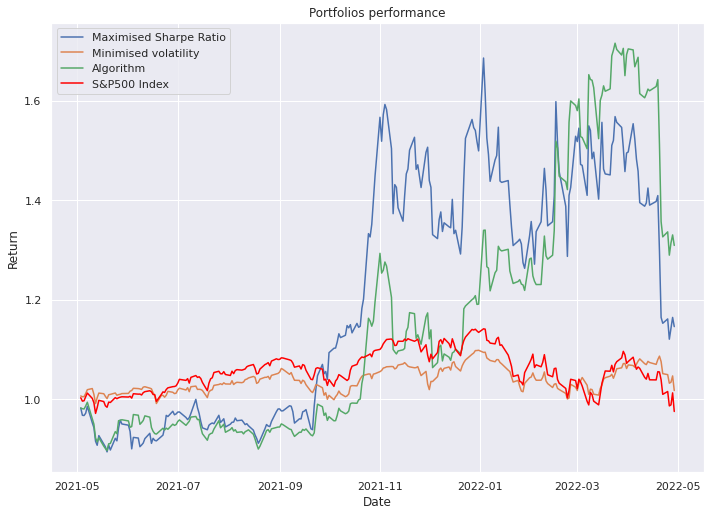

In [ ]:
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Portfolios performance")
plt.legend(loc="upper left")
plt.plot(trade_days,ms_cum_return,label="Maximised Sharpe Ratio")
plt.plot(trade_days,mv_cum_return,label="Minimised volatility")
plt.plot(trade_days,cum_return,label="Algorithm")
plt.plot(trade_days,SnP_cum_return,c="Red",label="S&P500 Index")
plt.legend(loc="upper left")

plt.show()

In [ ]:
result = pd.DataFrame({'ms_daily_return':ms_daily_return,'mv_daily_return':mv_daily_return,'algo_daily_return':daily_return,'SnP_daily_return':SnP_array})
result.index = trade_days

In [ ]:
from google.colab import  drive

drive.mount('/drive',force_remount=True)
result.to_csv('/drive/My Drive/result_20220510_2302.csv')

Mounted at /drive
